In [7]:
!cp -r /kaggle/input/dataset-q2/dataset_Q2/color_centroids.npy /kaggle/working

In [4]:
!rm -rf dataset_Q2

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Preparing datasets...
Loaded color centroids with shape: (24, 3)
Centroid value range: [0.05, 0.96]
Sample centroids:
[[0.6260603  0.63038474 0.6212184 ]
 [0.15001483 0.1415019  0.12095974]
 [0.38839704 0.38176647 0.3473022 ]]


100%|██████████| 170M/170M [00:05<00:00, 28.9MB/s] 


Train size: 45000, Val size: 5000, Test size: 10000
PART 1: SINGLE RUN WITH BASELINE HYPERPARAMETERS
Using device: cuda
Loaded color centroids with shape: (24, 3)
Centroid value range: [0.05, 0.96]
Sample centroids:
[[0.6260603  0.63038474 0.6212184 ]
 [0.15001483 0.1415019  0.12095974]
 [0.38839704 0.38176647 0.3473022 ]]
Train size: 45000, Val size: 5000, Test size: 10000


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



Starting training for baseline_run...

Epoch 1/25


Train Loss: 2.1769, Val Loss: 1.9453
Saved best model with val_loss: 1.9453

Epoch 2/25


Train Loss: 1.9301, Val Loss: 1.8980
Saved best model with val_loss: 1.8980

Epoch 3/25


Train Loss: 1.8813, Val Loss: 1.8502
Saved best model with val_loss: 1.8502

Epoch 4/25


Train Loss: 1.8472, Val Loss: 1.8222
Saved best model with val_loss: 1.8222

Epoch 5/25


Train Loss: 1.8274, Val Loss: 1.8194
Saved best model with val_loss: 1.8194

Epoch 6/25


Train Loss: 1.8167, Val Loss: 1.8545

Epoch 7/25


Train Loss: 1.8047, Val Loss: 1.7602
Saved best model with val_loss: 1.7602

Epoch 8/25


Train Loss: 1.7968, Val Loss: 1.7895

Epoch 9/25


Train Loss: 1.7888, Val Loss: 1.7694

Epoch 10/25


Train Loss: 1.7826, Val Loss: 1.7435
Saved best model with val_loss: 1.7435

Epoch 11/25


Train Loss: 1.7760, Val Loss: 1.7558

Epoch 12/25


Train Loss: 1.7738, Val Loss: 1.7560

Epoch 13/25


Train Loss: 1.7710, Val Loss: 1.7698

Epoch 14/25


Train Loss: 1.7672, Val Loss: 1.8496

Epoch 15/25


Train Loss: 1.7635, Val Loss: 1.7367
Saved best model with val_loss: 1.7367

Epoch 16/25


Train Loss: 1.7580, Val Loss: 1.7332
Saved best model with val_loss: 1.7332

Epoch 17/25


Train Loss: 1.7584, Val Loss: 1.7391

Epoch 18/25


Train Loss: 1.7526, Val Loss: 1.7152
Saved best model with val_loss: 1.7152

Epoch 19/25


Train Loss: 1.7542, Val Loss: 1.7386

Epoch 20/25


Train Loss: 1.7500, Val Loss: 1.7198

Epoch 21/25


Train Loss: 1.7499, Val Loss: 1.7340

Epoch 22/25


Train Loss: 1.7463, Val Loss: 1.7140
Saved best model with val_loss: 1.7140

Epoch 23/25


Train Loss: 1.7432, Val Loss: 1.7358

Epoch 24/25


Train Loss: 1.7455, Val Loss: 1.7114
Saved best model with val_loss: 1.7114

Epoch 25/25


Train Loss: 1.7428, Val Loss: 1.7391

Training completed. Best val loss: 1.7114 at epoch 24


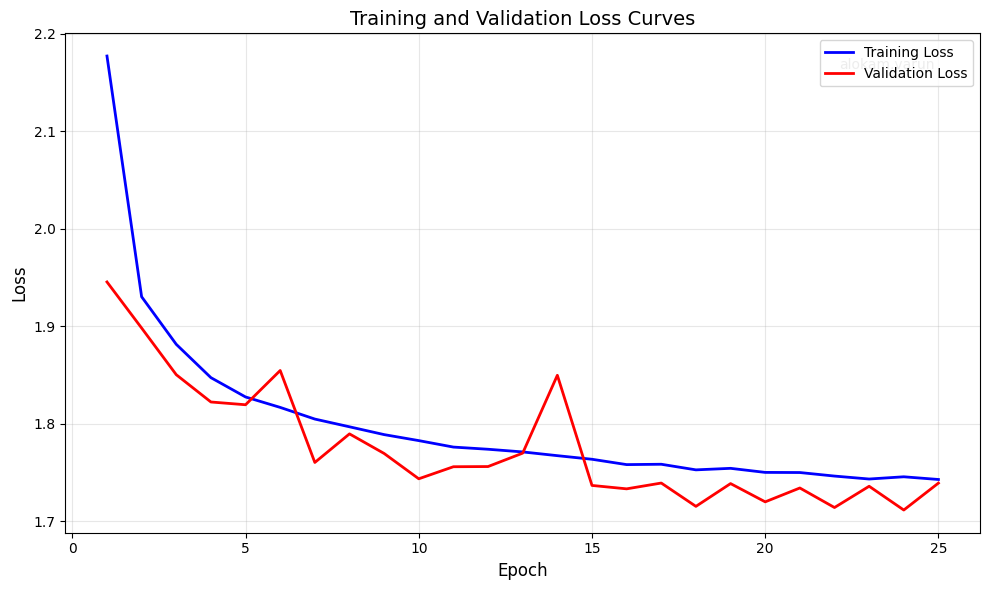


Generating colorization examples...


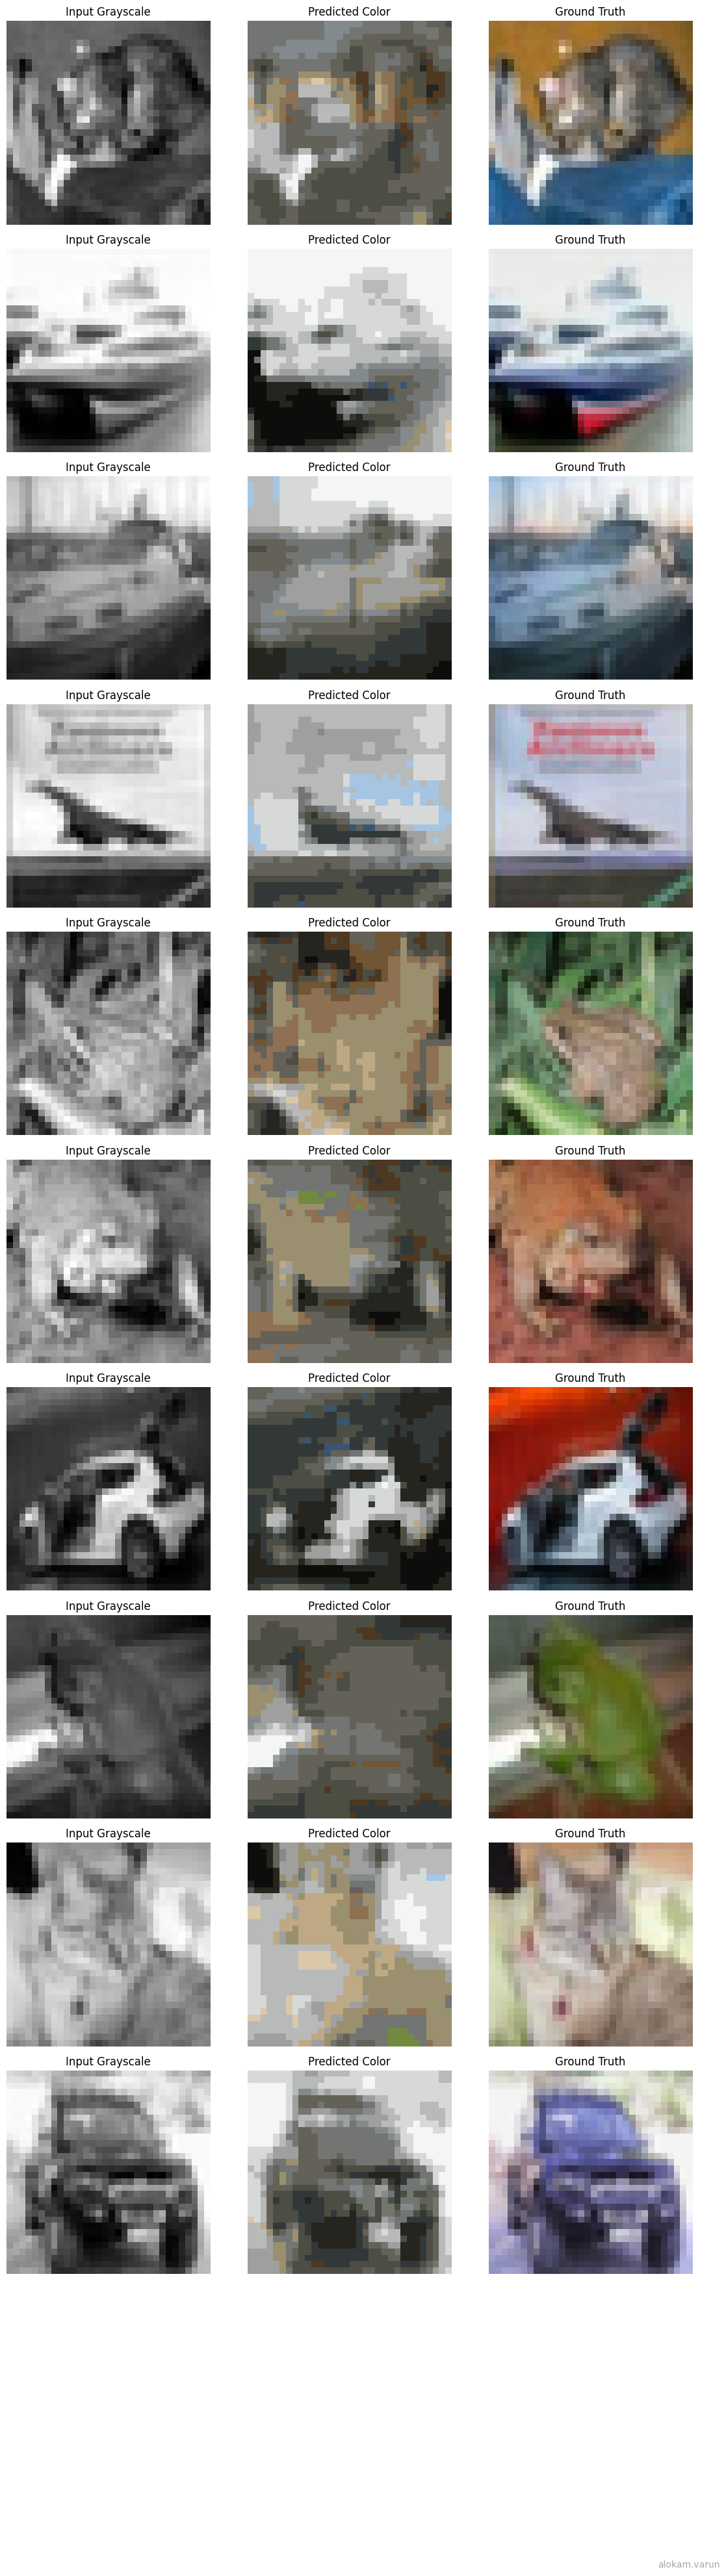


Final Test Loss: 1.7093



PART 1 SUMMARY
Best Validation Loss: 1.7114 (Epoch 24)
Test Loss: 1.7093
Checkpoint saved at: checkpoints_part1/best_model.pth
WandB Run URL: https://wandb.ai/alokamvarun-international-institute-of-information-techn/CIFAR10-Colorization-Part1/runs/yupbwt44


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import wandb
import os
from tqdm import tqdm
import json

EMAIL_USERNAME = "alokam.varun" 
WANDB_API_KEY = "69f0f82495e936ec3a69022491a631f60c0f7519" 


wandb.login(key=WANDB_API_KEY)

class CIFAR10ColorDataset(Dataset):
    """
    Custom Dataset for CIFAR-10 colorization task.
    Returns grayscale input and color class labels (24 clusters).
    """
    def __init__(self, data, centroids):
        """
        Args:
            data: CIFAR-10 dataset
            centroids: numpy array of shape [24, 3] with RGB centroids
        """
        self.data = data
        self.centroids = torch.FloatTensor(centroids)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, _ = self.data[idx]  # [3, 32, 32]

        gray_image = transforms.Grayscale(num_output_channels=1)(image)

        rgb_np = image.permute(1, 2, 0).numpy()  # [32, 32, 3]

        labels = self._assign_to_centroids(rgb_np)

        return gray_image, torch.LongTensor(labels), image

    def _assign_to_centroids(self, rgb_image):
        """
        Assign each pixel to nearest centroid.
        Args:
            rgb_image: numpy array [32, 32, 3]
        Returns:
            labels: numpy array [32, 32] with values in {0, ..., 23}
        """
        H, W, C = rgb_image.shape
        pixels = rgb_image.reshape(-1, 3) 

        centroids_np = self.centroids.numpy()
        distances = np.linalg.norm(pixels[:, None, :] - centroids_np[None, :, :], axis=2)  # [H*W, 24]

        labels = np.argmin(distances, axis=1).reshape(H, W)

        return labels


class ColorNet(nn.Module):
    """
    Encoder-Decoder CNN for image colorization.
    Architecture with deeper compression and learned upsampling.
    """
    def __init__(self, NIC=1, NF=16, NC=24, kernel_size=3):
        """
        Args:
            NIC: Number of input channels (1 for grayscale)
            NF: Number of base filters
            NC: Number of output classes (24 color clusters)
            kernel_size: Kernel size for conv layers
        """
        super(ColorNet, self).__init__()

        padding = kernel_size // 2

        self.encoder1 = nn.Sequential(
            nn.Conv2d(NIC, NF, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(NF),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(NF, 2*NF, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(2*NF),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(2*NF, 4*NF, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(4*NF),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        )

        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(4*NF, 2*NF, kernel_size=2, stride=2),  # 4x4 -> 8x8
            nn.BatchNorm2d(2*NF),
            nn.ReLU(inplace=True)
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(2*NF, NF, kernel_size=2, stride=2),  # 8x8 -> 16x16
            nn.BatchNorm2d(NF),
            nn.ReLU(inplace=True)
        )

        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(NF, NC, kernel_size=2, stride=2),  # 16x16 -> 32x32
            nn.BatchNorm2d(NC),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Conv2d(NC, NC, kernel_size=1)

    def forward(self, x):
        """
        Forward pass through the network.
        Args:
            x: input tensor [B, NIC, 32, 32]
        Returns:
            logits: output tensor [B, NC, 32, 32]
        """

        x = self.encoder1(x)  # [B, NF, 16, 16]
        x = self.encoder2(x)  # [B, 2*NF, 8, 8]
        x = self.encoder3(x)  # [B, 4*NF, 4, 4]

        x = self.decoder1(x)  # [B, 2*NF, 8, 8]
        x = self.decoder2(x)  # [B, NF, 16, 16]
        x = self.decoder3(x)  # [B, NC, 32, 32]

        x = self.classifier(x)  # [B, NC, 32, 32]

        return x


def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train model for one epoch.
    """
    model.train()
    running_loss = 0.0

    for gray, labels, _ in tqdm(dataloader, desc="Training", leave=False):
        gray = gray.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(gray)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * gray.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def validate(model, dataloader, criterion, device):
    """
    Validate model.
    """
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for gray, labels, _ in tqdm(dataloader, desc="Validation", leave=False):
            gray = gray.to(device)
            labels = labels.to(device)

            outputs = model(gray)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * gray.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def labels_to_rgb(labels, centroids):
    """
    Convert label map to RGB image using centroids.
    Args:
        labels: tensor [H, W] with values in {0, ..., 23}
        centroids: tensor [24, 3] (values should be in [0, 255] range)
    Returns:
        rgb: tensor [3, H, W] normalized to [0, 1]
    """
    H, W = labels.shape
    rgb = centroids[labels.flatten()].reshape(H, W, 3)

    if rgb.max() > 1.0:
        rgb = rgb / 255.0

    return rgb.permute(2, 0, 1)  # [3, H, W]


def visualize_results(model, dataloader, centroids, device, num_samples=10, username="username"):
    """
    Visualize colorization results.
    """
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    samples_shown = 0
    with torch.no_grad():
        for gray, labels, rgb_gt in dataloader:
            if samples_shown >= num_samples:
                break

            gray = gray.to(device)
            outputs = model(gray)
            pred_labels = torch.argmax(outputs, dim=1)

            for i in range(gray.size(0)):
                if samples_shown >= num_samples:
                    break

                axes[samples_shown, 0].imshow(gray[i, 0].cpu().numpy(), cmap='gray')
                axes[samples_shown, 0].set_title('Input Grayscale')
                axes[samples_shown, 0].axis('off')

                pred_rgb = labels_to_rgb(pred_labels[i].cpu(), centroids)
                
                pred_rgb_np = pred_rgb.permute(1, 2, 0).numpy()
                pred_rgb_np = np.clip(pred_rgb_np, 0, 1) 
                axes[samples_shown, 1].imshow(pred_rgb_np)
                axes[samples_shown, 1].set_title('Predicted Color')
                axes[samples_shown, 1].axis('off')

                gt_rgb_np = rgb_gt[i].permute(1, 2, 0).numpy()
                if gt_rgb_np.max() > 1.0:
                    gt_rgb_np = gt_rgb_np / 255.0
                axes[samples_shown, 2].imshow(gt_rgb_np)
                axes[samples_shown, 2].set_title('Ground Truth')
                axes[samples_shown, 2].axis('off')

                samples_shown += 1

    plt.text(0.95, 0.01, username, ha='right', va='bottom',
             transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
    plt.tight_layout(rect=[0, 0.02, 1, 1])  
    plt.show()

    return fig


def plot_losses(train_losses, val_losses, username="username"):
    """
    Plot training and validation loss curves.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss Curves', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.text(0.95, 0.95, username, ha='right', va='top',
             transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()


def prepare_datasets():
    """
    Prepare train, val, test datasets and dataloaders.
    Returns datasets, loaders, and centroids.
    """

    centroids = np.load('color_centroids.npy')
    if centroids.max() > 1:
      centroids=centroids/255
    print(f"Loaded color centroids with shape: {centroids.shape}")

    print(f"Centroid value range: [{centroids.min():.2f}, {centroids.max():.2f}]")
    print(f"Sample centroids:\n{centroids[:3]}")

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=transform)
    test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             download=True, transform=transform)

    train_size = int(0.9 * len(train_data))
    val_size = len(train_data) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_data, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_dataset = CIFAR10ColorDataset(train_subset, centroids)
    val_dataset = CIFAR10ColorDataset(val_subset, centroids)
    test_dataset = CIFAR10ColorDataset(test_data, centroids)

    print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

    return train_dataset, val_dataset, test_dataset, centroids


def train_model(config, train_dataset, val_dataset, test_dataset, centroids,
                project_name, run_name, checkpoint_dir):
    """
    Train a single model with given configuration.
    Returns best validation loss and test loss.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],
                             shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'],
                           shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'],
                            shuffle=False, num_workers=2, pin_memory=True)

    run = wandb.init(project=project_name, config=config, name=run_name, reinit=True)

    model = ColorNet(NIC=config['NIC'], NF=config['NF'],
                    NC=config['NC'], kernel_size=config['kernel_size'])
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0

    os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"\nStarting training for {run_name}...")
    for epoch in range(config['num_epochs']):
        print(f"\nEpoch {epoch+1}/{config['num_epochs']}")

        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss
        })

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1

            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'config': config
            }

            checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
            torch.save(checkpoint, checkpoint_path)

            wandb.save(checkpoint_path)
            print(f"Saved best model with val_loss: {val_loss:.4f}")

    print(f"\nTraining completed. Best val loss: {best_val_loss:.4f} at epoch {best_epoch}")

    checkpoint = torch.load(os.path.join(checkpoint_dir, 'best_model.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])

    plot_losses(train_losses, val_losses, EMAIL_USERNAME)

    fig_loss, ax = plt.subplots(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)
    ax.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training and Validation Loss Curves', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.text(0.95, 0.95, EMAIL_USERNAME, ha='right', va='top',
             transform=ax.transAxes, fontsize=10, color='gray', alpha=0.7)
    wandb.log({"loss_curves": wandb.Image(fig_loss)})
    plt.close(fig_loss)

    print("\nGenerating colorization examples...")
    fig_results = visualize_results(model, test_loader, torch.FloatTensor(centroids),
                                   device, num_samples=10, username=EMAIL_USERNAME)

    wandb.log({"colorization_examples": wandb.Image(fig_results)})
    plt.close(fig_results)

    test_loss = validate(model, test_loader, criterion, device)
    print(f"\nFinal Test Loss: {test_loss:.4f}")
    wandb.log({'test_loss': test_loss,
               'best_val_loss': best_val_loss,
               'best_epoch': best_epoch})

    summary = {
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss,
        'test_loss': test_loss,
        'config': config,
        'run_url': run.url
    }

    with open(os.path.join(checkpoint_dir, 'summary.json'), 'w') as f:
        json.dump(summary, f, indent=4)

    wandb.finish()

    return best_val_loss, test_loss, summary


def main_part1():
    """
    Main function for Part 1: Single run with baseline hyperparameters.
    """
    print("="*70)
    print("PART 1: SINGLE RUN WITH BASELINE HYPERPARAMETERS")
    print("="*70)

    config = {
        'learning_rate': 1e-3,
        'batch_size': 64,
        'num_epochs': 25,
        'NF': 16,
        'kernel_size': 3,
        'optimizer': 'Adam',
        'NIC': 1,
        'NC': 24
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    train_dataset, val_dataset, test_dataset, centroids = prepare_datasets()

    best_val_loss, test_loss, summary = train_model(
        config=config,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        test_dataset=test_dataset,
        centroids=centroids,
        project_name='CIFAR10-Colorization-Part1',
        run_name='baseline_run',
        checkpoint_dir='checkpoints_part1'
    )

    print("\n" + "="*70)
    print("PART 1 SUMMARY")
    print("="*70)
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {summary['best_epoch']})")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Checkpoint saved at: checkpoints_part1/best_model.pth")
    print(f"WandB Run URL: {summary['run_url']}")
    print("="*70)


if __name__ == "__main__":

    print("Preparing datasets...")
    TRAIN_DATASET, VAL_DATASET, TEST_DATASET, CENTROIDS = prepare_datasets()

    try:
        wandb.finish()
    except:
        pass

    main_part1()

Preparing datasets...
Loaded color centroids with shape: (24, 3)
Centroid value range: [0.05, 0.96]
Sample centroids:
[[0.6260603  0.63038474 0.6212184 ]
 [0.15001483 0.1415019  0.12095974]
 [0.38839704 0.38176647 0.3473022 ]]
Train size: 45000, Val size: 5000, Test size: 10000
PART 2: HYPERPARAMETER SWEEP

Total configurations to explore: 20 (random sampling)
Create sweep with ID: jncc5850
Sweep URL: https://wandb.ai/alokamvarun-international-institute-of-information-techn/CIFAR10-Colorization-Part2-Sweep/sweeps/jncc5850
Running sweep with 20 random configurations...


wandb: Agent Starting Run: yvmq5szl with config:
wandb: 	NC: 24
wandb: 	NF: 8
wandb: 	NIC: 1
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	num_epochs: 25
wandb: 	optimizer: SGD



SWEEP RUN 1/20
Config: {'learning_rate': 0.003, 'batch_size': 64, 'num_epochs': 25, 'NF': 8, 'kernel_size': 3, 'optimizer': 'SGD', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 2.8878, Val Loss: 2.6830


Epoch 2/25 - Train Loss: 2.5643, Val Loss: 2.4478


Epoch 3/25 - Train Loss: 2.3731, Val Loss: 2.2999


Epoch 4/25 - Train Loss: 2.2572, Val Loss: 2.2048


Epoch 5/25 - Train Loss: 2.1861, Val Loss: 2.1447


Epoch 6/25 - Train Loss: 2.1415, Val Loss: 2.1096


Epoch 7/25 - Train Loss: 2.1129, Val Loss: 2.0856


Epoch 8/25 - Train Loss: 2.0922, Val Loss: 2.0673


Epoch 9/25 - Train Loss: 2.0728, Val Loss: 2.0458


Epoch 10/25 - Train Loss: 2.0600, Val Loss: 2.0288


Epoch 11/25 - Train Loss: 2.0487, Val Loss: 2.0173


Epoch 12/25 - Train Loss: 2.0389, Val Loss: 2.0100


Epoch 13/25 - Train Loss: 2.0316, Val Loss: 1.9948


Epoch 14/25 - Train Loss: 2.0224, Val Loss: 2.0072


Epoch 15/25 - Train Loss: 2.0171, Val Loss: 1.9840


Epoch 16/25 - Train Loss: 2.0100, Val Loss: 1.9792


Epoch 17/25 - Train Loss: 2.0082, Val Loss: 2.0037


Epoch 18/25 - Train Loss: 2.0039, Val Loss: 1.9776


Epoch 19/25 - Train Loss: 2.0023, Val Loss: 1.9606


Epoch 20/25 - Train Loss: 1.9953, Val Loss: 1.9607


Epoch 21/25 - Train Loss: 1.9909, Val Loss: 1.9627


Epoch 22/25 - Train Loss: 1.9902, Val Loss: 1.9588


Epoch 23/25 - Train Loss: 1.9843, Val Loss: 1.9648


Epoch 24/25 - Train Loss: 1.9819, Val Loss: 1.9577


Epoch 25/25 - Train Loss: 1.9781, Val Loss: 1.9476
Best val loss: 1.9476 at epoch 25


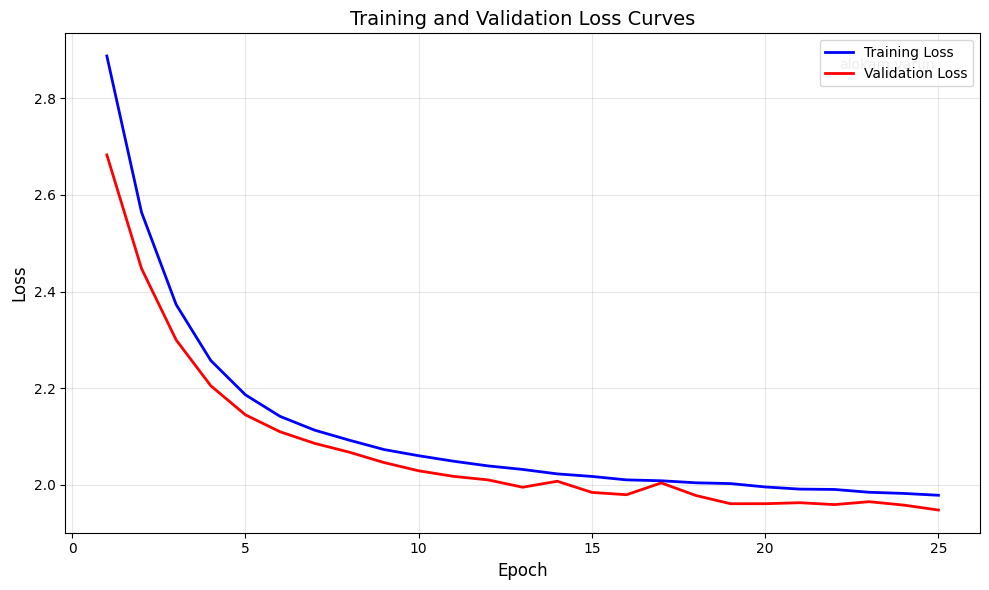

Generating colorization examples...


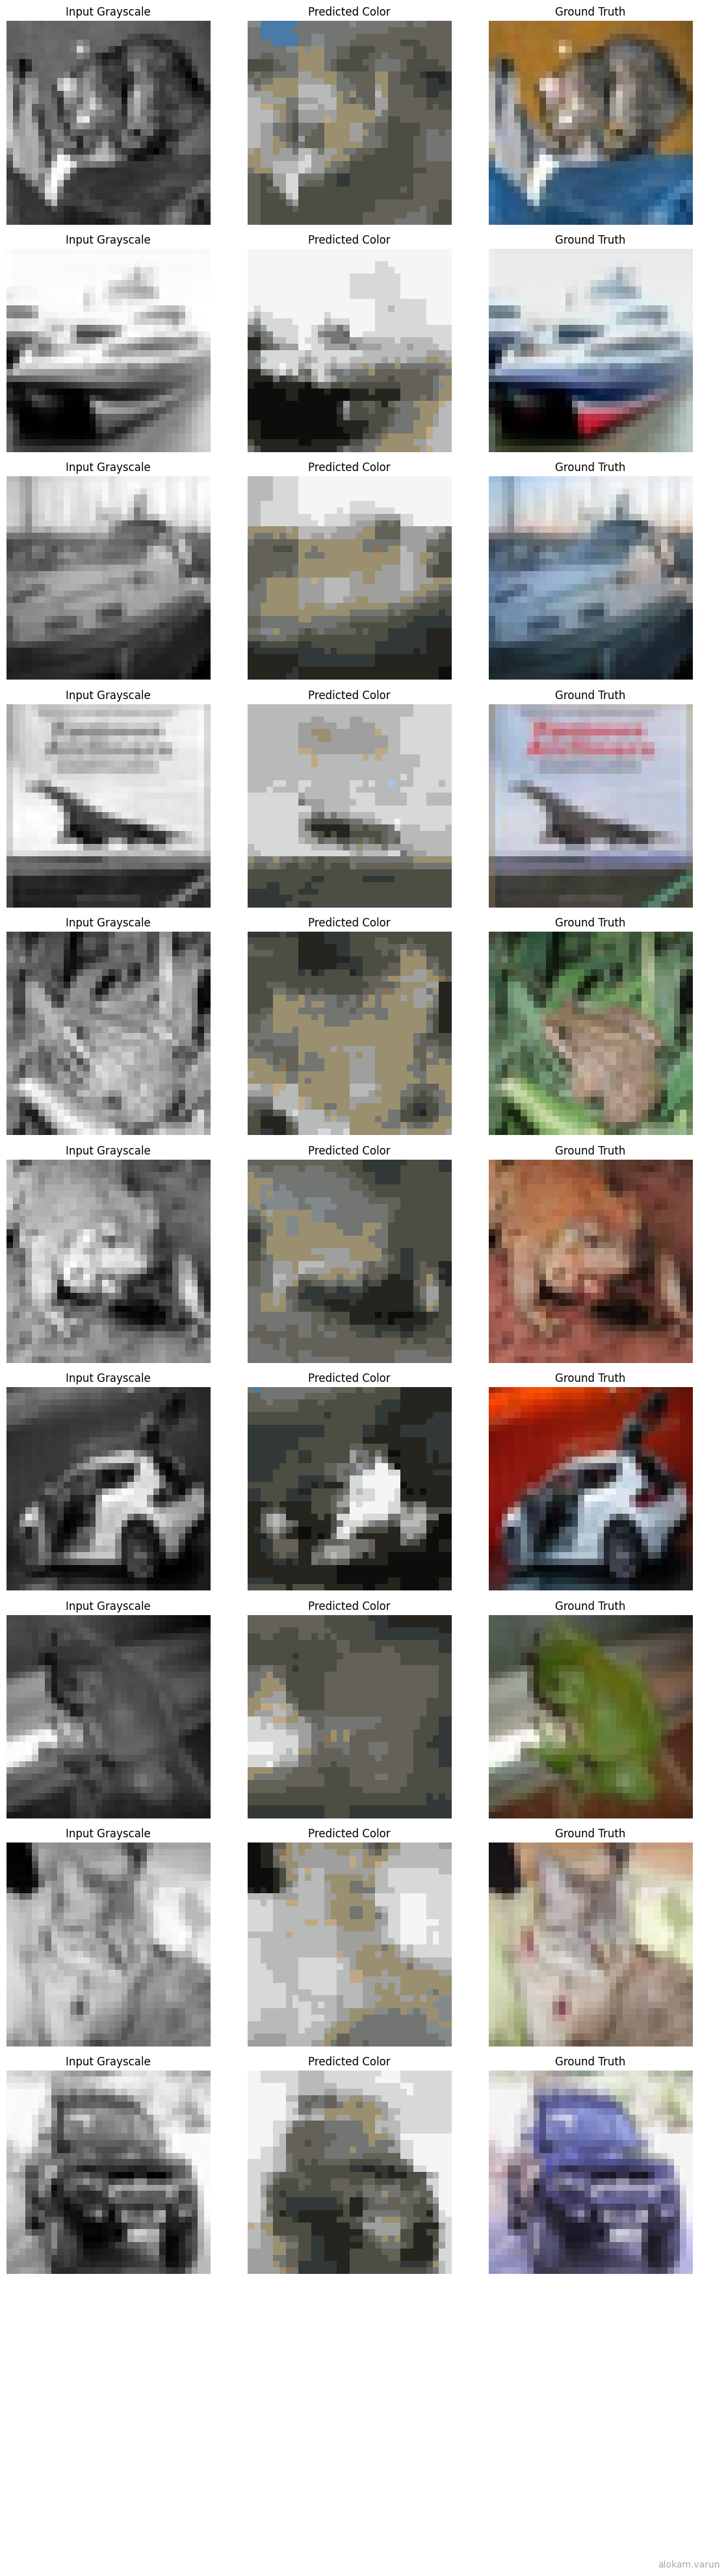

Test Loss: 1.9480

Run 1 completed!
Best Val Loss: 1.9476
Test Loss: 1.9480
Checkpoint: checkpoints_part2_sweep/run_1/best_model.pth



wandb: Agent Starting Run: rc4opunj with config:
wandb: 	NC: 24
wandb: 	NF: 16
wandb: 	NIC: 1
wandb: 	batch_size: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	num_epochs: 25
wandb: 	optimizer: Adam



SWEEP RUN 2/20
Config: {'learning_rate': 0.003, 'batch_size': 128, 'num_epochs': 25, 'NF': 16, 'kernel_size': 3, 'optimizer': 'Adam', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 2.1400, Val Loss: 1.9306


Epoch 2/25 - Train Loss: 1.8966, Val Loss: 1.8659


Epoch 3/25 - Train Loss: 1.8514, Val Loss: 1.8331


Epoch 4/25 - Train Loss: 1.8205, Val Loss: 1.8275


Epoch 5/25 - Train Loss: 1.8037, Val Loss: 1.8043


Epoch 6/25 - Train Loss: 1.7918, Val Loss: 1.7624


Epoch 7/25 - Train Loss: 1.7794, Val Loss: 1.8495


Epoch 8/25 - Train Loss: 1.7708, Val Loss: 1.7577


Epoch 9/25 - Train Loss: 1.7699, Val Loss: 1.7904


Epoch 10/25 - Train Loss: 1.7632, Val Loss: 1.8538


Epoch 11/25 - Train Loss: 1.7600, Val Loss: 1.7618


Epoch 12/25 - Train Loss: 1.7567, Val Loss: 1.7333


Epoch 13/25 - Train Loss: 1.7452, Val Loss: 1.7422


Epoch 14/25 - Train Loss: 1.7440, Val Loss: 1.7412


Epoch 15/25 - Train Loss: 1.7375, Val Loss: 1.7521


Epoch 16/25 - Train Loss: 1.7406, Val Loss: 1.7328


Epoch 17/25 - Train Loss: 1.7377, Val Loss: 1.7314


Epoch 18/25 - Train Loss: 1.7340, Val Loss: 1.7333


Epoch 19/25 - Train Loss: 1.7304, Val Loss: 1.7240


Epoch 20/25 - Train Loss: 1.7324, Val Loss: 1.8000


Epoch 21/25 - Train Loss: 1.7265, Val Loss: 1.7144


Epoch 22/25 - Train Loss: 1.7286, Val Loss: 1.7672


Epoch 23/25 - Train Loss: 1.7275, Val Loss: 1.7214


Epoch 24/25 - Train Loss: 1.7205, Val Loss: 1.7281


Epoch 25/25 - Train Loss: 1.7214, Val Loss: 1.7603
Best val loss: 1.7144 at epoch 21


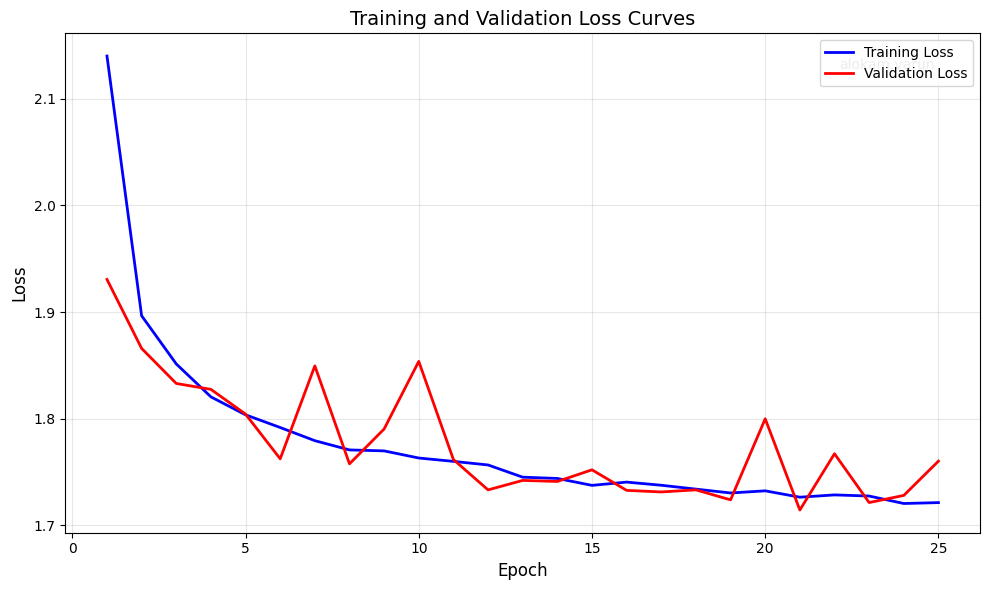

Generating colorization examples...


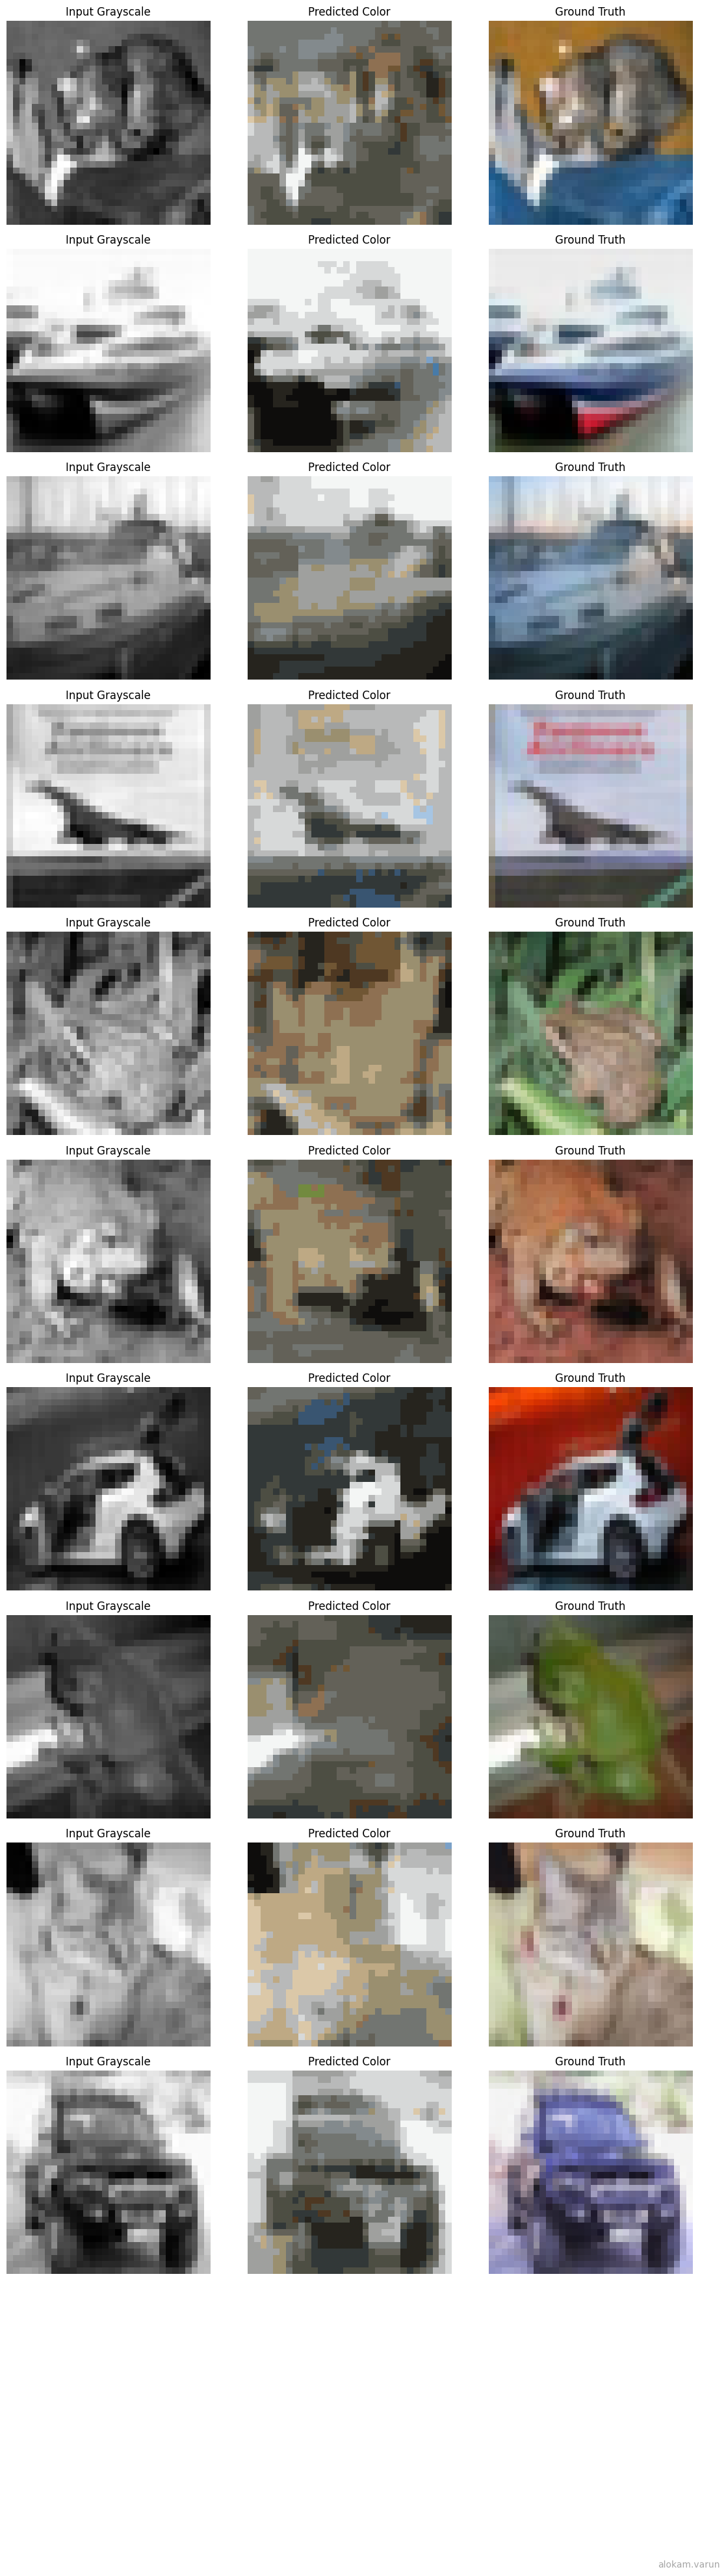

Test Loss: 1.7123

Run 2 completed!
Best Val Loss: 1.7144
Test Loss: 1.7123
Checkpoint: checkpoints_part2_sweep/run_2/best_model.pth



wandb: Agent Starting Run: 8u9y31oj with config:
wandb: 	NC: 24
wandb: 	NF: 16
wandb: 	NIC: 1
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 25
wandb: 	optimizer: Adam



SWEEP RUN 3/20
Config: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 25, 'NF': 16, 'kernel_size': 3, 'optimizer': 'Adam', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 2.1854, Val Loss: 1.9953


Epoch 2/25 - Train Loss: 1.9226, Val Loss: 1.8881


Epoch 3/25 - Train Loss: 1.8761, Val Loss: 1.8248


Epoch 4/25 - Train Loss: 1.8529, Val Loss: 1.8130


Epoch 5/25 - Train Loss: 1.8362, Val Loss: 1.9170


Epoch 6/25 - Train Loss: 1.8234, Val Loss: 1.7908


Epoch 7/25 - Train Loss: 1.8127, Val Loss: 1.7844


Epoch 8/25 - Train Loss: 1.8038, Val Loss: 1.7752


Epoch 9/25 - Train Loss: 1.7966, Val Loss: 1.7639


Epoch 10/25 - Train Loss: 1.7873, Val Loss: 1.8053


Epoch 11/25 - Train Loss: 1.7856, Val Loss: 1.8171


Epoch 12/25 - Train Loss: 1.7777, Val Loss: 1.7873


Epoch 13/25 - Train Loss: 1.7798, Val Loss: 1.7347


Epoch 14/25 - Train Loss: 1.7704, Val Loss: 1.7777


Epoch 15/25 - Train Loss: 1.7722, Val Loss: 1.7473


Epoch 16/25 - Train Loss: 1.7645, Val Loss: 1.7642


Epoch 17/25 - Train Loss: 1.7596, Val Loss: 1.7411


Epoch 18/25 - Train Loss: 1.7601, Val Loss: 1.7890


Epoch 19/25 - Train Loss: 1.7586, Val Loss: 1.7317


Epoch 20/25 - Train Loss: 1.7557, Val Loss: 1.7251


Epoch 21/25 - Train Loss: 1.7531, Val Loss: 1.7195


Epoch 22/25 - Train Loss: 1.7506, Val Loss: 1.7398


Epoch 23/25 - Train Loss: 1.7486, Val Loss: 1.7386


Epoch 24/25 - Train Loss: 1.7447, Val Loss: 1.7184


Epoch 25/25 - Train Loss: 1.7458, Val Loss: 1.7064
Best val loss: 1.7064 at epoch 25


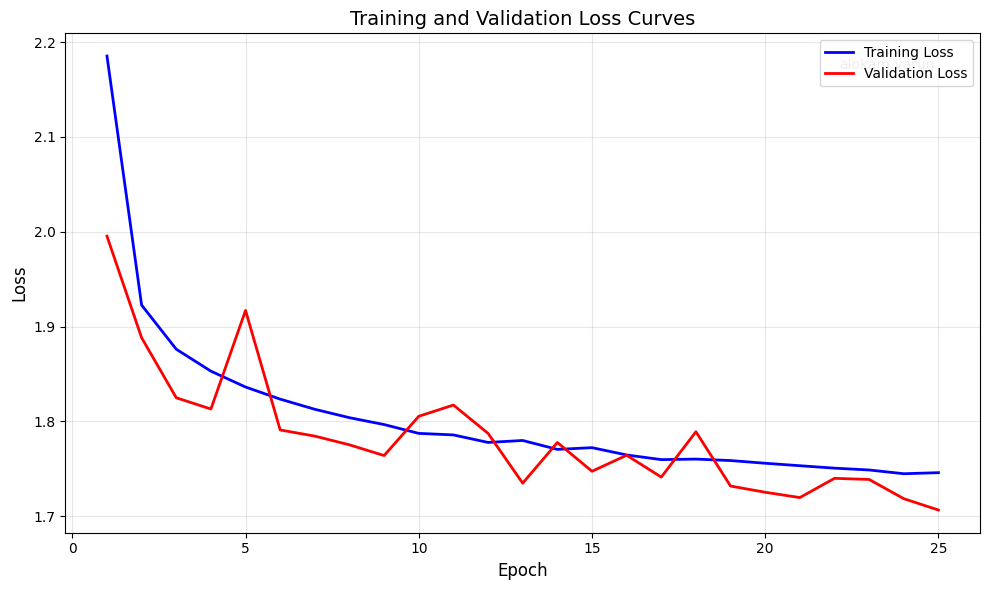

Generating colorization examples...


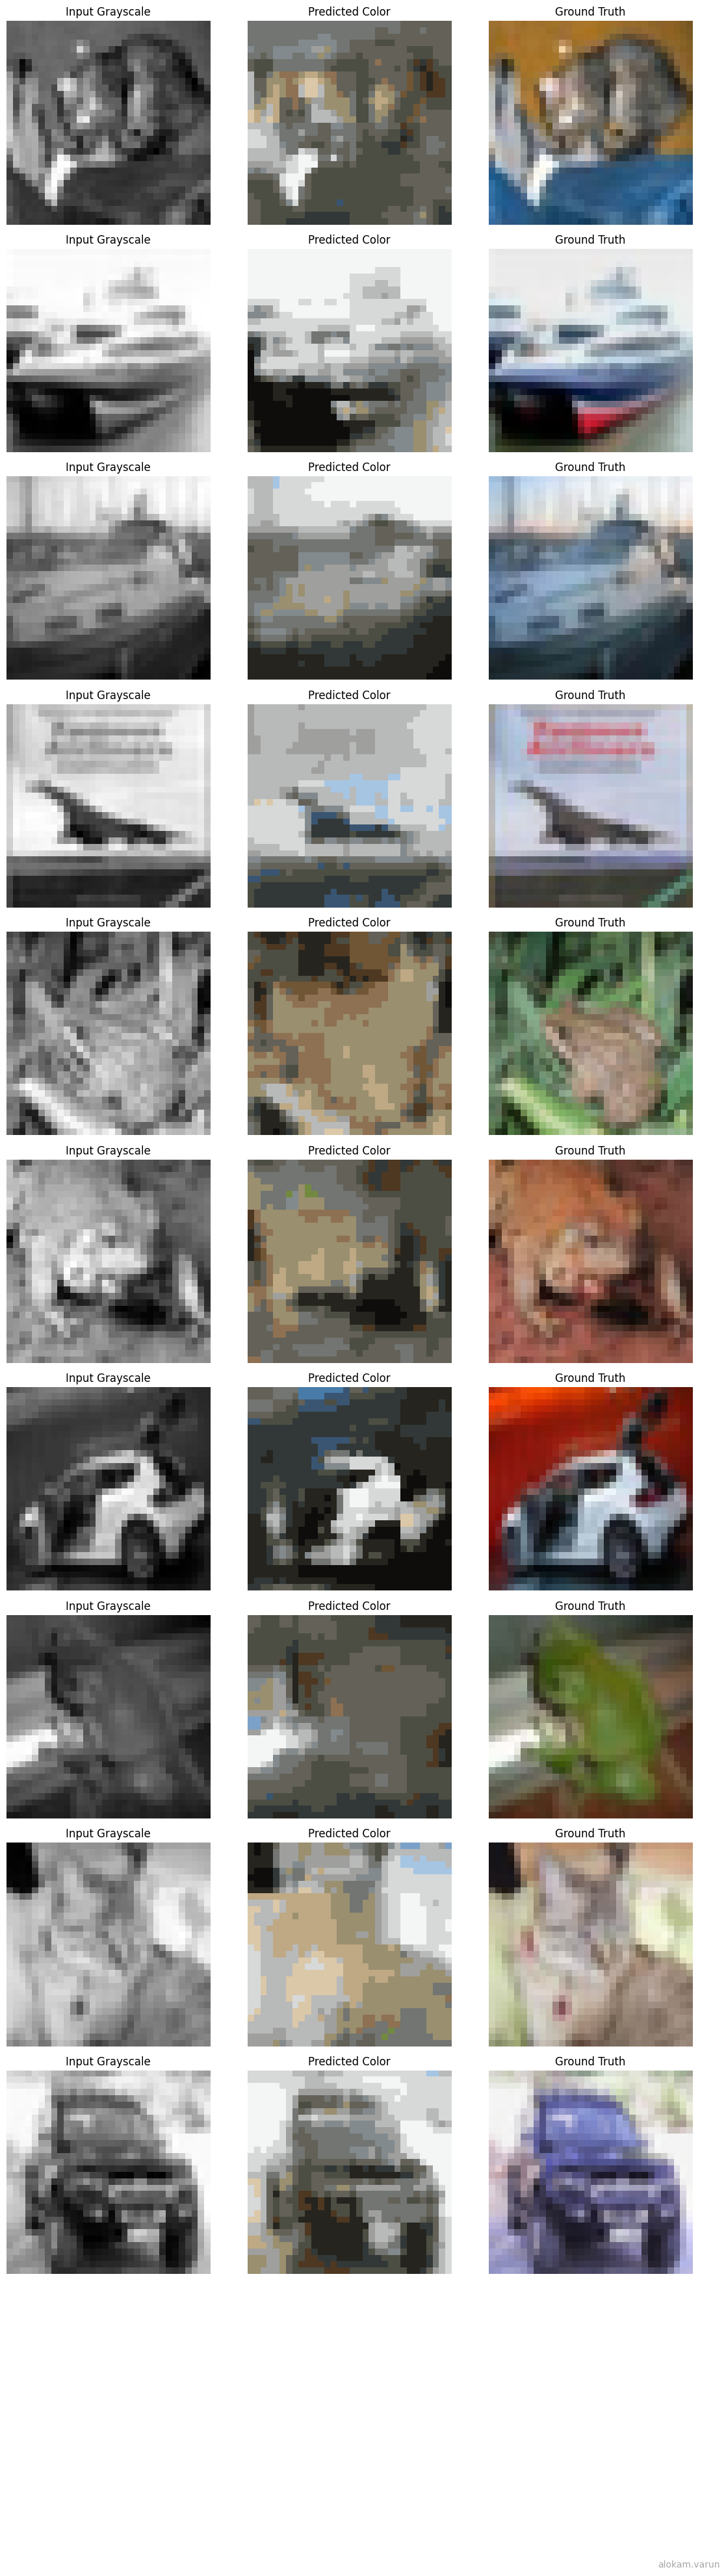

Test Loss: 1.7033

Run 3 completed!
Best Val Loss: 1.7064
Test Loss: 1.7033
Checkpoint: checkpoints_part2_sweep/run_3/best_model.pth



wandb: Agent Starting Run: t366wmjd with config:
wandb: 	NC: 24
wandb: 	NF: 8
wandb: 	NIC: 1
wandb: 	batch_size: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0003
wandb: 	num_epochs: 25
wandb: 	optimizer: SGD



SWEEP RUN 4/20
Config: {'learning_rate': 0.0003, 'batch_size': 32, 'num_epochs': 25, 'NF': 8, 'kernel_size': 3, 'optimizer': 'SGD', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 3.1401, Val Loss: 3.0291


Epoch 2/25 - Train Loss: 2.9575, Val Loss: 2.8975


Epoch 3/25 - Train Loss: 2.8545, Val Loss: 2.8067


Epoch 4/25 - Train Loss: 2.7690, Val Loss: 2.7270


Epoch 5/25 - Train Loss: 2.6782, Val Loss: 2.6190


Epoch 6/25 - Train Loss: 2.5782, Val Loss: 2.5269


Epoch 7/25 - Train Loss: 2.5052, Val Loss: 2.4627


Epoch 8/25 - Train Loss: 2.4382, Val Loss: 2.3858


Epoch 9/25 - Train Loss: 2.3804, Val Loss: 2.3413


Epoch 10/25 - Train Loss: 2.3417, Val Loss: 2.3039


Epoch 11/25 - Train Loss: 2.3135, Val Loss: 2.2799


Epoch 12/25 - Train Loss: 2.2906, Val Loss: 2.2531


Epoch 13/25 - Train Loss: 2.2718, Val Loss: 2.2359


Epoch 14/25 - Train Loss: 2.2542, Val Loss: 2.2183


Epoch 15/25 - Train Loss: 2.2399, Val Loss: 2.2056


Epoch 16/25 - Train Loss: 2.2264, Val Loss: 2.1926


Epoch 17/25 - Train Loss: 2.2164, Val Loss: 2.1767


Epoch 18/25 - Train Loss: 2.2064, Val Loss: 2.1662


Epoch 19/25 - Train Loss: 2.1971, Val Loss: 2.1541


Epoch 20/25 - Train Loss: 2.1866, Val Loss: 2.1472


Epoch 21/25 - Train Loss: 2.1800, Val Loss: 2.1369


Epoch 22/25 - Train Loss: 2.1733, Val Loss: 2.1299


Epoch 23/25 - Train Loss: 2.1651, Val Loss: 2.1212


Epoch 24/25 - Train Loss: 2.1585, Val Loss: 2.1128


Epoch 25/25 - Train Loss: 2.1531, Val Loss: 2.1052
Best val loss: 2.1052 at epoch 25


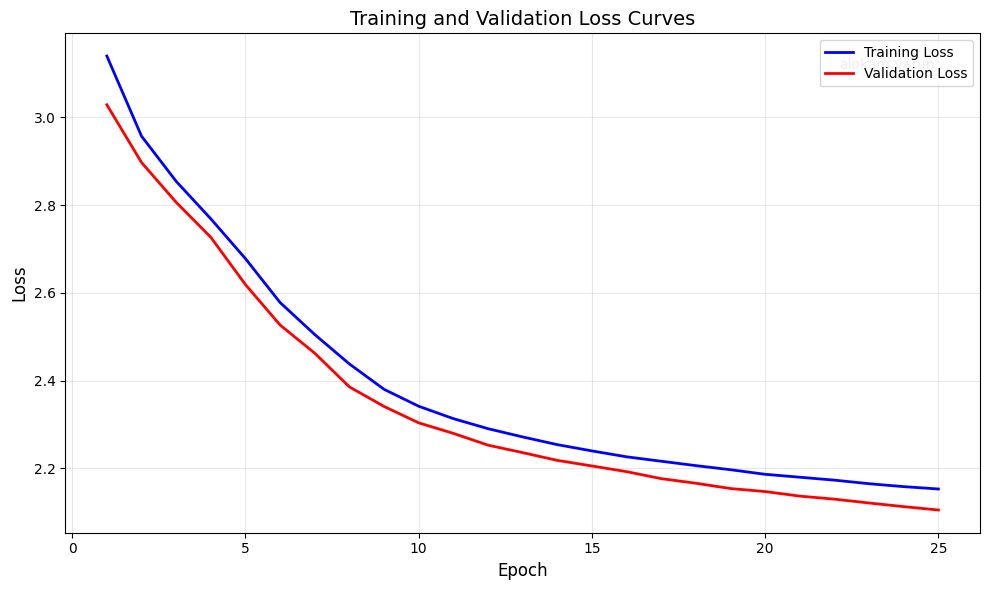

Generating colorization examples...


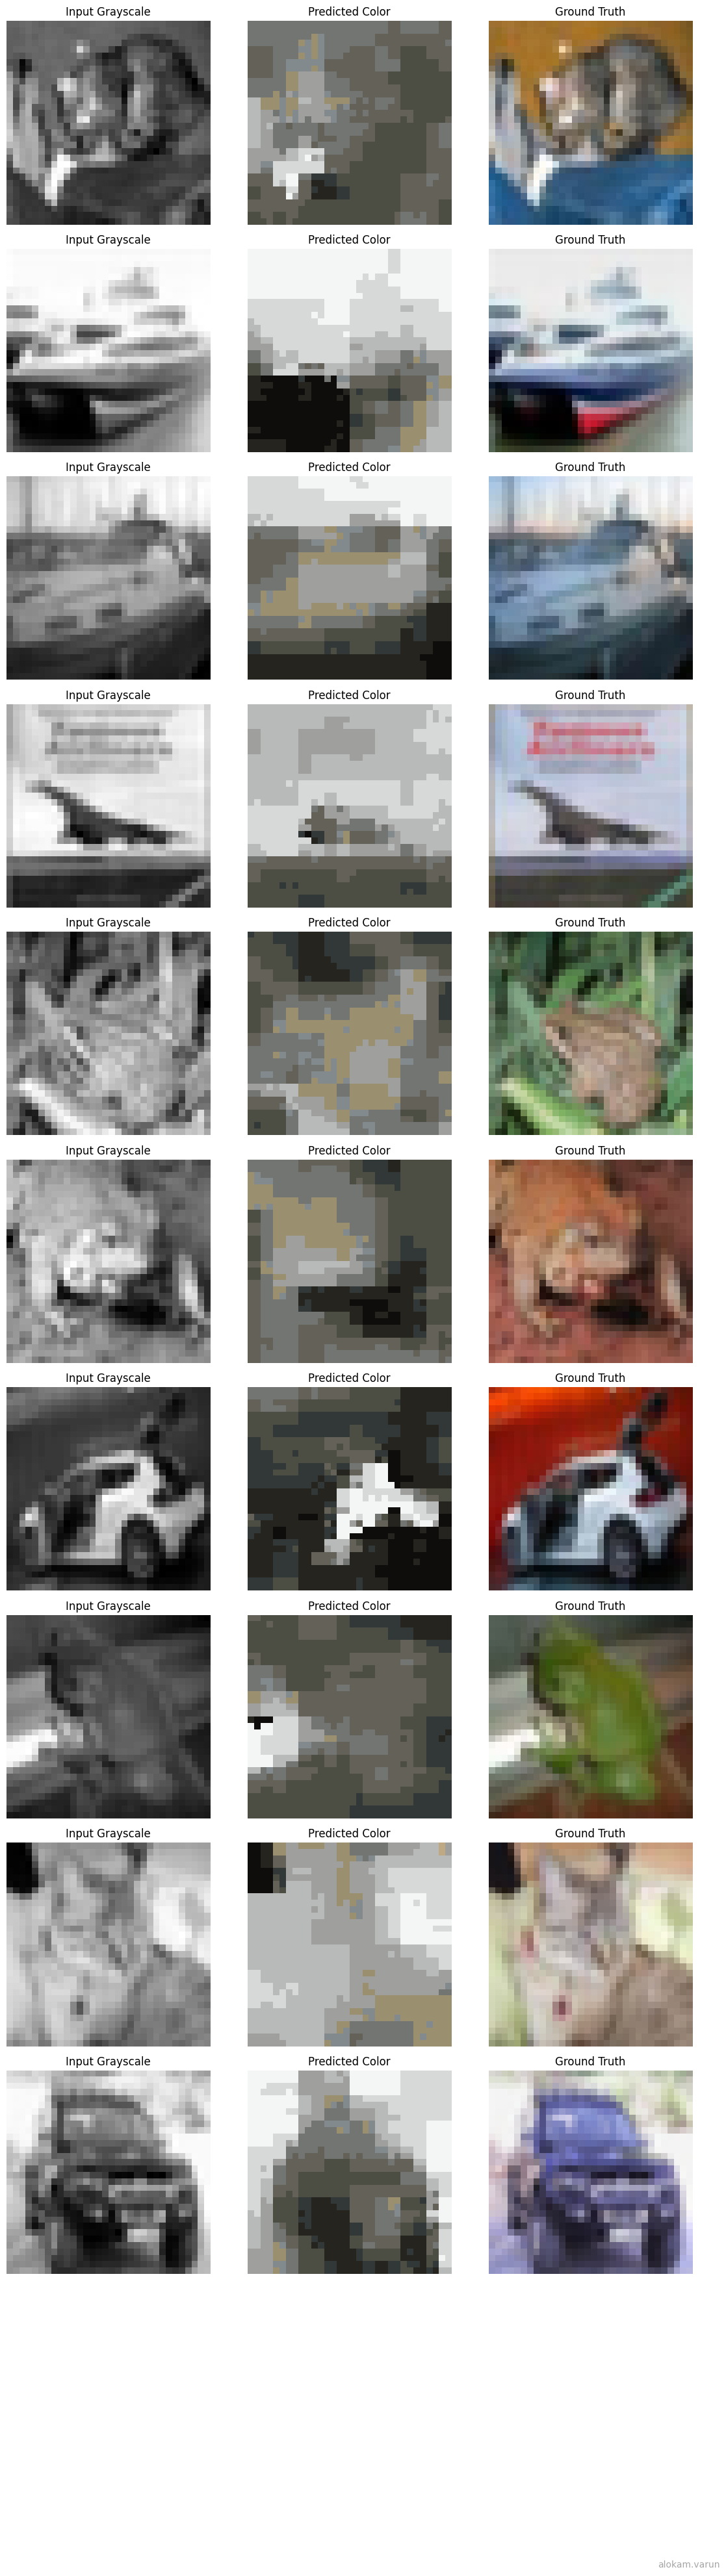

Test Loss: 2.1061

Run 4 completed!
Best Val Loss: 2.1052
Test Loss: 2.1061
Checkpoint: checkpoints_part2_sweep/run_4/best_model.pth



wandb: Agent Starting Run: 2m6hchzb with config:
wandb: 	NC: 24
wandb: 	NF: 32
wandb: 	NIC: 1
wandb: 	batch_size: 64
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	num_epochs: 25
wandb: 	optimizer: Adam



SWEEP RUN 5/20
Config: {'learning_rate': 0.0003, 'batch_size': 64, 'num_epochs': 25, 'NF': 32, 'kernel_size': 5, 'optimizer': 'Adam', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 2.3418, Val Loss: 1.9440


Epoch 2/25 - Train Loss: 1.8422, Val Loss: 1.7466


Epoch 3/25 - Train Loss: 1.7160, Val Loss: 1.6571


Epoch 4/25 - Train Loss: 1.6558, Val Loss: 1.6077


Epoch 5/25 - Train Loss: 1.6153, Val Loss: 1.5716


Epoch 6/25 - Train Loss: 1.5896, Val Loss: 1.5419


Epoch 7/25 - Train Loss: 1.5658, Val Loss: 1.5224


Epoch 8/25 - Train Loss: 1.5478, Val Loss: 1.5250


Epoch 9/25 - Train Loss: 1.5390, Val Loss: 1.5609


Epoch 10/25 - Train Loss: 1.5223, Val Loss: 1.5121


Epoch 11/25 - Train Loss: 1.5115, Val Loss: 1.4688


Epoch 12/25 - Train Loss: 1.5069, Val Loss: 1.4670


Epoch 13/25 - Train Loss: 1.4967, Val Loss: 1.5624


Epoch 14/25 - Train Loss: 1.4958, Val Loss: 1.4796


Epoch 15/25 - Train Loss: 1.4864, Val Loss: 1.4692


Epoch 16/25 - Train Loss: 1.4789, Val Loss: 1.4452


Epoch 17/25 - Train Loss: 1.4700, Val Loss: 1.4433


Epoch 18/25 - Train Loss: 1.4691, Val Loss: 1.4596


Epoch 19/25 - Train Loss: 1.4638, Val Loss: 1.4624


Epoch 20/25 - Train Loss: 1.4622, Val Loss: 1.4653


Epoch 21/25 - Train Loss: 1.4583, Val Loss: 1.4436


Epoch 22/25 - Train Loss: 1.4521, Val Loss: 1.4681


Epoch 23/25 - Train Loss: 1.4438, Val Loss: 1.5040


Epoch 24/25 - Train Loss: 1.4430, Val Loss: 1.4177


Epoch 25/25 - Train Loss: 1.4415, Val Loss: 1.4420
Best val loss: 1.4177 at epoch 24


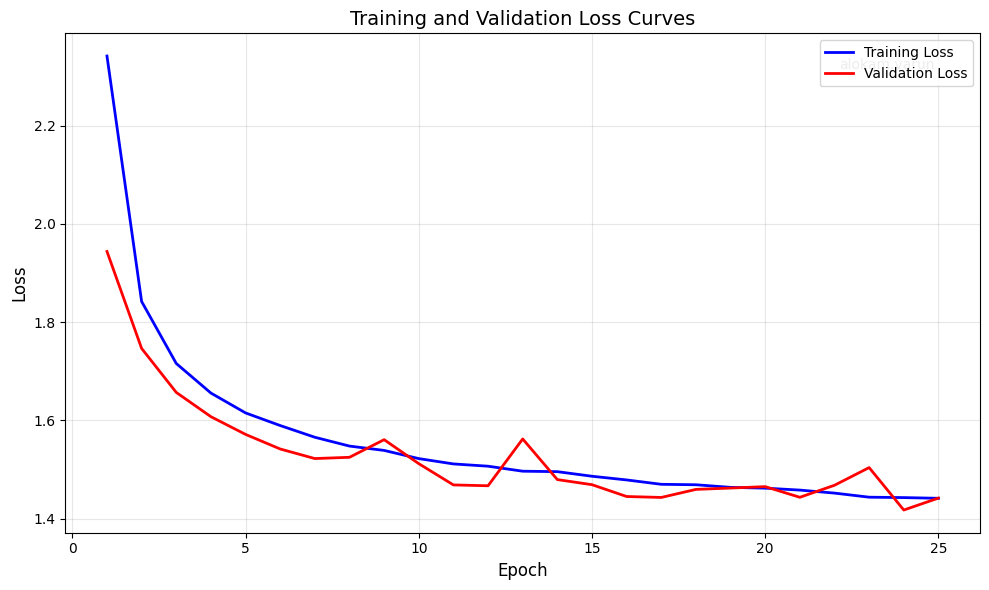

Generating colorization examples...


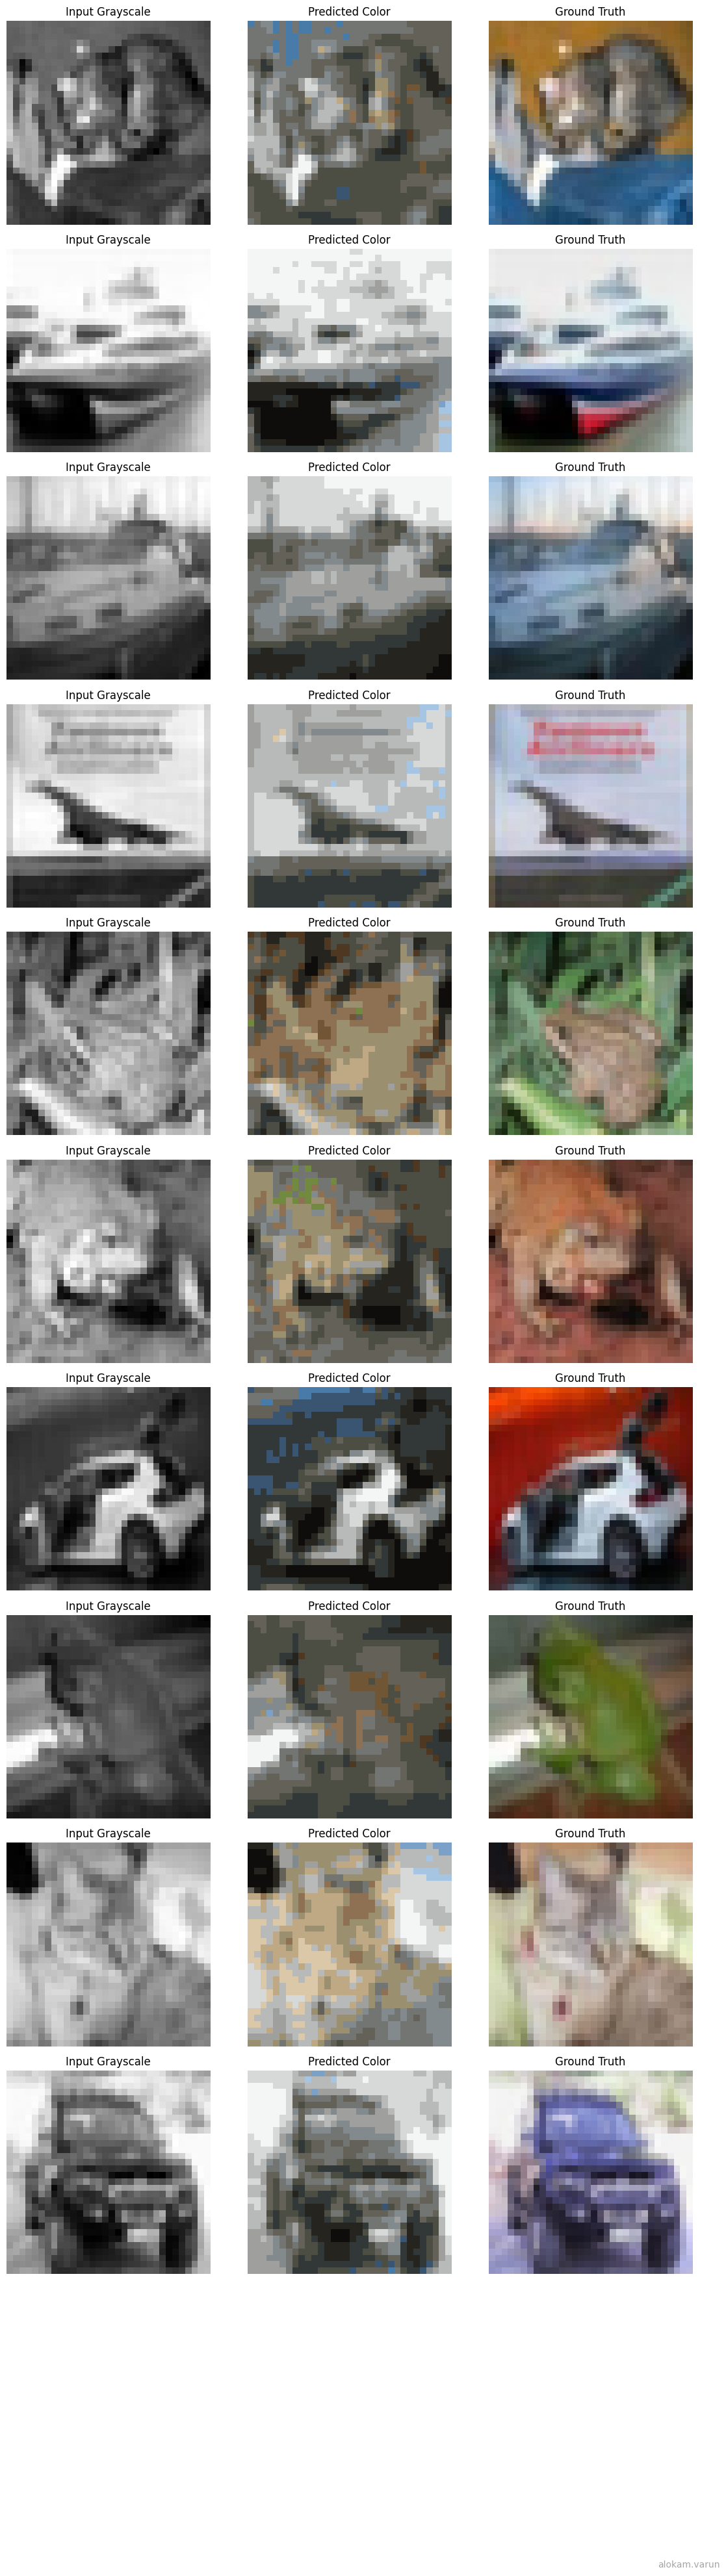

Test Loss: 1.4134

Run 5 completed!
Best Val Loss: 1.4177
Test Loss: 1.4134
Checkpoint: checkpoints_part2_sweep/run_5/best_model.pth



wandb: Agent Starting Run: x8coeaui with config:
wandb: 	NC: 24
wandb: 	NF: 32
wandb: 	NIC: 1
wandb: 	batch_size: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 25
wandb: 	optimizer: SGD



SWEEP RUN 6/20
Config: {'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 25, 'NF': 32, 'kernel_size': 3, 'optimizer': 'SGD', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 3.2412, Val Loss: 3.2255


Epoch 2/25 - Train Loss: 3.2155, Val Loss: 3.2018


Epoch 3/25 - Train Loss: 3.1922, Val Loss: 3.1796


Epoch 4/25 - Train Loss: 3.1708, Val Loss: 3.1591


Epoch 5/25 - Train Loss: 3.1508, Val Loss: 3.1400


Epoch 6/25 - Train Loss: 3.1318, Val Loss: 3.1212


Epoch 7/25 - Train Loss: 3.1136, Val Loss: 3.1032


Epoch 8/25 - Train Loss: 3.0959, Val Loss: 3.0853


Epoch 9/25 - Train Loss: 3.0786, Val Loss: 3.0684


Epoch 10/25 - Train Loss: 3.0616, Val Loss: 3.0521


Epoch 11/25 - Train Loss: 3.0449, Val Loss: 3.0358


Epoch 12/25 - Train Loss: 3.0288, Val Loss: 3.0194


Epoch 13/25 - Train Loss: 3.0134, Val Loss: 3.0037


Epoch 14/25 - Train Loss: 2.9986, Val Loss: 2.9912


Epoch 15/25 - Train Loss: 2.9844, Val Loss: 2.9762


Epoch 16/25 - Train Loss: 2.9709, Val Loss: 2.9626


Epoch 17/25 - Train Loss: 2.9577, Val Loss: 2.9504


Epoch 18/25 - Train Loss: 2.9446, Val Loss: 2.9367


Epoch 19/25 - Train Loss: 2.9318, Val Loss: 2.9246


Epoch 20/25 - Train Loss: 2.9187, Val Loss: 2.9102


Epoch 21/25 - Train Loss: 2.9055, Val Loss: 2.8970


Epoch 22/25 - Train Loss: 2.8919, Val Loss: 2.8827


Epoch 23/25 - Train Loss: 2.8779, Val Loss: 2.8698


Epoch 24/25 - Train Loss: 2.8636, Val Loss: 2.8530


Epoch 25/25 - Train Loss: 2.8486, Val Loss: 2.8392
Best val loss: 2.8392 at epoch 25


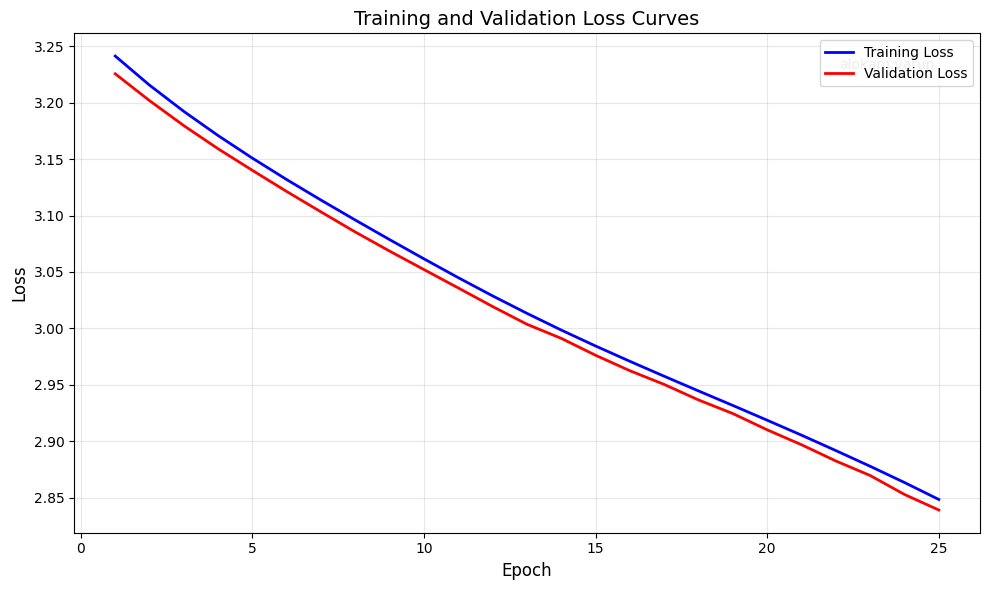

Generating colorization examples...


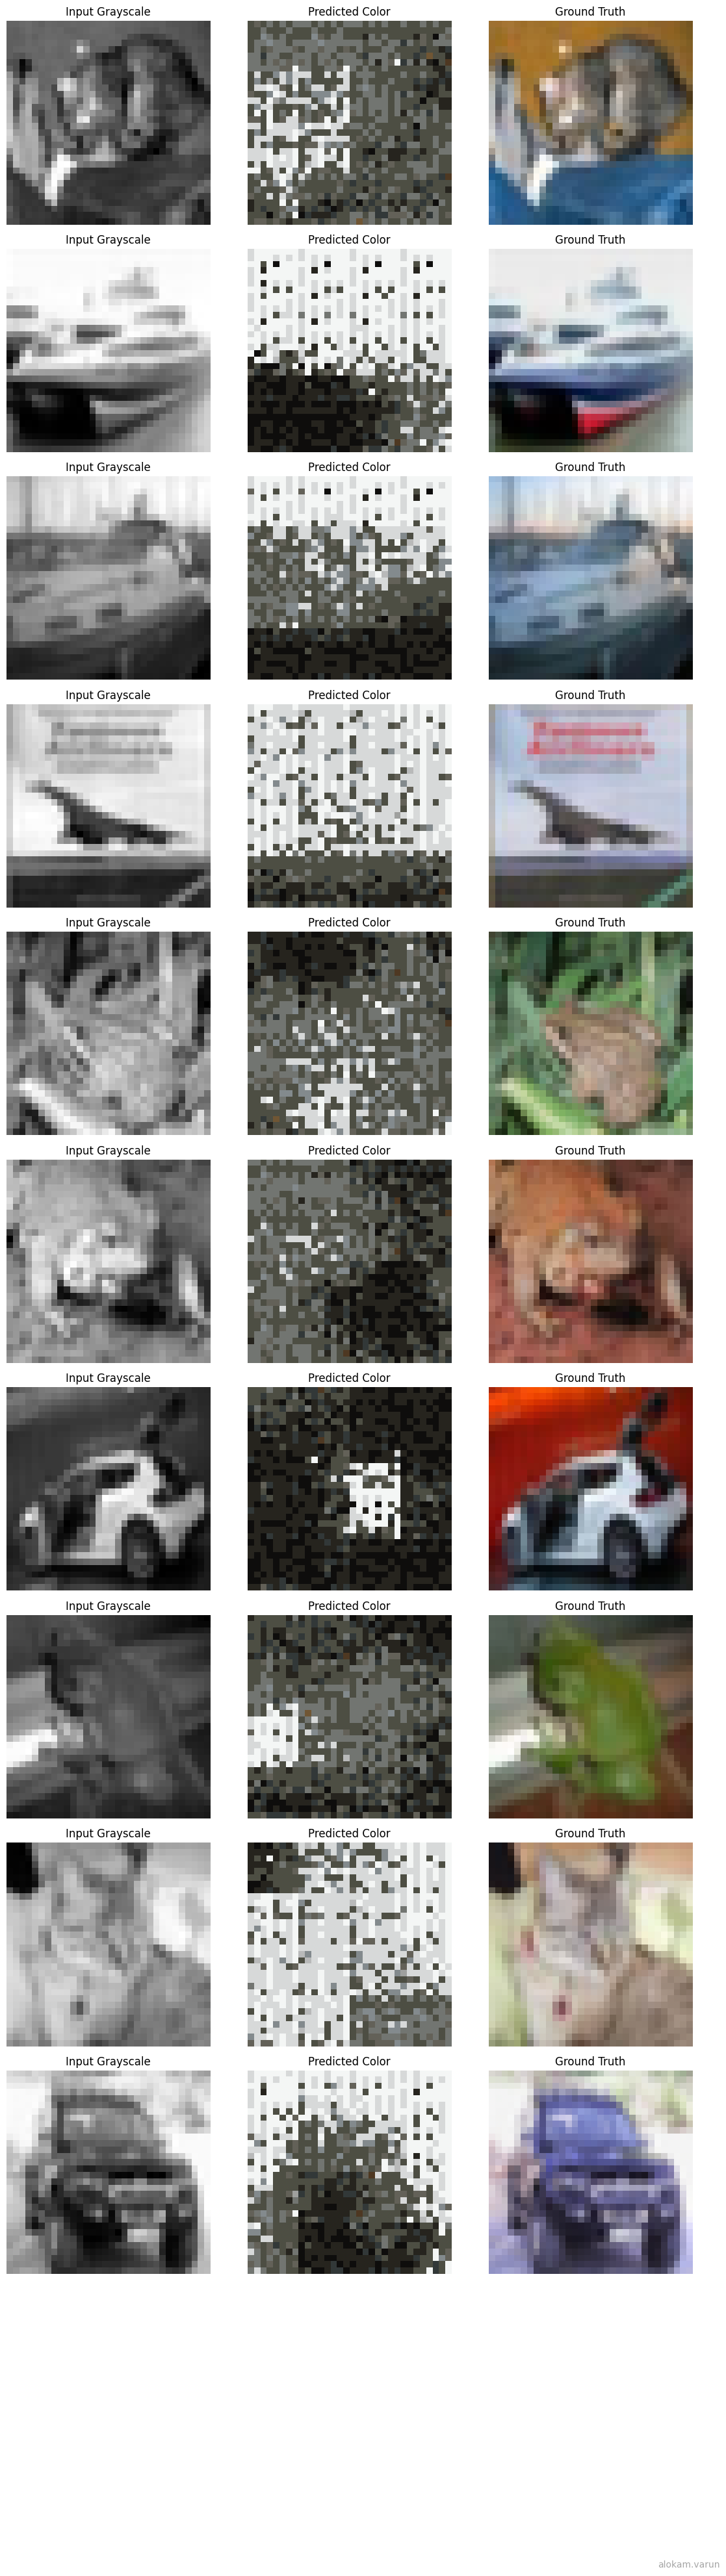

Test Loss: 2.8448

Run 6 completed!
Best Val Loss: 2.8392
Test Loss: 2.8448
Checkpoint: checkpoints_part2_sweep/run_6/best_model.pth



wandb: Agent Starting Run: 2z9vc052 with config:
wandb: 	NC: 24
wandb: 	NF: 32
wandb: 	NIC: 1
wandb: 	batch_size: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	num_epochs: 25
wandb: 	optimizer: Adam



SWEEP RUN 7/20
Config: {'learning_rate': 0.003, 'batch_size': 32, 'num_epochs': 25, 'NF': 32, 'kernel_size': 3, 'optimizer': 'Adam', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 1.9640, Val Loss: 1.8052


Epoch 2/25 - Train Loss: 1.8035, Val Loss: 1.7299


Epoch 3/25 - Train Loss: 1.7665, Val Loss: 1.7154


Epoch 4/25 - Train Loss: 1.7385, Val Loss: 1.7733


Epoch 5/25 - Train Loss: 1.7236, Val Loss: 1.7399


Epoch 6/25 - Train Loss: 1.6951, Val Loss: 1.7013


Epoch 7/25 - Train Loss: 1.6787, Val Loss: 1.6882


Epoch 8/25 - Train Loss: 1.6671, Val Loss: 1.6971


Epoch 9/25 - Train Loss: 1.6544, Val Loss: 1.6162


Epoch 10/25 - Train Loss: 1.6461, Val Loss: 1.6272


Epoch 11/25 - Train Loss: 1.6389, Val Loss: 1.6469


Epoch 12/25 - Train Loss: 1.6315, Val Loss: 1.6255


Epoch 13/25 - Train Loss: 1.6233, Val Loss: 1.5926


Epoch 14/25 - Train Loss: 1.6200, Val Loss: 1.6017


Epoch 15/25 - Train Loss: 1.6140, Val Loss: 1.6420


Epoch 16/25 - Train Loss: 1.6123, Val Loss: 1.5808


Epoch 17/25 - Train Loss: 1.6041, Val Loss: 1.6167


Epoch 18/25 - Train Loss: 1.6001, Val Loss: 1.5846


Epoch 19/25 - Train Loss: 1.5980, Val Loss: 1.5817


Epoch 20/25 - Train Loss: 1.5945, Val Loss: 1.5947


Epoch 21/25 - Train Loss: 1.5888, Val Loss: 1.5819


Epoch 22/25 - Train Loss: 1.5867, Val Loss: 1.5787


Epoch 23/25 - Train Loss: 1.5851, Val Loss: 1.5851


Epoch 24/25 - Train Loss: 1.5824, Val Loss: 1.5870


Epoch 25/25 - Train Loss: 1.5768, Val Loss: 1.5873
Best val loss: 1.5787 at epoch 22


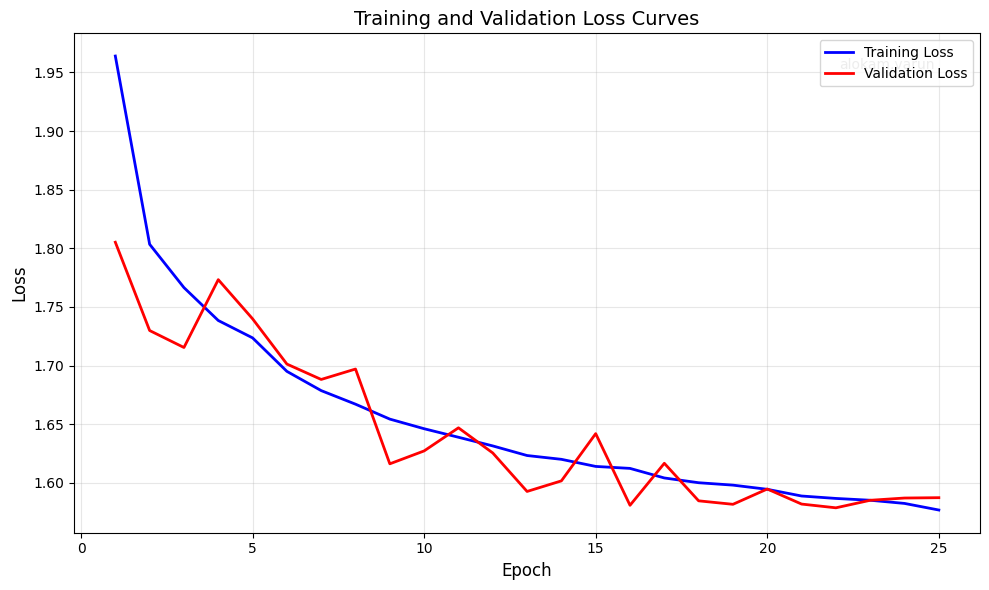

Generating colorization examples...


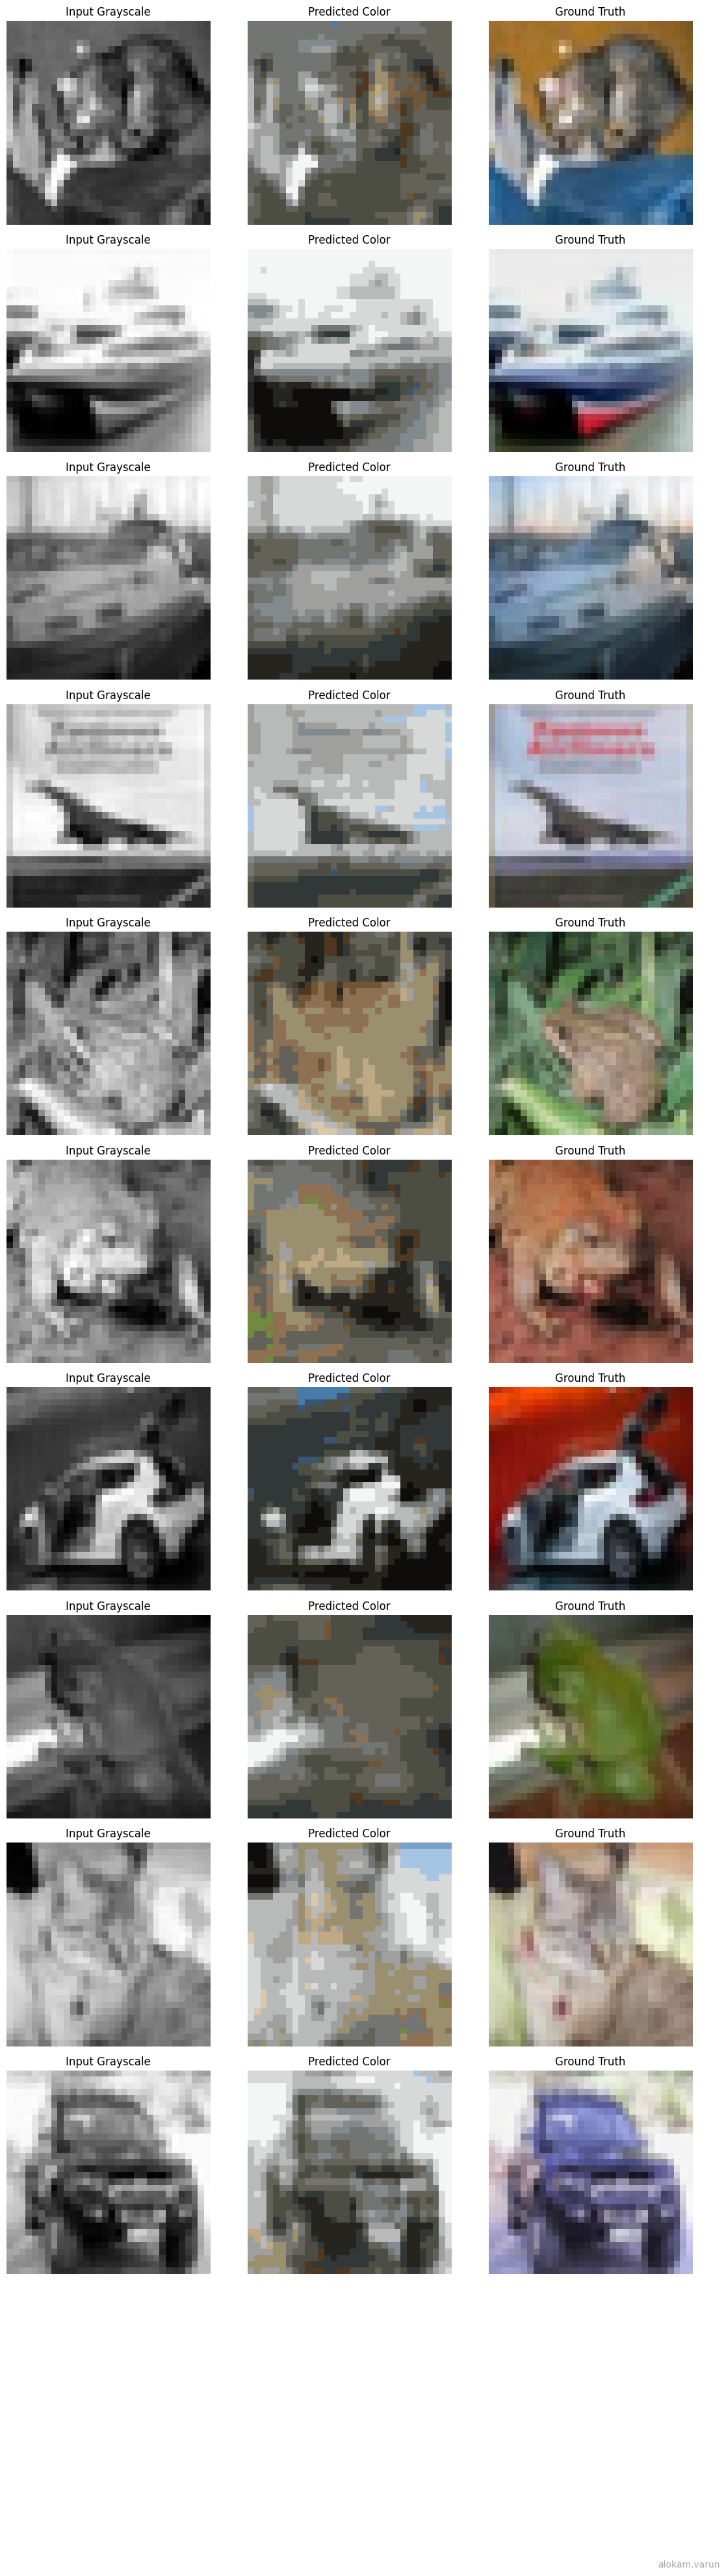

Test Loss: 1.5767

Run 7 completed!
Best Val Loss: 1.5787
Test Loss: 1.5767
Checkpoint: checkpoints_part2_sweep/run_7/best_model.pth



wandb: Agent Starting Run: 5ktaob1u with config:
wandb: 	NC: 24
wandb: 	NF: 32
wandb: 	NIC: 1
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 25
wandb: 	optimizer: Adam



SWEEP RUN 8/20
Config: {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 25, 'NF': 32, 'kernel_size': 3, 'optimizer': 'Adam', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 2.7025, Val Loss: 2.4092


Epoch 2/25 - Train Loss: 2.2630, Val Loss: 2.1370


Epoch 3/25 - Train Loss: 2.0878, Val Loss: 2.0133


Epoch 4/25 - Train Loss: 1.9993, Val Loss: 1.9420


Epoch 5/25 - Train Loss: 1.9428, Val Loss: 1.9004


Epoch 6/25 - Train Loss: 1.9042, Val Loss: 1.8573


Epoch 7/25 - Train Loss: 1.8706, Val Loss: 1.8318


Epoch 8/25 - Train Loss: 1.8472, Val Loss: 1.8054


Epoch 9/25 - Train Loss: 1.8212, Val Loss: 1.7821


Epoch 10/25 - Train Loss: 1.8063, Val Loss: 1.7615


Epoch 11/25 - Train Loss: 1.7899, Val Loss: 1.7540


Epoch 12/25 - Train Loss: 1.7786, Val Loss: 1.7393


Epoch 13/25 - Train Loss: 1.7708, Val Loss: 1.7339


Epoch 14/25 - Train Loss: 1.7614, Val Loss: 1.7245


Epoch 15/25 - Train Loss: 1.7535, Val Loss: 1.7191


Epoch 16/25 - Train Loss: 1.7478, Val Loss: 1.7260


Epoch 17/25 - Train Loss: 1.7395, Val Loss: 1.7101


Epoch 18/25 - Train Loss: 1.7357, Val Loss: 1.7003


Epoch 19/25 - Train Loss: 1.7305, Val Loss: 1.6966


Epoch 20/25 - Train Loss: 1.7246, Val Loss: 1.6977


Epoch 21/25 - Train Loss: 1.7199, Val Loss: 1.6918


Epoch 22/25 - Train Loss: 1.7181, Val Loss: 1.6885


Epoch 23/25 - Train Loss: 1.7126, Val Loss: 1.6798


Epoch 24/25 - Train Loss: 1.7086, Val Loss: 1.6767


Epoch 25/25 - Train Loss: 1.7071, Val Loss: 1.6761
Best val loss: 1.6761 at epoch 25


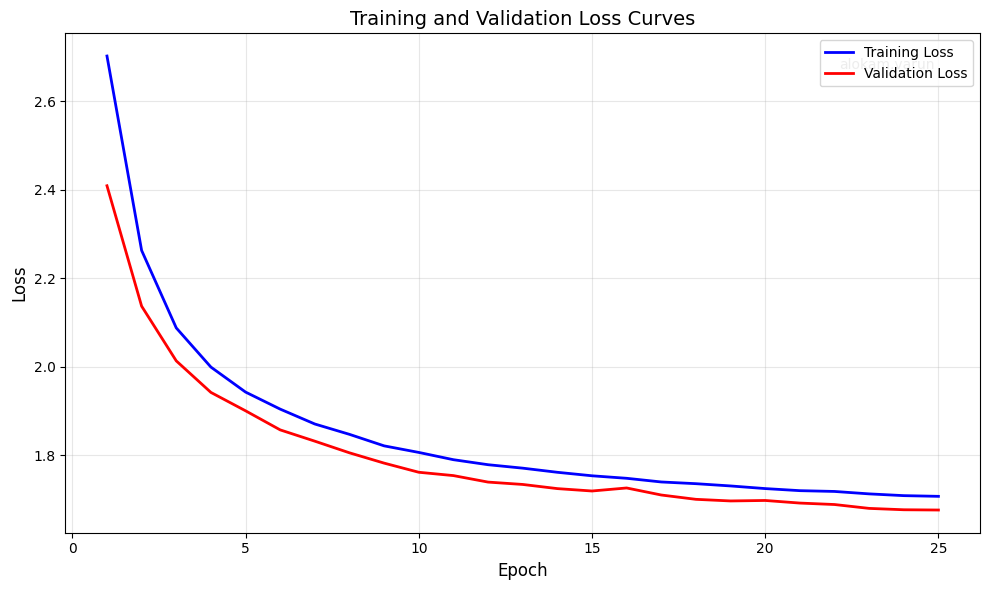

Generating colorization examples...


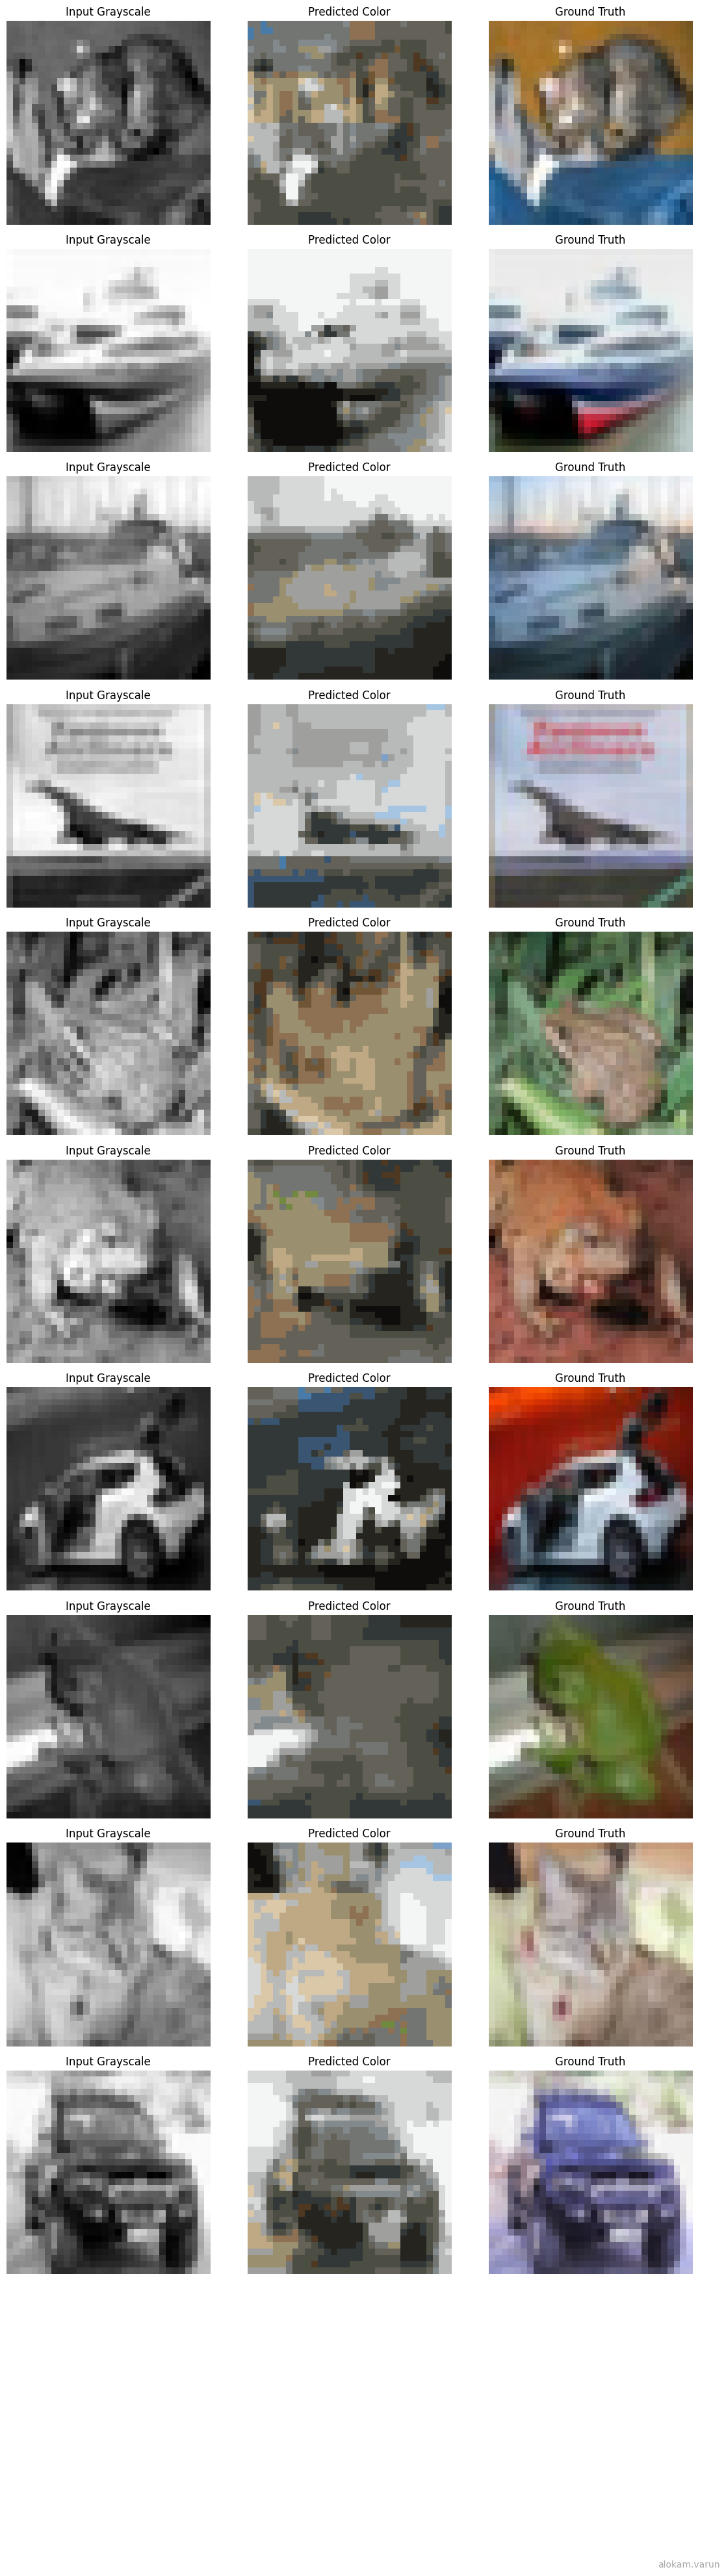

Test Loss: 1.6734

Run 8 completed!
Best Val Loss: 1.6761
Test Loss: 1.6734
Checkpoint: checkpoints_part2_sweep/run_8/best_model.pth



wandb: Agent Starting Run: v49hdvjf with config:
wandb: 	NC: 24
wandb: 	NF: 8
wandb: 	NIC: 1
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.003
wandb: 	num_epochs: 25
wandb: 	optimizer: SGD



SWEEP RUN 9/20
Config: {'learning_rate': 0.003, 'batch_size': 64, 'num_epochs': 25, 'NF': 8, 'kernel_size': 3, 'optimizer': 'SGD', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 2.9026, Val Loss: 2.6194


Epoch 2/25 - Train Loss: 2.4596, Val Loss: 2.3357


Epoch 3/25 - Train Loss: 2.2834, Val Loss: 2.2226


Epoch 4/25 - Train Loss: 2.2068, Val Loss: 2.1601


Epoch 5/25 - Train Loss: 2.1617, Val Loss: 2.1198


Epoch 6/25 - Train Loss: 2.1270, Val Loss: 2.0865


Epoch 7/25 - Train Loss: 2.1010, Val Loss: 2.0763


Epoch 8/25 - Train Loss: 2.0809, Val Loss: 2.0470


Epoch 9/25 - Train Loss: 2.0648, Val Loss: 2.0571


Epoch 10/25 - Train Loss: 2.0518, Val Loss: 2.0228


Epoch 11/25 - Train Loss: 2.0417, Val Loss: 2.0104


Epoch 12/25 - Train Loss: 2.0297, Val Loss: 1.9960


Epoch 13/25 - Train Loss: 2.0190, Val Loss: 1.9908


Epoch 14/25 - Train Loss: 2.0162, Val Loss: 1.9830


Epoch 15/25 - Train Loss: 2.0092, Val Loss: 1.9813


Epoch 16/25 - Train Loss: 2.0048, Val Loss: 1.9661


Epoch 17/25 - Train Loss: 1.9961, Val Loss: 1.9631


Epoch 18/25 - Train Loss: 1.9916, Val Loss: 1.9603


Epoch 19/25 - Train Loss: 1.9850, Val Loss: 1.9658


Epoch 20/25 - Train Loss: 1.9825, Val Loss: 1.9636


Epoch 21/25 - Train Loss: 1.9802, Val Loss: 1.9689


Epoch 22/25 - Train Loss: 1.9770, Val Loss: 1.9421


Epoch 23/25 - Train Loss: 1.9697, Val Loss: 1.9364


Epoch 24/25 - Train Loss: 1.9697, Val Loss: 1.9381


Epoch 25/25 - Train Loss: 1.9632, Val Loss: 1.9379
Best val loss: 1.9364 at epoch 23


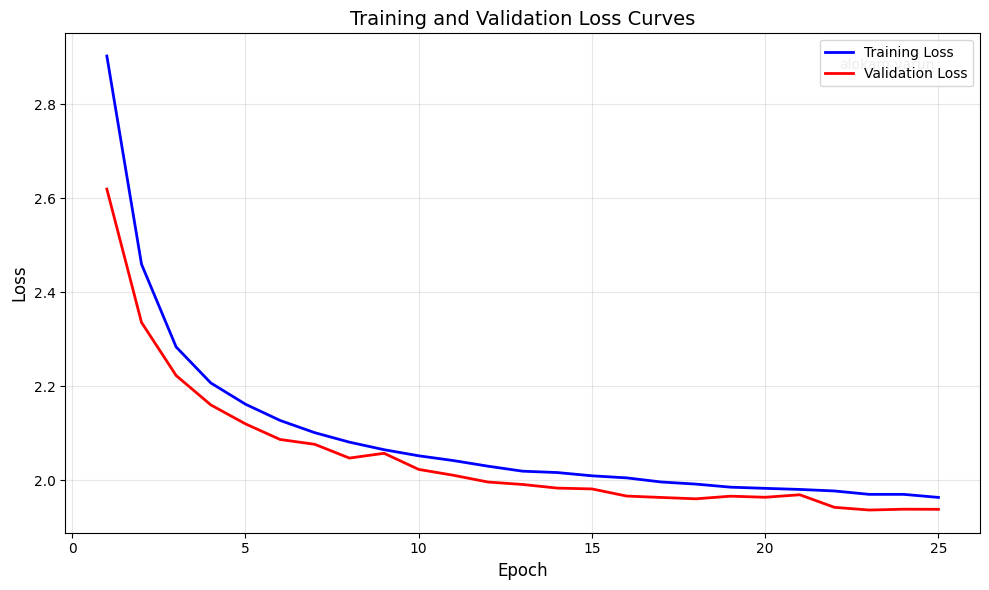

Generating colorization examples...


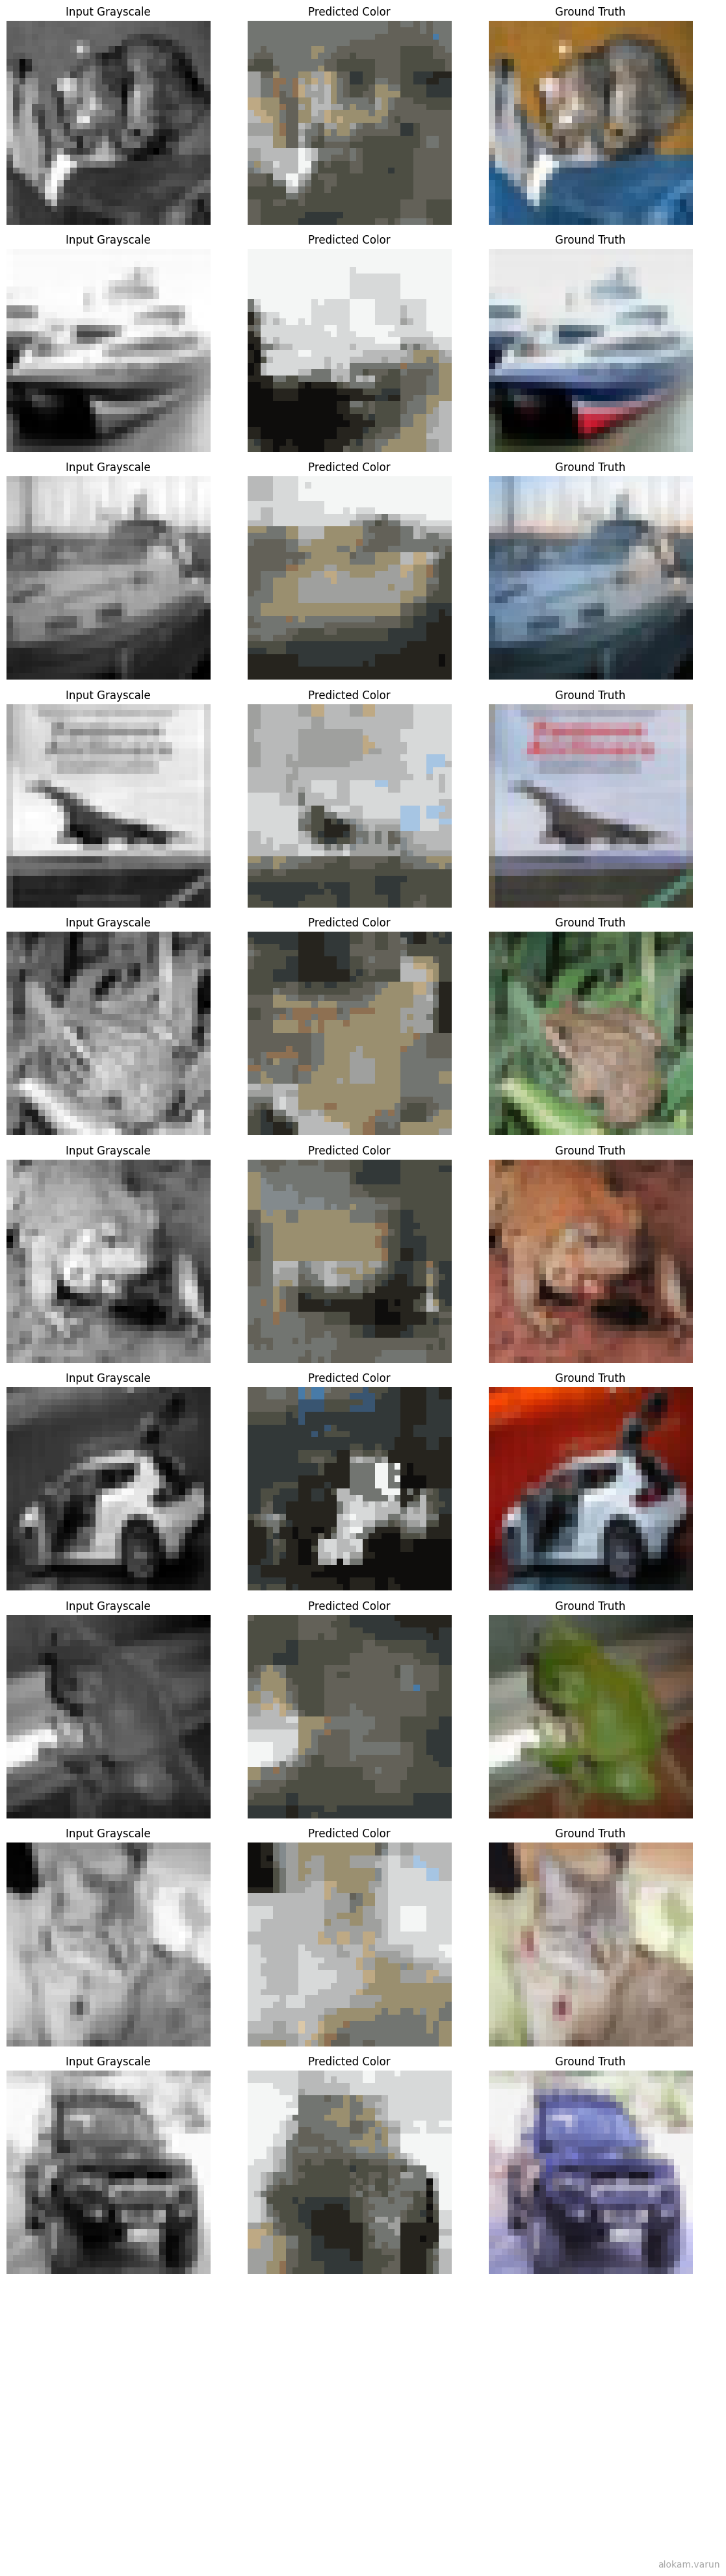

Test Loss: 1.9365

Run 9 completed!
Best Val Loss: 1.9364
Test Loss: 1.9365
Checkpoint: checkpoints_part2_sweep/run_9/best_model.pth



wandb: Agent Starting Run: yw2zykvf with config:
wandb: 	NC: 24
wandb: 	NF: 8
wandb: 	NIC: 1
wandb: 	batch_size: 128
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 25
wandb: 	optimizer: SGD



SWEEP RUN 10/20
Config: {'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 25, 'NF': 8, 'kernel_size': 5, 'optimizer': 'SGD', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 3.2499, Val Loss: 3.2375


Epoch 2/25 - Train Loss: 3.2298, Val Loss: 3.2197


Epoch 3/25 - Train Loss: 3.2129, Val Loss: 3.2033


Epoch 4/25 - Train Loss: 3.1982, Val Loss: 3.1893


Epoch 5/25 - Train Loss: 3.1852, Val Loss: 3.1782


Epoch 6/25 - Train Loss: 3.1733, Val Loss: 3.1669


Epoch 7/25 - Train Loss: 3.1622, Val Loss: 3.1553


Epoch 8/25 - Train Loss: 3.1513, Val Loss: 3.1448


Epoch 9/25 - Train Loss: 3.1403, Val Loss: 3.1338


Epoch 10/25 - Train Loss: 3.1290, Val Loss: 3.1223


Epoch 11/25 - Train Loss: 3.1171, Val Loss: 3.1100


Epoch 12/25 - Train Loss: 3.1046, Val Loss: 3.0974


Epoch 13/25 - Train Loss: 3.0916, Val Loss: 3.0845


Epoch 14/25 - Train Loss: 3.0783, Val Loss: 3.0708


Epoch 15/25 - Train Loss: 3.0646, Val Loss: 3.0569


Epoch 16/25 - Train Loss: 3.0507, Val Loss: 3.0423


Epoch 17/25 - Train Loss: 3.0363, Val Loss: 3.0282


Epoch 18/25 - Train Loss: 3.0215, Val Loss: 3.0127


Epoch 19/25 - Train Loss: 3.0059, Val Loss: 2.9973


Epoch 20/25 - Train Loss: 2.9899, Val Loss: 2.9802


Epoch 21/25 - Train Loss: 2.9730, Val Loss: 2.9639


Epoch 22/25 - Train Loss: 2.9556, Val Loss: 2.9450


Epoch 23/25 - Train Loss: 2.9380, Val Loss: 2.9278


Epoch 24/25 - Train Loss: 2.9203, Val Loss: 2.9093


Epoch 25/25 - Train Loss: 2.9028, Val Loss: 2.8921
Best val loss: 2.8921 at epoch 25


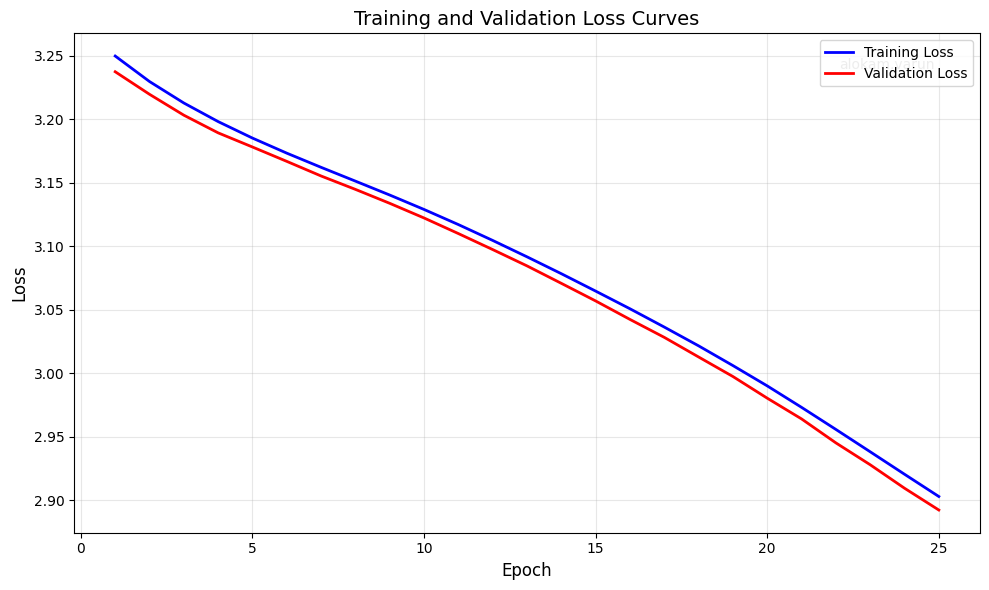

Generating colorization examples...


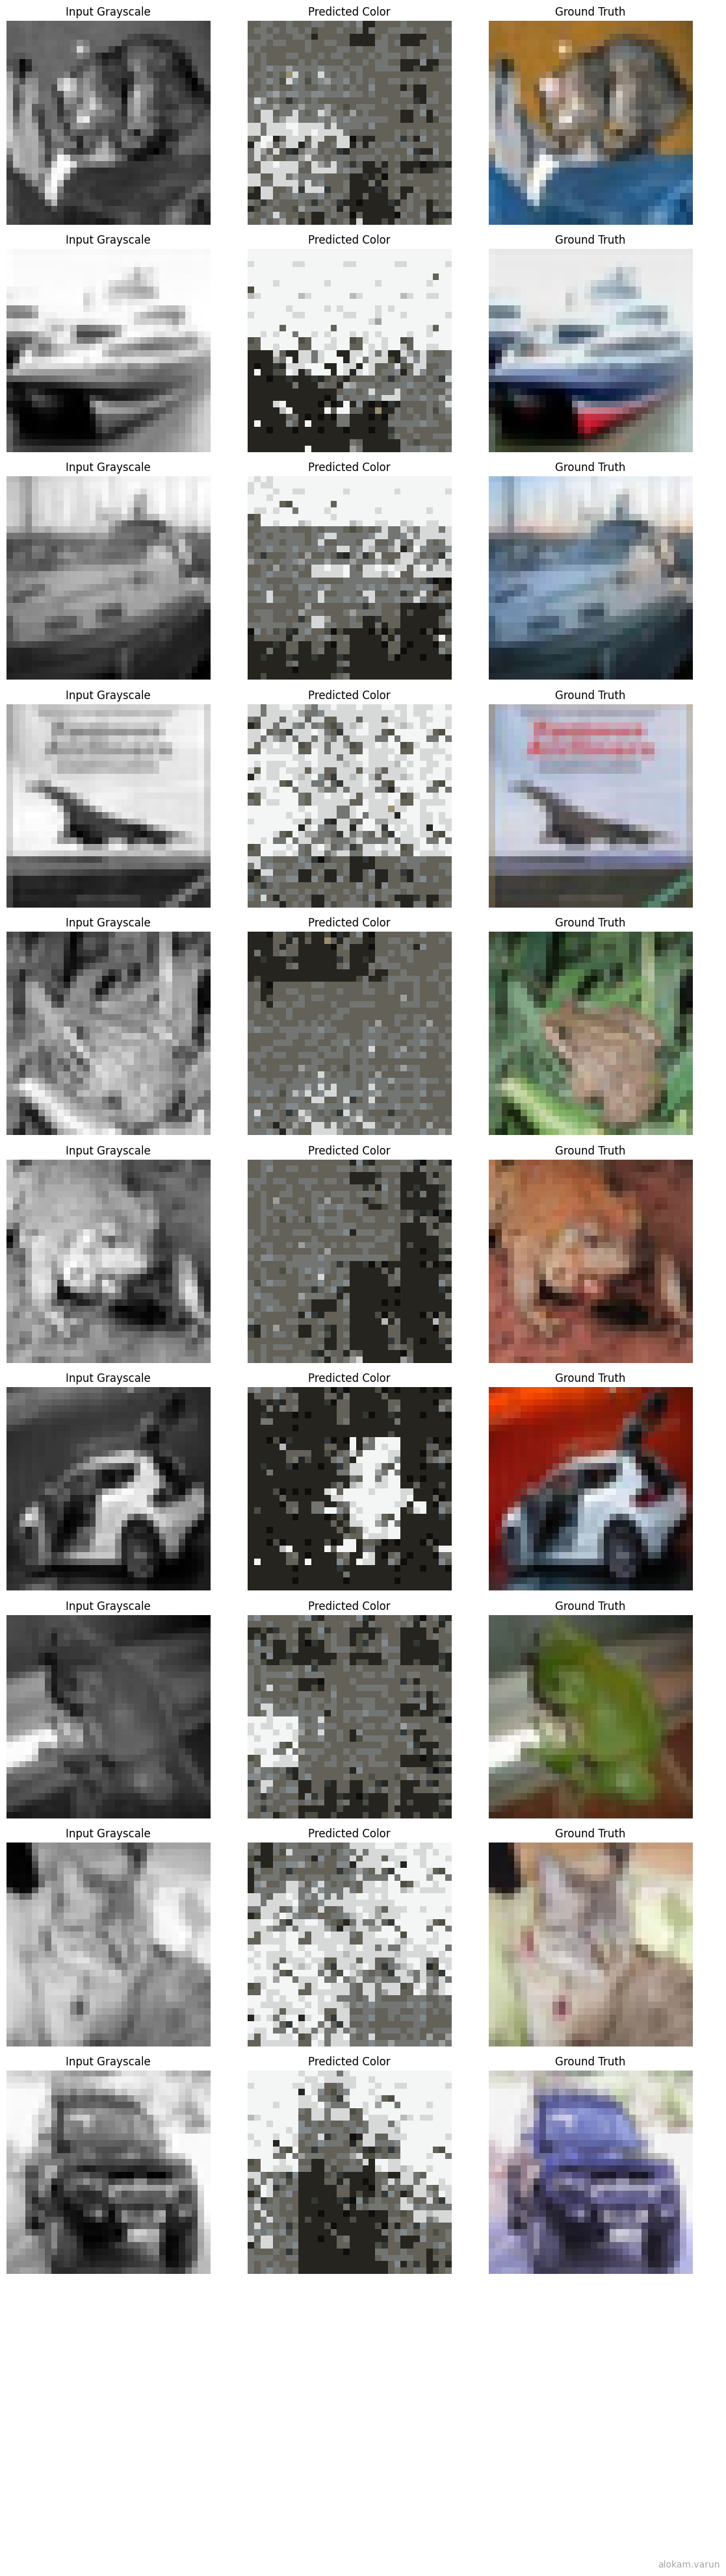

Test Loss: 2.8937

Run 10 completed!
Best Val Loss: 2.8921
Test Loss: 2.8937
Checkpoint: checkpoints_part2_sweep/run_10/best_model.pth



wandb: Agent Starting Run: cchlysni with config:
wandb: 	NC: 24
wandb: 	NF: 8
wandb: 	NIC: 1
wandb: 	batch_size: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 25
wandb: 	optimizer: Adam



SWEEP RUN 11/20
Config: {'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 25, 'NF': 8, 'kernel_size': 3, 'optimizer': 'Adam', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 2.4320, Val Loss: 2.1441


Epoch 2/25 - Train Loss: 2.0973, Val Loss: 2.0424


Epoch 3/25 - Train Loss: 2.0384, Val Loss: 2.0098


Epoch 4/25 - Train Loss: 2.0090, Val Loss: 1.9956


Epoch 5/25 - Train Loss: 1.9918, Val Loss: 2.0005


Epoch 6/25 - Train Loss: 1.9715, Val Loss: 1.9620


Epoch 7/25 - Train Loss: 1.9604, Val Loss: 1.9395


Epoch 8/25 - Train Loss: 1.9522, Val Loss: 1.9449


Epoch 9/25 - Train Loss: 1.9435, Val Loss: 1.9221


Epoch 10/25 - Train Loss: 1.9325, Val Loss: 1.9173


Epoch 11/25 - Train Loss: 1.9279, Val Loss: 1.9089


Epoch 12/25 - Train Loss: 1.9224, Val Loss: 1.9087


Epoch 13/25 - Train Loss: 1.9200, Val Loss: 1.9237


Epoch 14/25 - Train Loss: 1.9149, Val Loss: 1.8980


Epoch 15/25 - Train Loss: 1.9119, Val Loss: 1.8906


Epoch 16/25 - Train Loss: 1.9080, Val Loss: 1.8874


Epoch 17/25 - Train Loss: 1.9034, Val Loss: 1.8929


Epoch 18/25 - Train Loss: 1.9009, Val Loss: 1.8908


Epoch 19/25 - Train Loss: 1.9016, Val Loss: 1.8859


Epoch 20/25 - Train Loss: 1.8973, Val Loss: 1.8980


Epoch 21/25 - Train Loss: 1.8959, Val Loss: 1.8936


Epoch 22/25 - Train Loss: 1.8909, Val Loss: 1.8722


Epoch 23/25 - Train Loss: 1.8903, Val Loss: 1.8733


Epoch 24/25 - Train Loss: 1.8897, Val Loss: 1.8729


Epoch 25/25 - Train Loss: 1.8864, Val Loss: 1.8716
Best val loss: 1.8716 at epoch 25


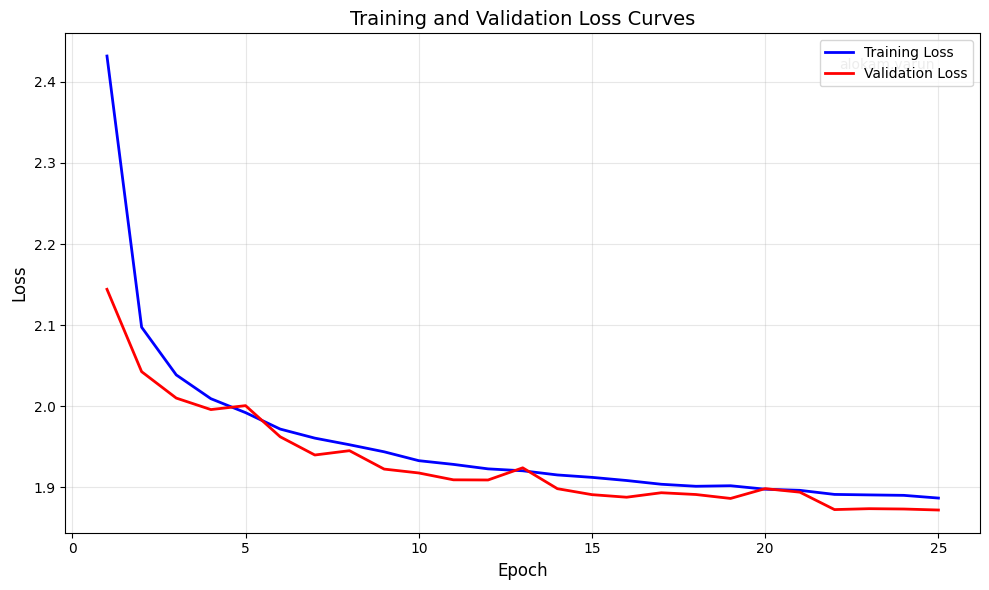

Generating colorization examples...


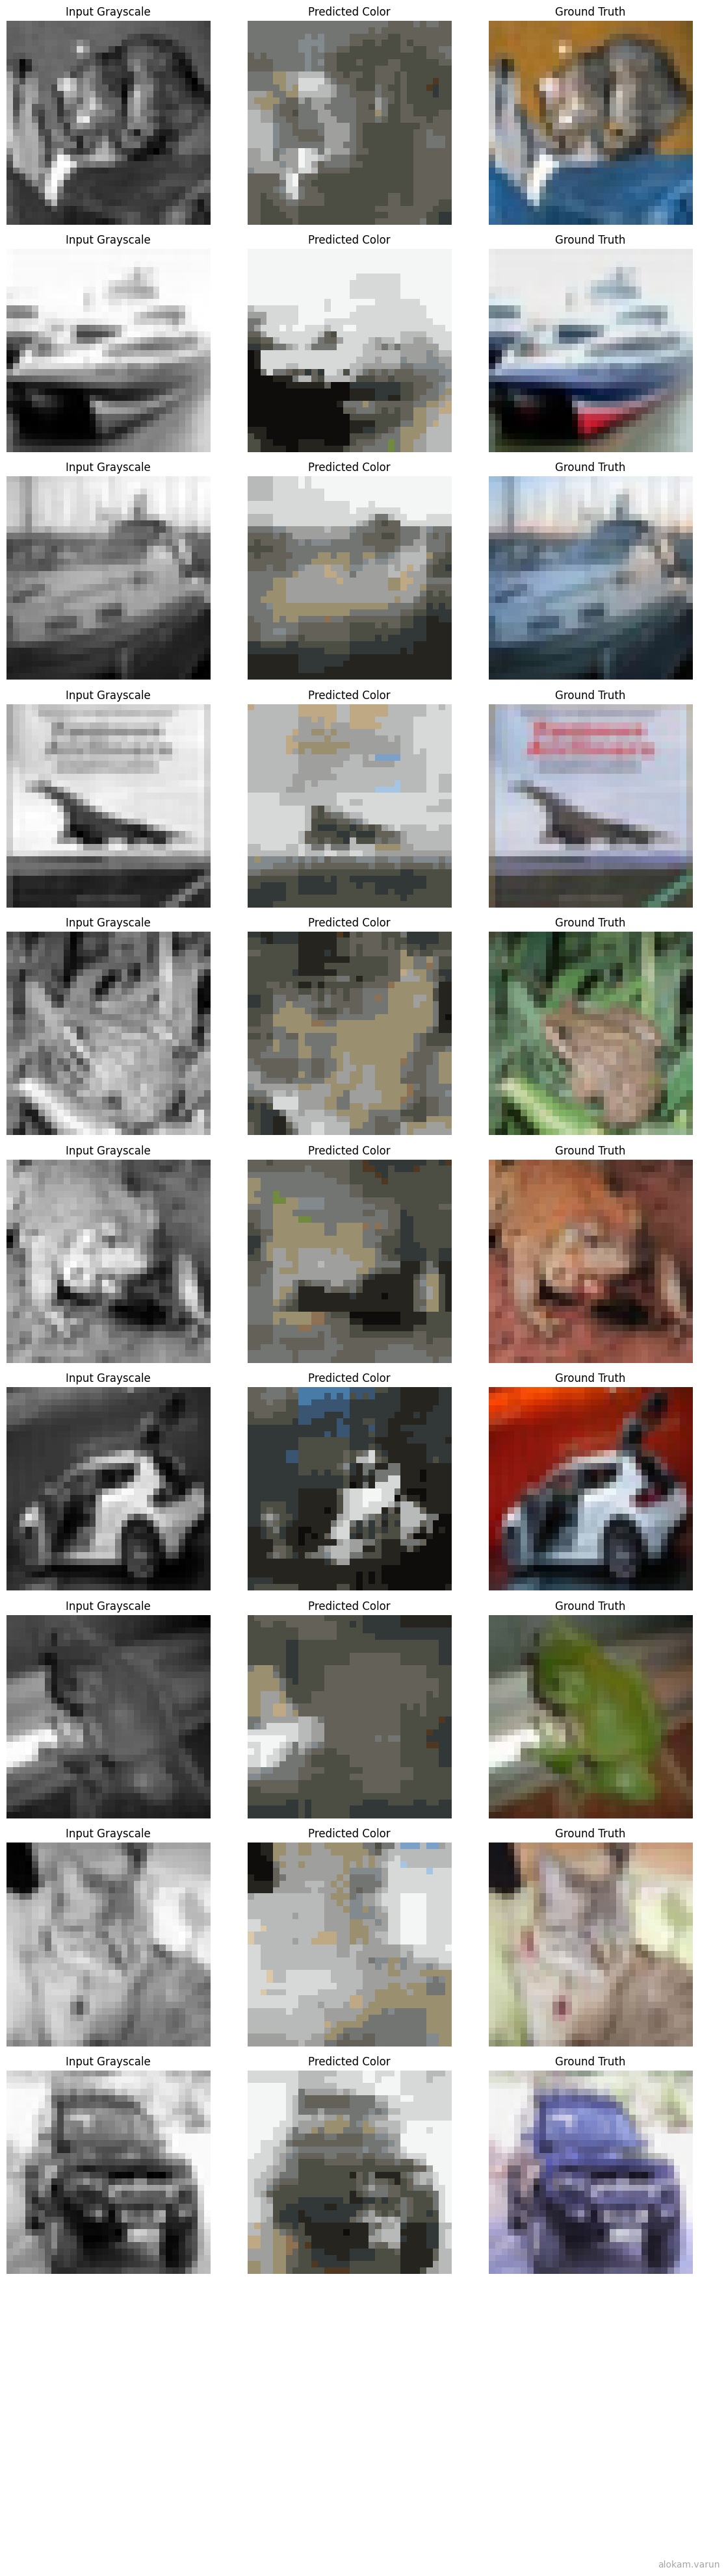

Test Loss: 1.8699

Run 11 completed!
Best Val Loss: 1.8716
Test Loss: 1.8699
Checkpoint: checkpoints_part2_sweep/run_11/best_model.pth



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6sphq1fw with config:
wandb: 	NC: 24
wandb: 	NF: 8
wandb: 	NIC: 1
wandb: 	batch_size: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 25
wandb: 	optimizer: Adam



SWEEP RUN 12/20
Config: {'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 25, 'NF': 8, 'kernel_size': 3, 'optimizer': 'Adam', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 3.0420, Val Loss: 2.8739


Epoch 2/25 - Train Loss: 2.7386, Val Loss: 2.6146


Epoch 3/25 - Train Loss: 2.5218, Val Loss: 2.4357


Epoch 4/25 - Train Loss: 2.3724, Val Loss: 2.3120


Epoch 5/25 - Train Loss: 2.2749, Val Loss: 2.2313


Epoch 6/25 - Train Loss: 2.2080, Val Loss: 2.1755


Epoch 7/25 - Train Loss: 2.1629, Val Loss: 2.1367


Epoch 8/25 - Train Loss: 2.1314, Val Loss: 2.1078


Epoch 9/25 - Train Loss: 2.1059, Val Loss: 2.0850


Epoch 10/25 - Train Loss: 2.0897, Val Loss: 2.0700


Epoch 11/25 - Train Loss: 2.0721, Val Loss: 2.0534


Epoch 12/25 - Train Loss: 2.0616, Val Loss: 2.0427


Epoch 13/25 - Train Loss: 2.0519, Val Loss: 2.0339


Epoch 14/25 - Train Loss: 2.0422, Val Loss: 2.0243


Epoch 15/25 - Train Loss: 2.0352, Val Loss: 2.0176


Epoch 16/25 - Train Loss: 2.0263, Val Loss: 2.0096


Epoch 17/25 - Train Loss: 2.0208, Val Loss: 2.0025


Epoch 18/25 - Train Loss: 2.0160, Val Loss: 1.9969


Epoch 19/25 - Train Loss: 2.0104, Val Loss: 1.9925


Epoch 20/25 - Train Loss: 2.0048, Val Loss: 1.9889


Epoch 21/25 - Train Loss: 2.0010, Val Loss: 1.9851


Epoch 22/25 - Train Loss: 1.9975, Val Loss: 1.9820


Epoch 23/25 - Train Loss: 1.9928, Val Loss: 1.9749


Epoch 24/25 - Train Loss: 1.9889, Val Loss: 1.9713


Epoch 25/25 - Train Loss: 1.9878, Val Loss: 1.9678
Best val loss: 1.9678 at epoch 25


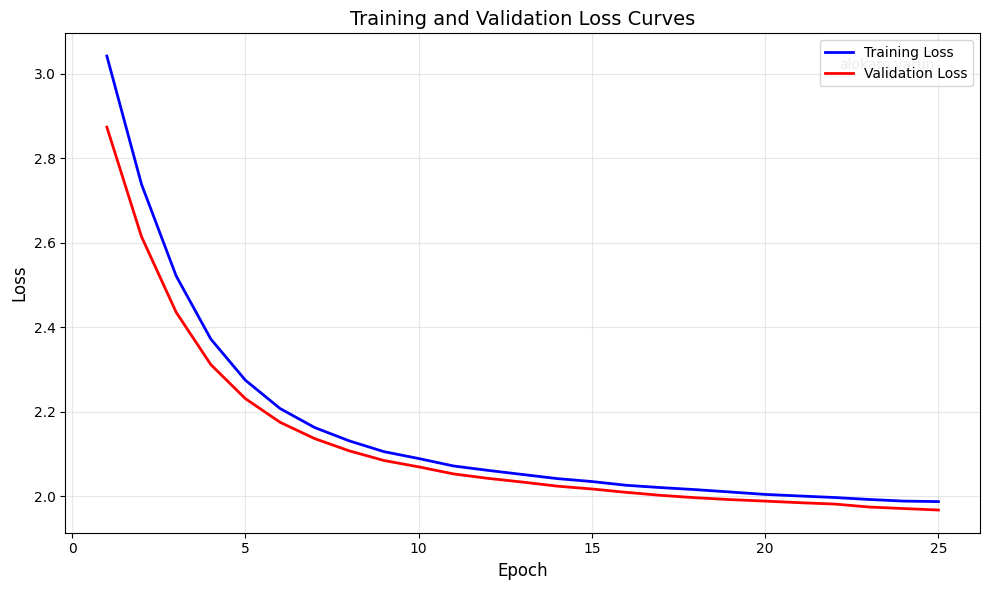

Generating colorization examples...


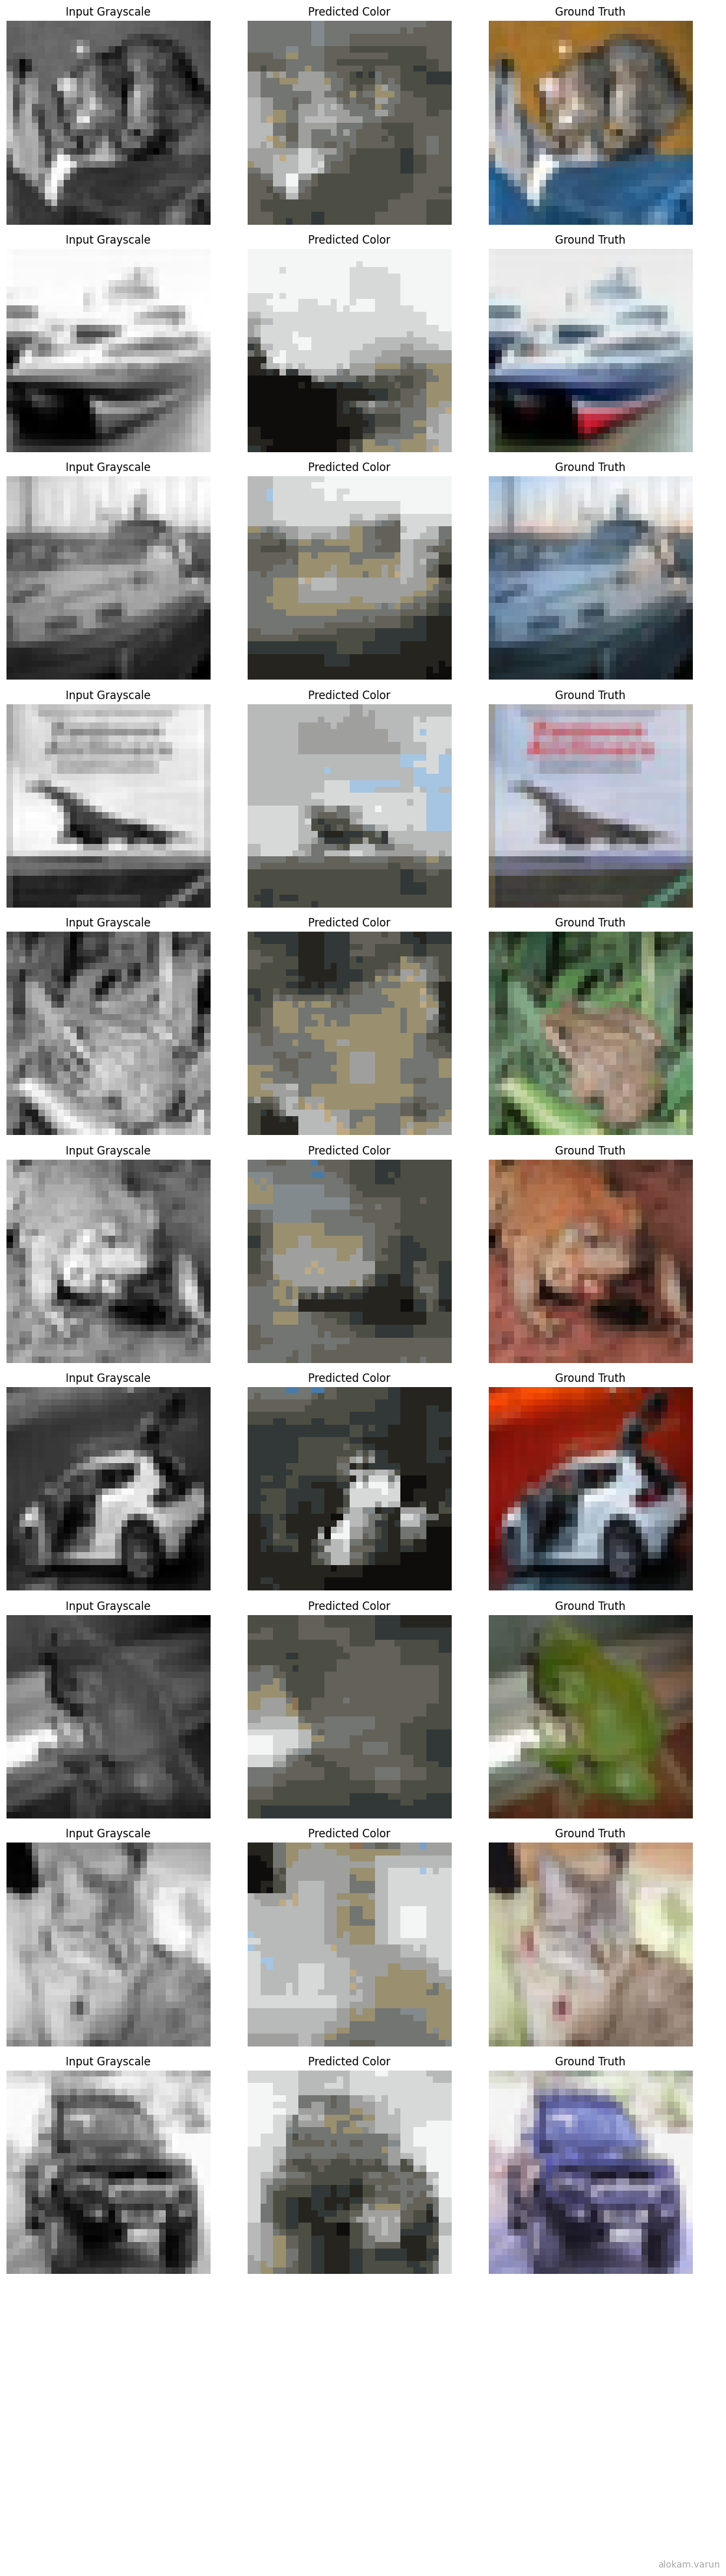

Test Loss: 1.9682

Run 12 completed!
Best Val Loss: 1.9678
Test Loss: 1.9682
Checkpoint: checkpoints_part2_sweep/run_12/best_model.pth



wandb: Agent Starting Run: ofwcpthd with config:
wandb: 	NC: 24
wandb: 	NF: 8
wandb: 	NIC: 1
wandb: 	batch_size: 64
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 25
wandb: 	optimizer: Adam



SWEEP RUN 13/20
Config: {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 25, 'NF': 8, 'kernel_size': 5, 'optimizer': 'Adam', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 2.9232, Val Loss: 2.6337


Epoch 2/25 - Train Loss: 2.4568, Val Loss: 2.3186


Epoch 3/25 - Train Loss: 2.2556, Val Loss: 2.1784


Epoch 4/25 - Train Loss: 2.1535, Val Loss: 2.0999


Epoch 5/25 - Train Loss: 2.0904, Val Loss: 2.0430


Epoch 6/25 - Train Loss: 2.0420, Val Loss: 2.0136


Epoch 7/25 - Train Loss: 2.0099, Val Loss: 1.9675


Epoch 8/25 - Train Loss: 1.9800, Val Loss: 1.9424


Epoch 9/25 - Train Loss: 1.9533, Val Loss: 1.9165


Epoch 10/25 - Train Loss: 1.9363, Val Loss: 1.9152


Epoch 11/25 - Train Loss: 1.9175, Val Loss: 1.8903


Epoch 12/25 - Train Loss: 1.9045, Val Loss: 1.8719


Epoch 13/25 - Train Loss: 1.8921, Val Loss: 1.8535


Epoch 14/25 - Train Loss: 1.8794, Val Loss: 1.8443


Epoch 15/25 - Train Loss: 1.8720, Val Loss: 1.8443


Epoch 16/25 - Train Loss: 1.8626, Val Loss: 1.8234


Epoch 17/25 - Train Loss: 1.8528, Val Loss: 1.8240


Epoch 18/25 - Train Loss: 1.8458, Val Loss: 1.8321


Epoch 19/25 - Train Loss: 1.8417, Val Loss: 1.8038


Epoch 20/25 - Train Loss: 1.8327, Val Loss: 1.8003


Epoch 21/25 - Train Loss: 1.8264, Val Loss: 1.7912


Epoch 22/25 - Train Loss: 1.8220, Val Loss: 1.7866


Epoch 23/25 - Train Loss: 1.8139, Val Loss: 1.7772


Epoch 24/25 - Train Loss: 1.8091, Val Loss: 1.7761


Epoch 25/25 - Train Loss: 1.8047, Val Loss: 1.7879
Best val loss: 1.7761 at epoch 24


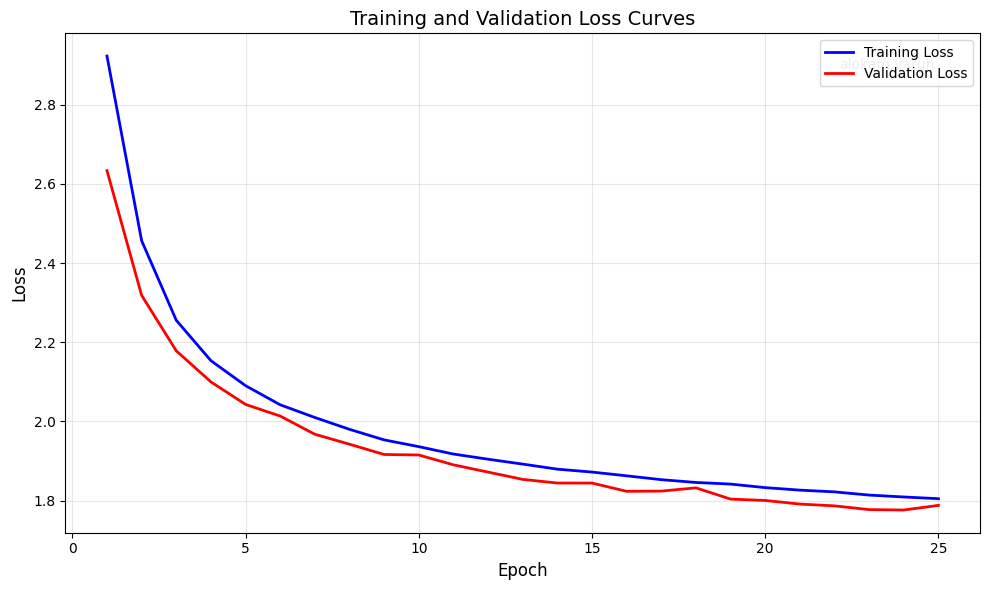

Generating colorization examples...


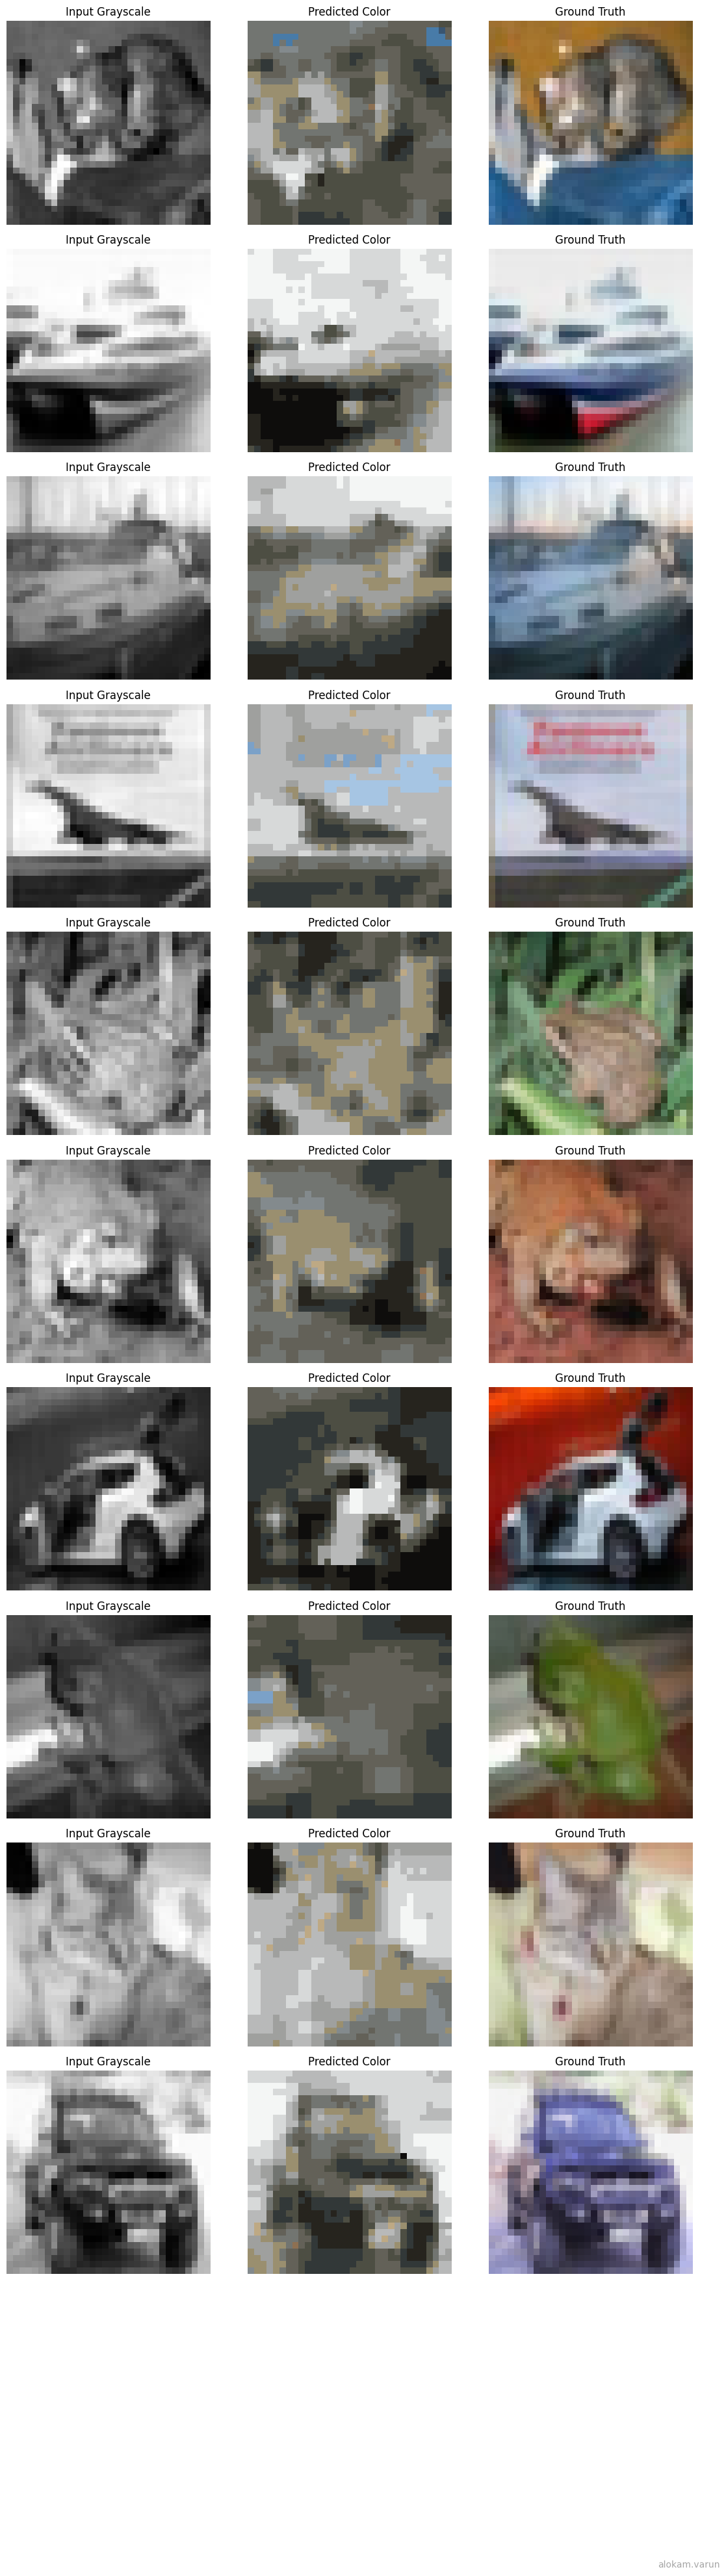

Test Loss: 1.7771

Run 13 completed!
Best Val Loss: 1.7761
Test Loss: 1.7771
Checkpoint: checkpoints_part2_sweep/run_13/best_model.pth



wandb: Agent Starting Run: ayq2st00 with config:
wandb: 	NC: 24
wandb: 	NF: 32
wandb: 	NIC: 1
wandb: 	batch_size: 128
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0003
wandb: 	num_epochs: 25
wandb: 	optimizer: Adam



SWEEP RUN 14/20
Config: {'learning_rate': 0.0003, 'batch_size': 128, 'num_epochs': 25, 'NF': 32, 'kernel_size': 5, 'optimizer': 'Adam', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 2.5861, Val Loss: 2.1978


Epoch 2/25 - Train Loss: 2.0282, Val Loss: 1.8984


Epoch 3/25 - Train Loss: 1.8422, Val Loss: 1.7705


Epoch 4/25 - Train Loss: 1.7433, Val Loss: 1.7076


Epoch 5/25 - Train Loss: 1.6794, Val Loss: 1.6452


Epoch 6/25 - Train Loss: 1.6329, Val Loss: 1.6233


Epoch 7/25 - Train Loss: 1.5987, Val Loss: 1.5809


Epoch 8/25 - Train Loss: 1.5760, Val Loss: 1.5638


Epoch 9/25 - Train Loss: 1.5602, Val Loss: 1.5321


Epoch 10/25 - Train Loss: 1.5410, Val Loss: 1.5483


Epoch 11/25 - Train Loss: 1.5273, Val Loss: 1.5820


Epoch 12/25 - Train Loss: 1.5131, Val Loss: 1.5379


Epoch 13/25 - Train Loss: 1.5063, Val Loss: 1.4883


Epoch 14/25 - Train Loss: 1.4999, Val Loss: 1.5013


Epoch 15/25 - Train Loss: 1.4895, Val Loss: 1.5297


Epoch 16/25 - Train Loss: 1.4825, Val Loss: 1.4734


Epoch 17/25 - Train Loss: 1.4760, Val Loss: 1.4624


Epoch 18/25 - Train Loss: 1.4752, Val Loss: 1.5377


Epoch 19/25 - Train Loss: 1.4691, Val Loss: 1.4654


Epoch 20/25 - Train Loss: 1.4619, Val Loss: 1.4602


Epoch 21/25 - Train Loss: 1.4598, Val Loss: 1.4831


Epoch 22/25 - Train Loss: 1.4512, Val Loss: 1.4652


Epoch 23/25 - Train Loss: 1.4469, Val Loss: 1.4340


Epoch 24/25 - Train Loss: 1.4463, Val Loss: 1.4694


Epoch 25/25 - Train Loss: 1.4448, Val Loss: 1.4606
Best val loss: 1.4340 at epoch 23


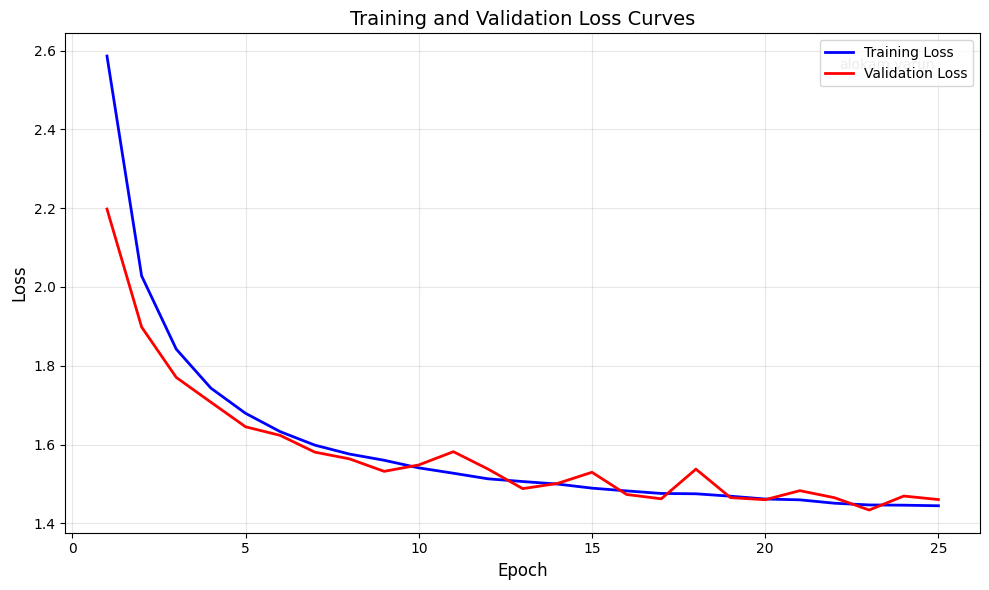

Generating colorization examples...


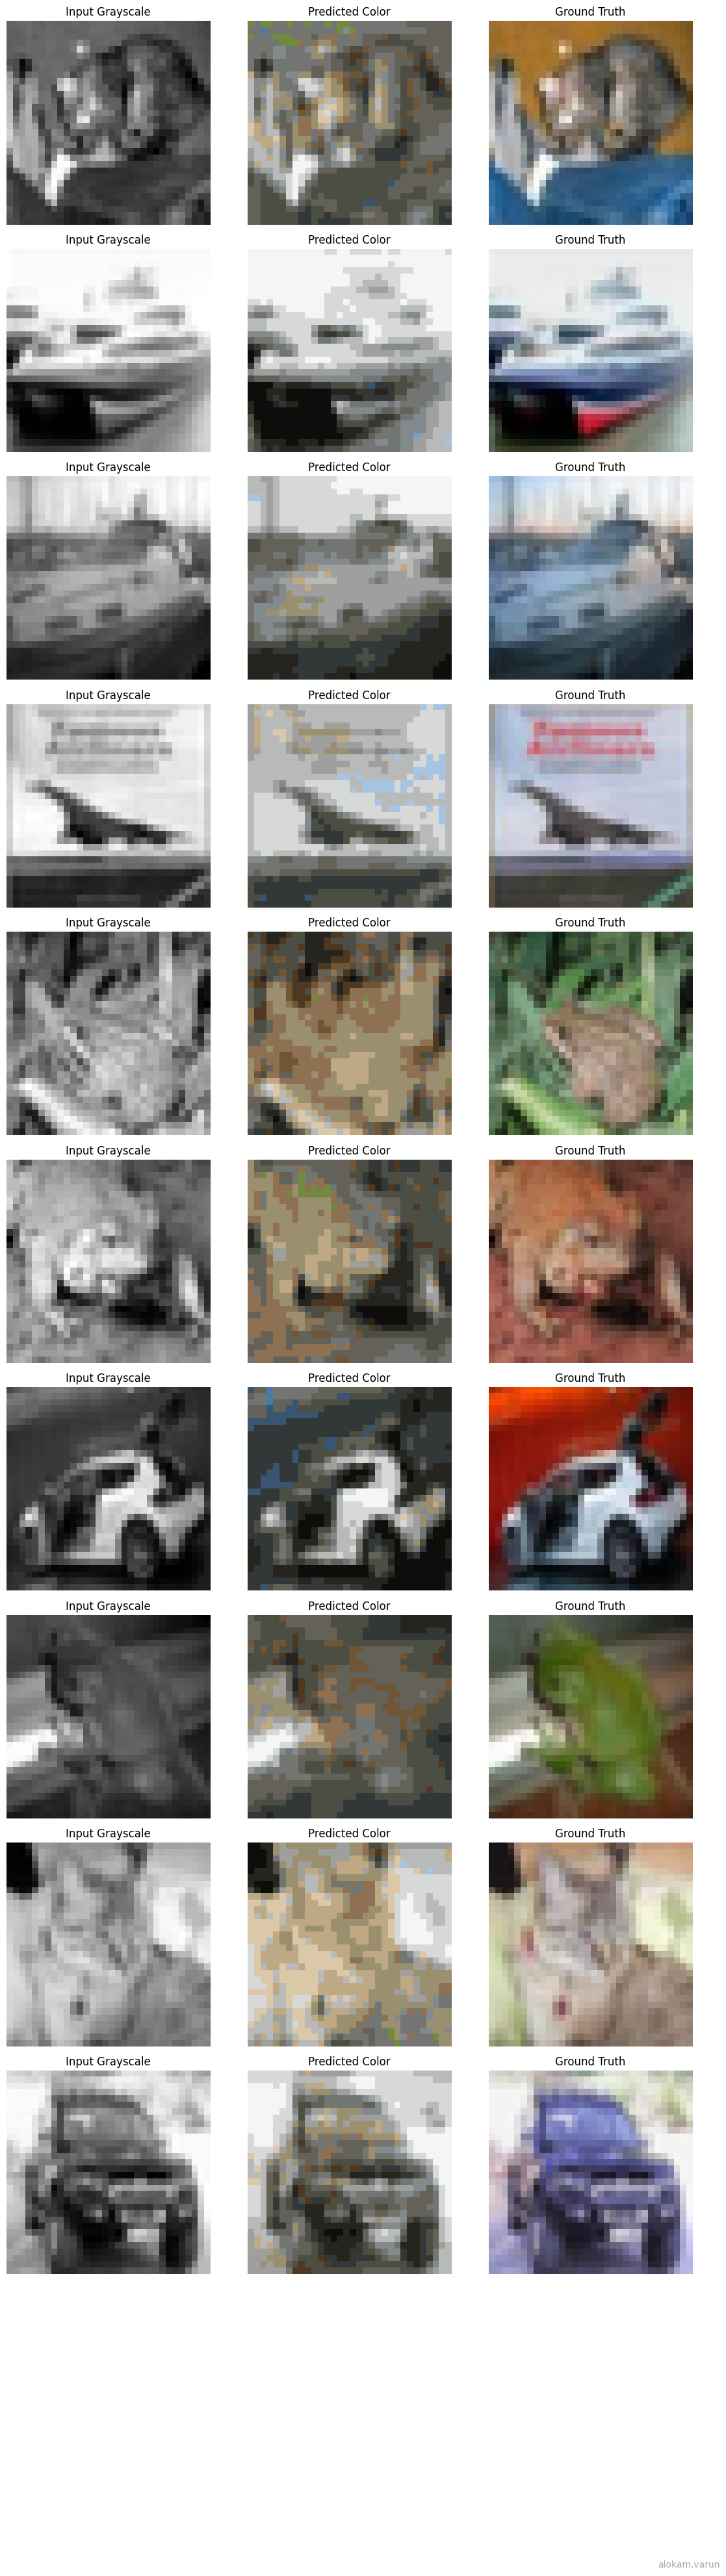

Test Loss: 1.4284

Run 14 completed!
Best Val Loss: 1.4340
Test Loss: 1.4284
Checkpoint: checkpoints_part2_sweep/run_14/best_model.pth



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2q3nb7vr with config:
wandb: 	NC: 24
wandb: 	NF: 8
wandb: 	NIC: 1
wandb: 	batch_size: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 25
wandb: 	optimizer: Adam



SWEEP RUN 15/20
Config: {'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 25, 'NF': 8, 'kernel_size': 3, 'optimizer': 'Adam', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 2.4359, Val Loss: 2.1342


Epoch 2/25 - Train Loss: 2.0848, Val Loss: 2.0364


Epoch 3/25 - Train Loss: 2.0300, Val Loss: 1.9998


Epoch 4/25 - Train Loss: 2.0062, Val Loss: 1.9715


Epoch 5/25 - Train Loss: 1.9820, Val Loss: 1.9890


Epoch 6/25 - Train Loss: 1.9671, Val Loss: 1.9572


Epoch 7/25 - Train Loss: 1.9616, Val Loss: 1.9365


Epoch 8/25 - Train Loss: 1.9534, Val Loss: 1.9275


Epoch 9/25 - Train Loss: 1.9441, Val Loss: 1.9295


Epoch 10/25 - Train Loss: 1.9378, Val Loss: 1.9248


Epoch 11/25 - Train Loss: 1.9340, Val Loss: 1.9239


Epoch 12/25 - Train Loss: 1.9283, Val Loss: 1.9131


Epoch 13/25 - Train Loss: 1.9217, Val Loss: 1.9090


Epoch 14/25 - Train Loss: 1.9191, Val Loss: 1.9136


Epoch 15/25 - Train Loss: 1.9143, Val Loss: 1.9007


Epoch 17/25 - Train Loss: 1.9093, Val Loss: 1.8864


Epoch 18/25 - Train Loss: 1.9052, Val Loss: 1.8909


Epoch 19/25 - Train Loss: 1.9047, Val Loss: 1.8877


Epoch 20/25 - Train Loss: 1.9021, Val Loss: 1.8852


Epoch 21/25 - Train Loss: 1.8993, Val Loss: 1.8847


Epoch 22/25 - Train Loss: 1.8975, Val Loss: 1.8822


Epoch 23/25 - Train Loss: 1.8948, Val Loss: 1.8763


Epoch 24/25 - Train Loss: 1.8951, Val Loss: 1.8843


Epoch 25/25 - Train Loss: 1.8902, Val Loss: 1.8820
Best val loss: 1.8763 at epoch 23


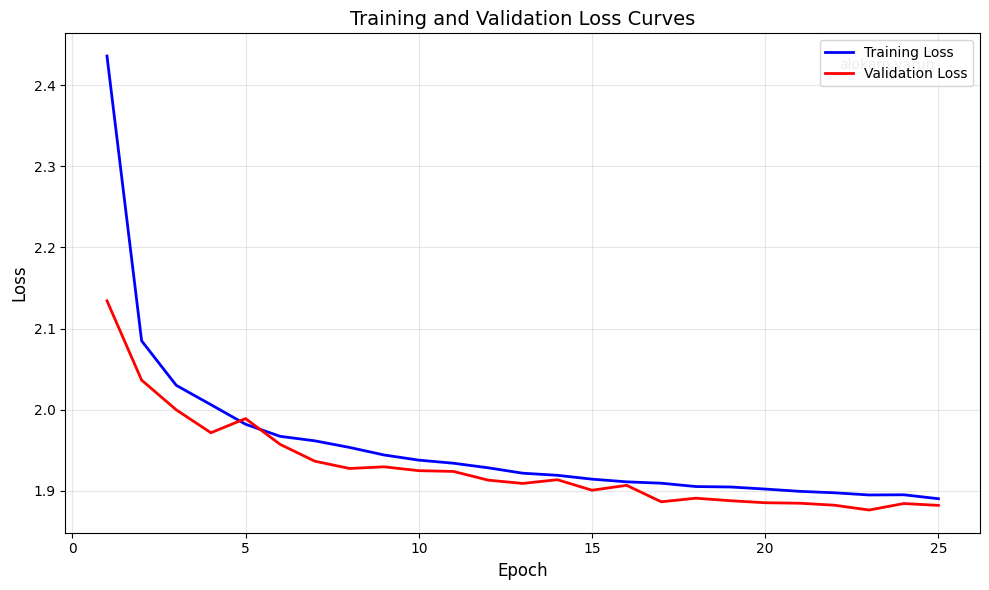

Generating colorization examples...


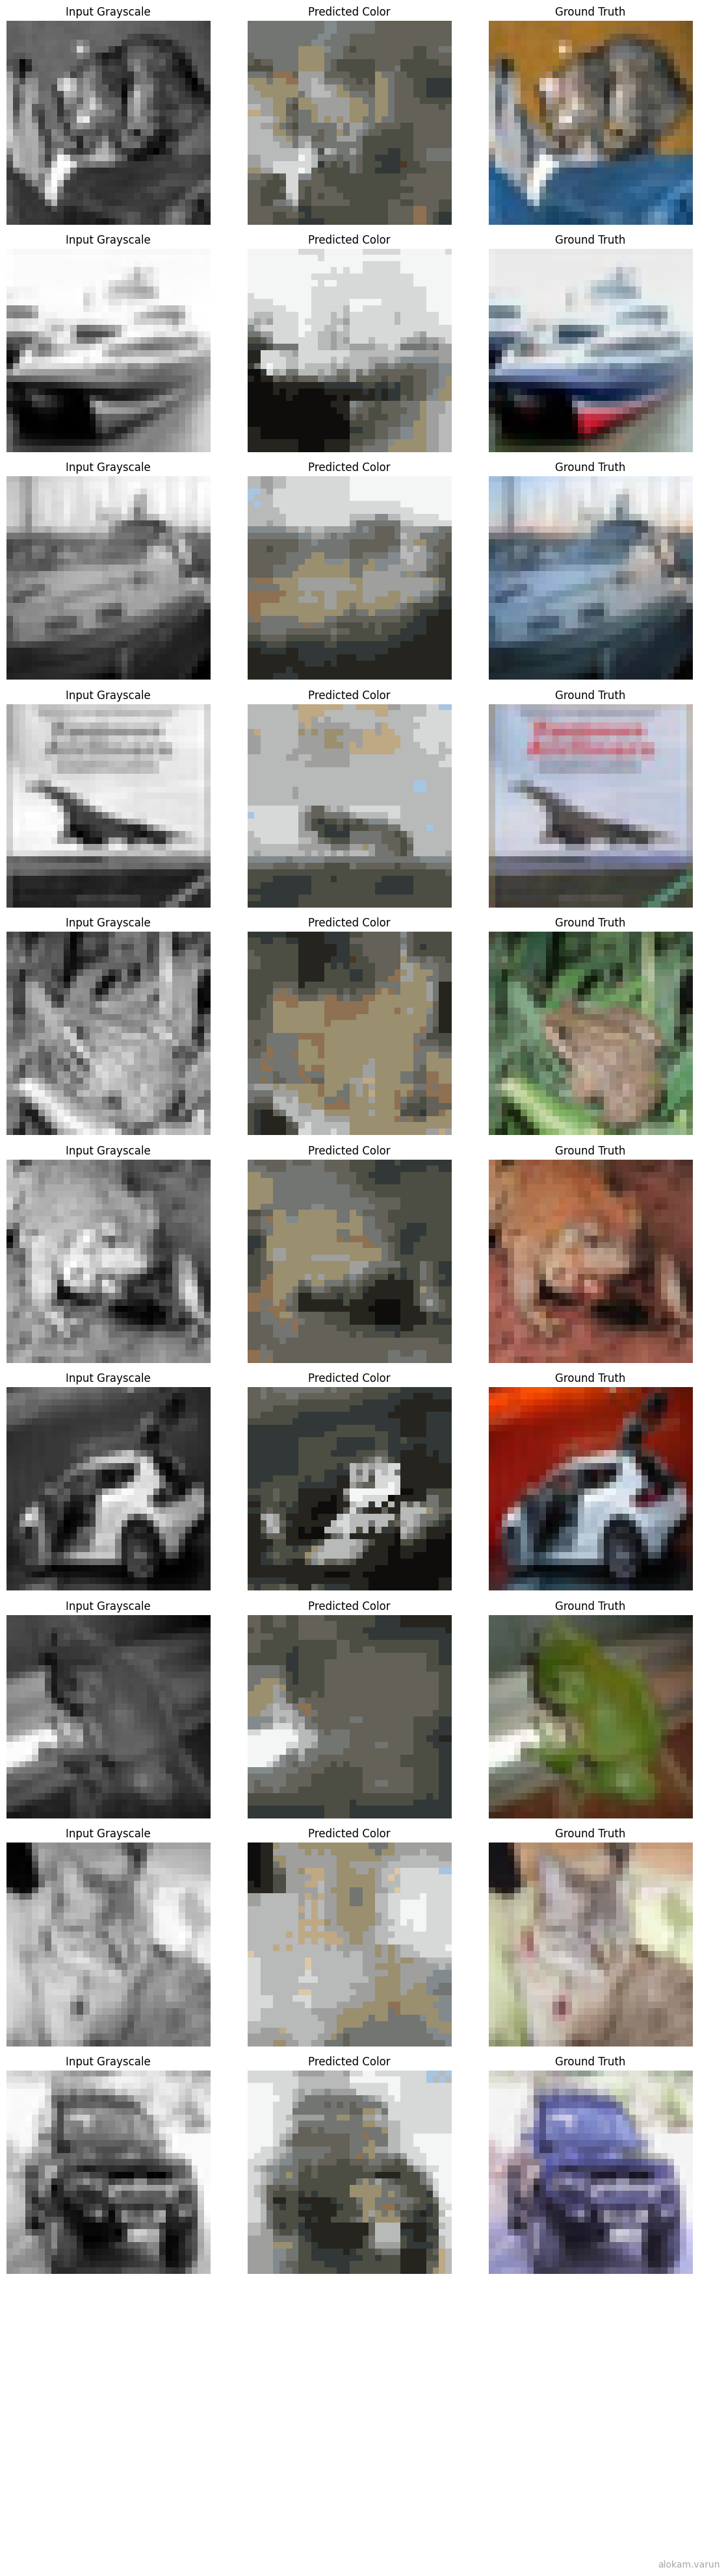

Test Loss: 1.8754

Run 15 completed!
Best Val Loss: 1.8763
Test Loss: 1.8754
Checkpoint: checkpoints_part2_sweep/run_15/best_model.pth



wandb: Agent Starting Run: tsngrwa7 with config:
wandb: 	NC: 24
wandb: 	NF: 8
wandb: 	NIC: 1
wandb: 	batch_size: 32
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.003
wandb: 	num_epochs: 25
wandb: 	optimizer: Adam



SWEEP RUN 16/20
Config: {'learning_rate': 0.003, 'batch_size': 32, 'num_epochs': 25, 'NF': 8, 'kernel_size': 5, 'optimizer': 'Adam', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 2.0742, Val Loss: 1.9600


Epoch 2/25 - Train Loss: 1.8845, Val Loss: 1.8075


Epoch 3/25 - Train Loss: 1.8457, Val Loss: 1.8130


Epoch 4/25 - Train Loss: 1.8126, Val Loss: 1.8487


Epoch 5/25 - Train Loss: 1.8005, Val Loss: 1.7387


Epoch 6/25 - Train Loss: 1.7887, Val Loss: 1.7779


Epoch 7/25 - Train Loss: 1.7714, Val Loss: 1.8076


Epoch 8/25 - Train Loss: 1.7654, Val Loss: 1.7233


Epoch 9/25 - Train Loss: 1.7526, Val Loss: 1.7301


Epoch 10/25 - Train Loss: 1.7461, Val Loss: 1.7280


Epoch 11/25 - Train Loss: 1.7418, Val Loss: 1.6843


Epoch 12/25 - Train Loss: 1.7357, Val Loss: 1.6794


Epoch 13/25 - Train Loss: 1.7291, Val Loss: 1.7111


Epoch 14/25 - Train Loss: 1.7236, Val Loss: 1.6750


Epoch 15/25 - Train Loss: 1.7208, Val Loss: 1.6862


Epoch 16/25 - Train Loss: 1.7211, Val Loss: 1.6908


Epoch 17/25 - Train Loss: 1.7215, Val Loss: 1.6937


Epoch 18/25 - Train Loss: 1.7103, Val Loss: 1.6899


Epoch 19/25 - Train Loss: 1.7098, Val Loss: 1.7336


Epoch 20/25 - Train Loss: 1.7114, Val Loss: 1.7018


Epoch 21/25 - Train Loss: 1.7061, Val Loss: 1.7048


Epoch 22/25 - Train Loss: 1.7001, Val Loss: 1.6978


Epoch 23/25 - Train Loss: 1.6965, Val Loss: 1.6497


Epoch 24/25 - Train Loss: 1.6976, Val Loss: 1.7706


Epoch 25/25 - Train Loss: 1.6970, Val Loss: 1.7001
Best val loss: 1.6497 at epoch 23


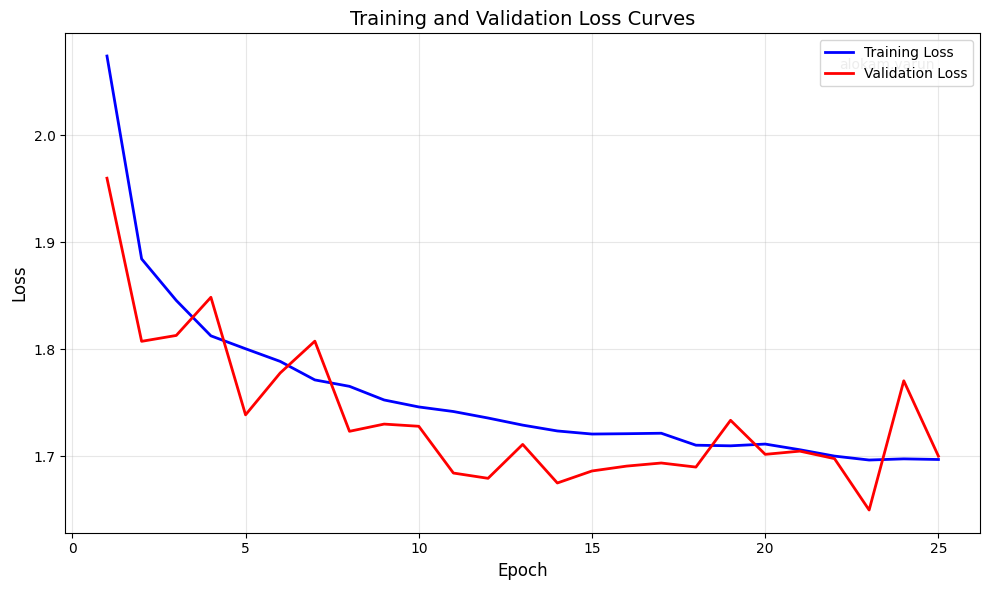

Generating colorization examples...


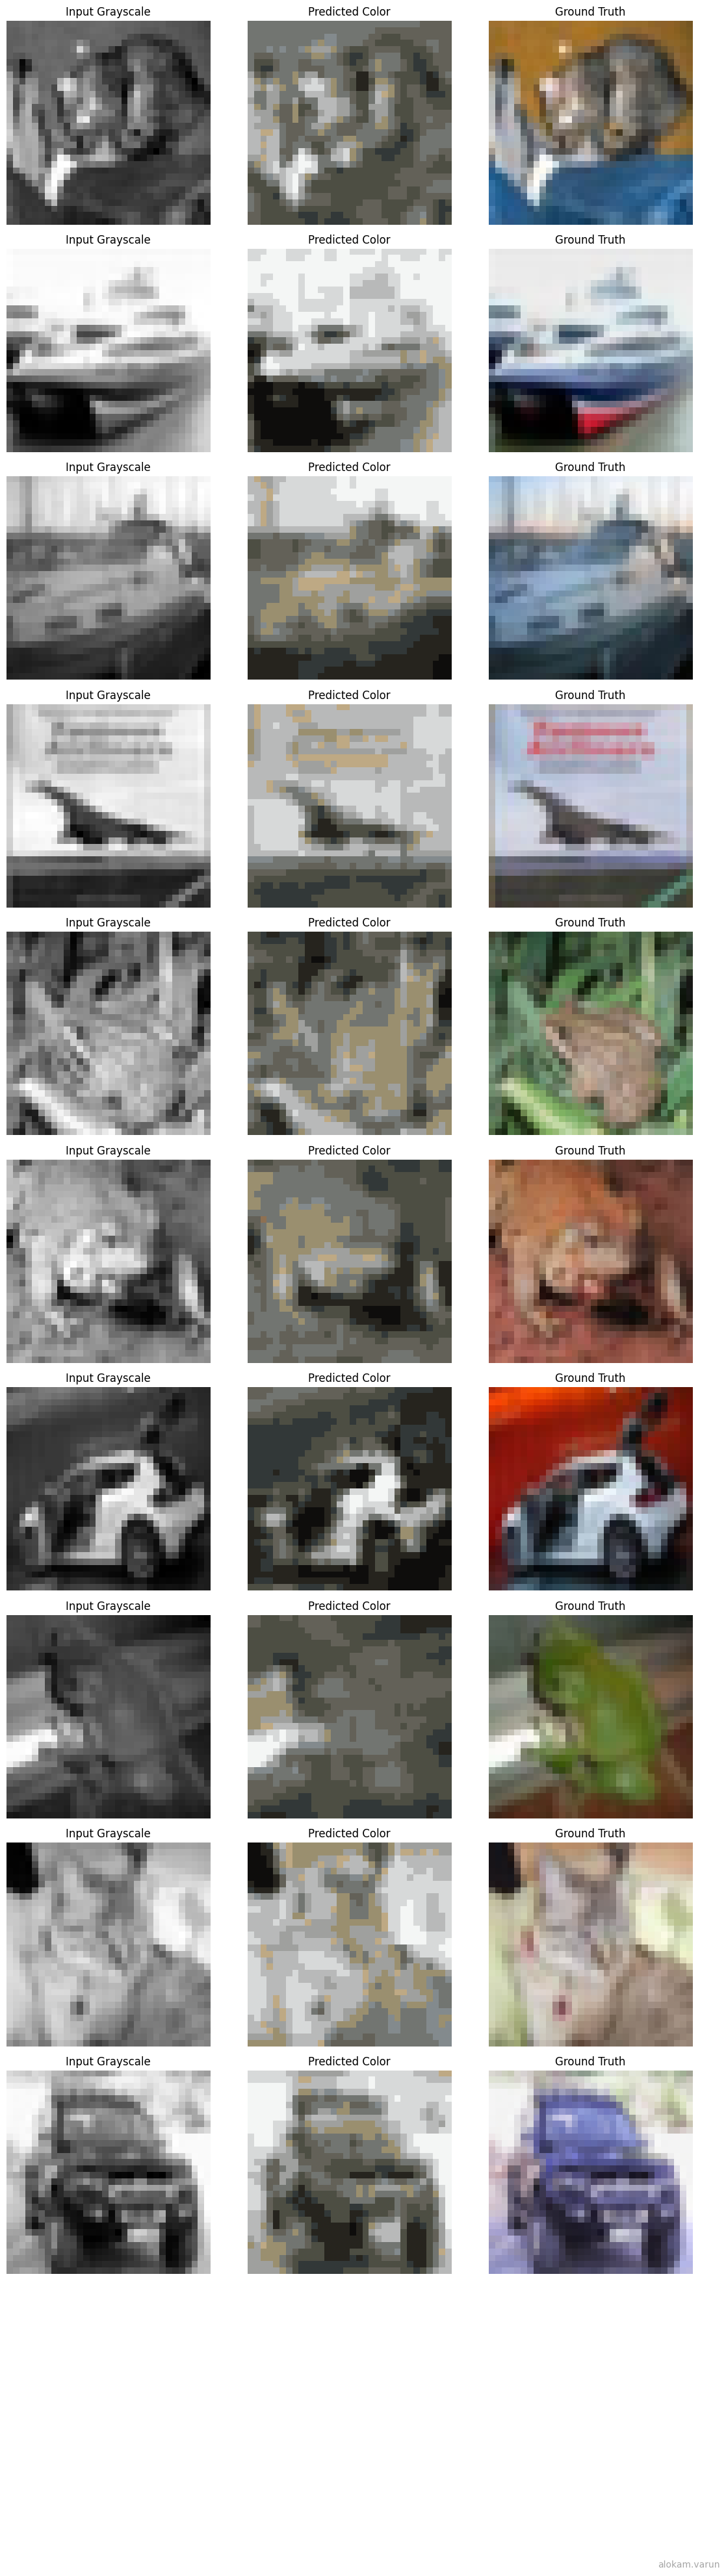

Test Loss: 1.6478

Run 16 completed!
Best Val Loss: 1.6497
Test Loss: 1.6478
Checkpoint: checkpoints_part2_sweep/run_16/best_model.pth



wandb: Agent Starting Run: nioml7pl with config:
wandb: 	NC: 24
wandb: 	NF: 32
wandb: 	NIC: 1
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 25
wandb: 	optimizer: SGD



SWEEP RUN 17/20
Config: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 25, 'NF': 32, 'kernel_size': 3, 'optimizer': 'SGD', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 3.0592, Val Loss: 2.8528


Epoch 2/25 - Train Loss: 2.6875, Val Loss: 2.5403


Epoch 3/25 - Train Loss: 2.4420, Val Loss: 2.3504


Epoch 4/25 - Train Loss: 2.2987, Val Loss: 2.2387


Epoch 5/25 - Train Loss: 2.2128, Val Loss: 2.1653


Epoch 6/25 - Train Loss: 2.1549, Val Loss: 2.1174


Epoch 7/25 - Train Loss: 2.1152, Val Loss: 2.0782


Epoch 8/25 - Train Loss: 2.0820, Val Loss: 2.0516


Epoch 9/25 - Train Loss: 2.0567, Val Loss: 2.0249


Epoch 10/25 - Train Loss: 2.0335, Val Loss: 1.9975


Epoch 11/25 - Train Loss: 2.0140, Val Loss: 1.9809


Epoch 12/25 - Train Loss: 1.9975, Val Loss: 1.9694


Epoch 13/25 - Train Loss: 1.9851, Val Loss: 1.9476


Epoch 14/25 - Train Loss: 1.9692, Val Loss: 1.9359


Epoch 15/25 - Train Loss: 1.9566, Val Loss: 1.9229


Epoch 16/25 - Train Loss: 1.9465, Val Loss: 1.9122


Epoch 17/25 - Train Loss: 1.9378, Val Loss: 1.9029


Epoch 18/25 - Train Loss: 1.9257, Val Loss: 1.8925


Epoch 19/25 - Train Loss: 1.9149, Val Loss: 1.8827


Epoch 20/25 - Train Loss: 1.9072, Val Loss: 1.8832


Epoch 21/25 - Train Loss: 1.8993, Val Loss: 1.8724


Epoch 22/25 - Train Loss: 1.8910, Val Loss: 1.8559


Epoch 23/25 - Train Loss: 1.8847, Val Loss: 1.8597


Epoch 24/25 - Train Loss: 1.8791, Val Loss: 1.8406


Epoch 25/25 - Train Loss: 1.8726, Val Loss: 1.8346
Best val loss: 1.8346 at epoch 25


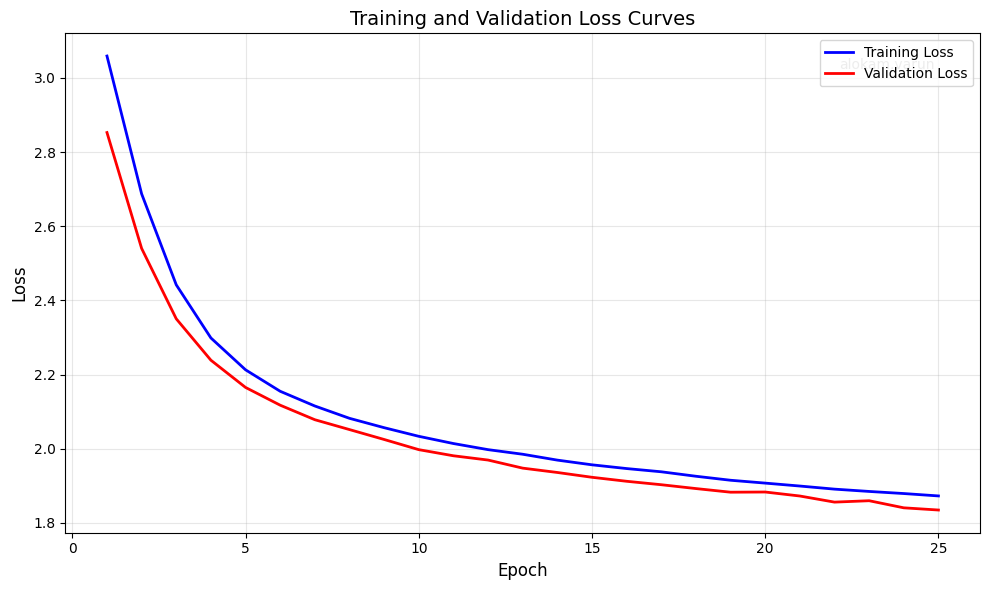

Generating colorization examples...


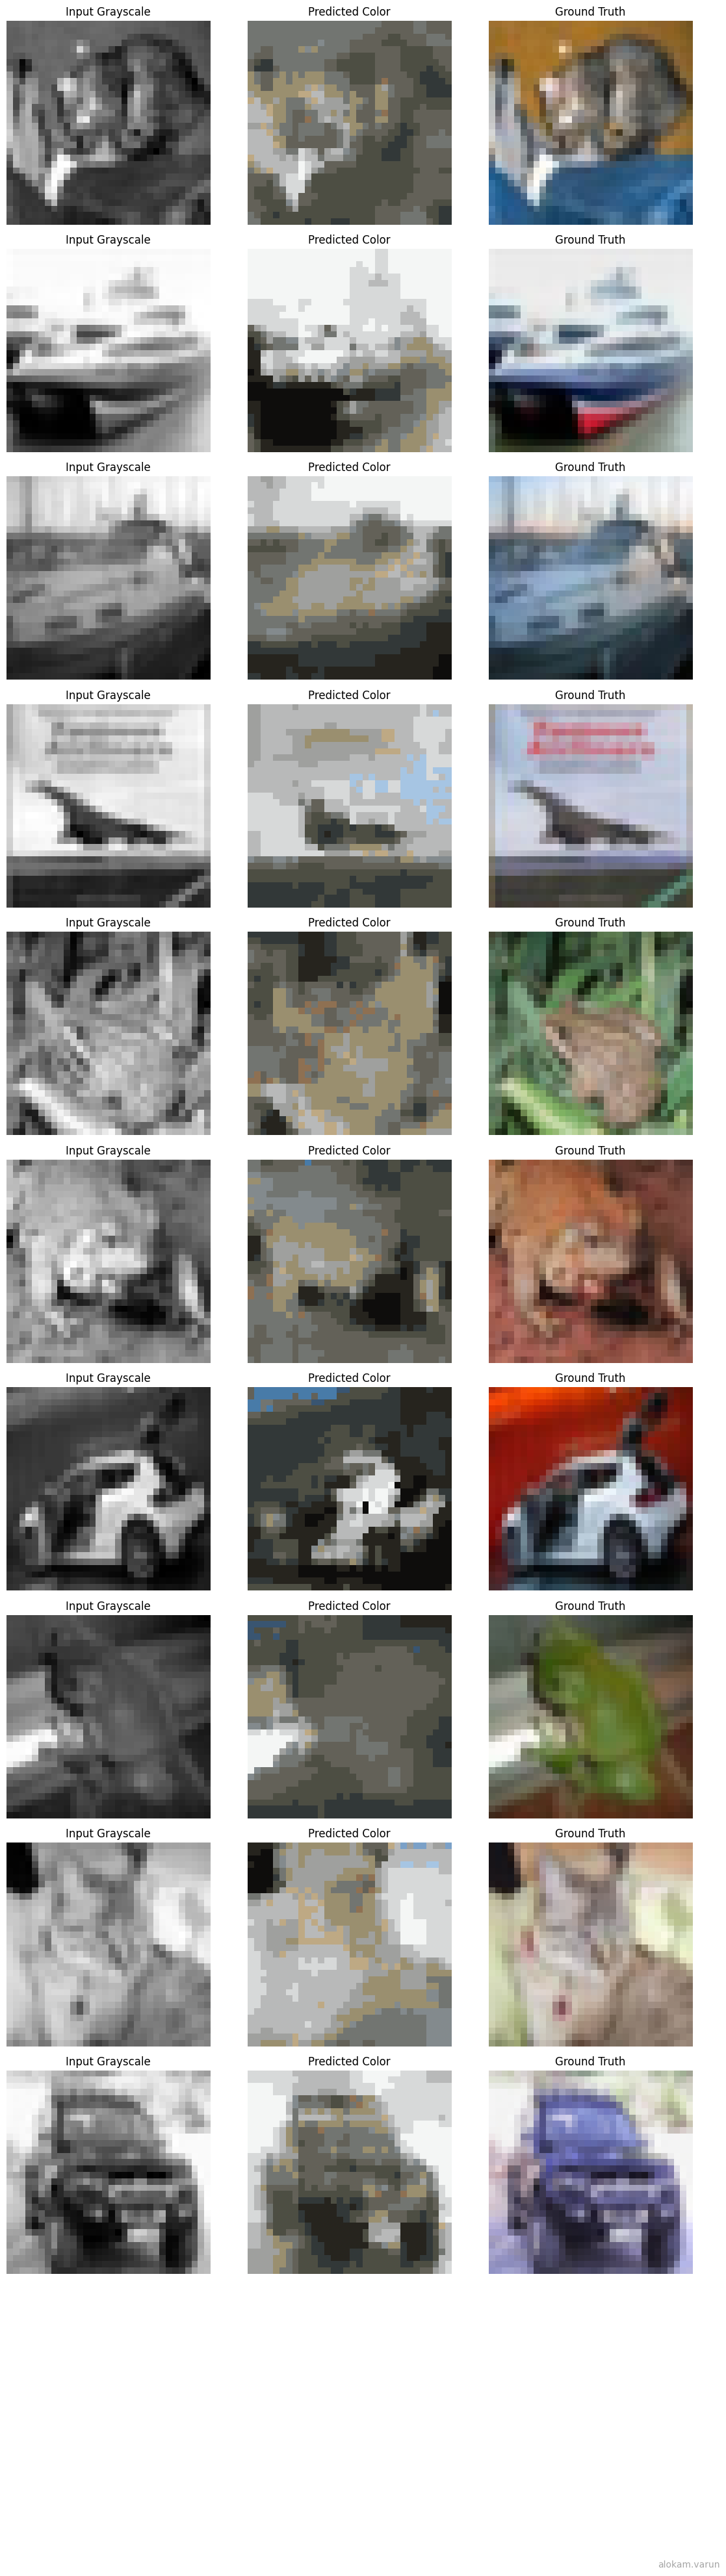

Test Loss: 1.8340

Run 17 completed!
Best Val Loss: 1.8346
Test Loss: 1.8340
Checkpoint: checkpoints_part2_sweep/run_17/best_model.pth



wandb: Agent Starting Run: 38iwx8sd with config:
wandb: 	NC: 24
wandb: 	NF: 32
wandb: 	NIC: 1
wandb: 	batch_size: 128
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 25
wandb: 	optimizer: SGD



SWEEP RUN 18/20
Config: {'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 25, 'NF': 32, 'kernel_size': 5, 'optimizer': 'SGD', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 3.1008, Val Loss: 2.9820


Epoch 2/25 - Train Loss: 2.9102, Val Loss: 2.8398


Epoch 3/25 - Train Loss: 2.7557, Val Loss: 2.6692


Epoch 4/25 - Train Loss: 2.5945, Val Loss: 2.5253


Epoch 5/25 - Train Loss: 2.4687, Val Loss: 2.4169


Epoch 6/25 - Train Loss: 2.3742, Val Loss: 2.3316


Epoch 7/25 - Train Loss: 2.3013, Val Loss: 2.2677


Epoch 8/25 - Train Loss: 2.2432, Val Loss: 2.2129


Epoch 9/25 - Train Loss: 2.1950, Val Loss: 2.1680


Epoch 10/25 - Train Loss: 2.1545, Val Loss: 2.1289


Epoch 11/25 - Train Loss: 2.1187, Val Loss: 2.0962


Epoch 12/25 - Train Loss: 2.0858, Val Loss: 2.0650


Epoch 13/25 - Train Loss: 2.0595, Val Loss: 2.0369


Epoch 14/25 - Train Loss: 2.0331, Val Loss: 2.0141


Epoch 15/25 - Train Loss: 2.0129, Val Loss: 1.9909


Epoch 16/25 - Train Loss: 1.9920, Val Loss: 1.9710


Epoch 17/25 - Train Loss: 1.9721, Val Loss: 1.9524


Epoch 18/25 - Train Loss: 1.9562, Val Loss: 1.9472


Epoch 19/25 - Train Loss: 1.9375, Val Loss: 1.9179


Epoch 20/25 - Train Loss: 1.9230, Val Loss: 1.9103


Epoch 21/25 - Train Loss: 1.9071, Val Loss: 1.8926


Epoch 22/25 - Train Loss: 1.8970, Val Loss: 1.8759


Epoch 23/25 - Train Loss: 1.8833, Val Loss: 1.8693


Epoch 24/25 - Train Loss: 1.8704, Val Loss: 1.8515


Epoch 25/25 - Train Loss: 1.8585, Val Loss: 1.8397
Best val loss: 1.8397 at epoch 25


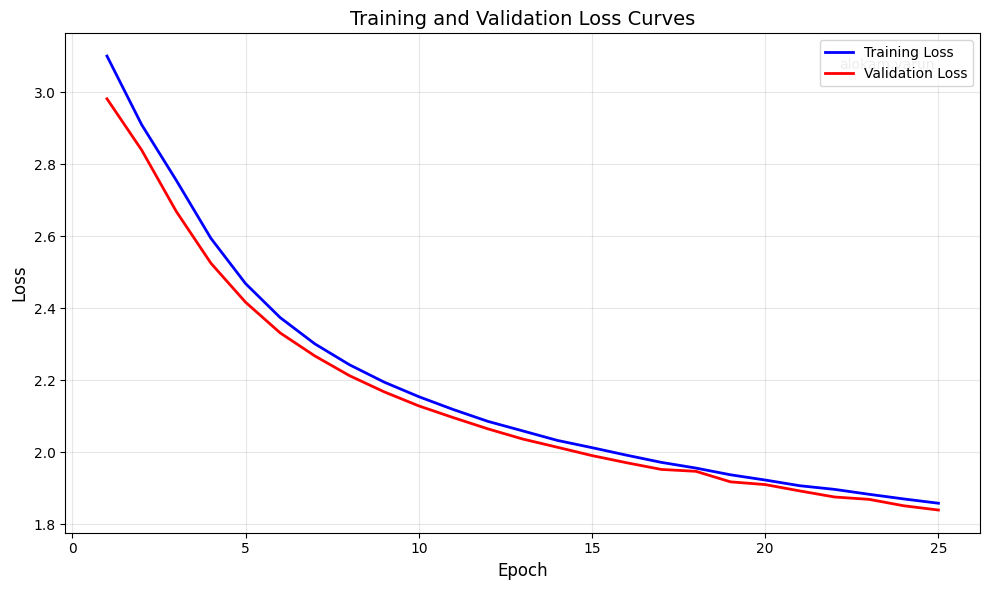

Generating colorization examples...


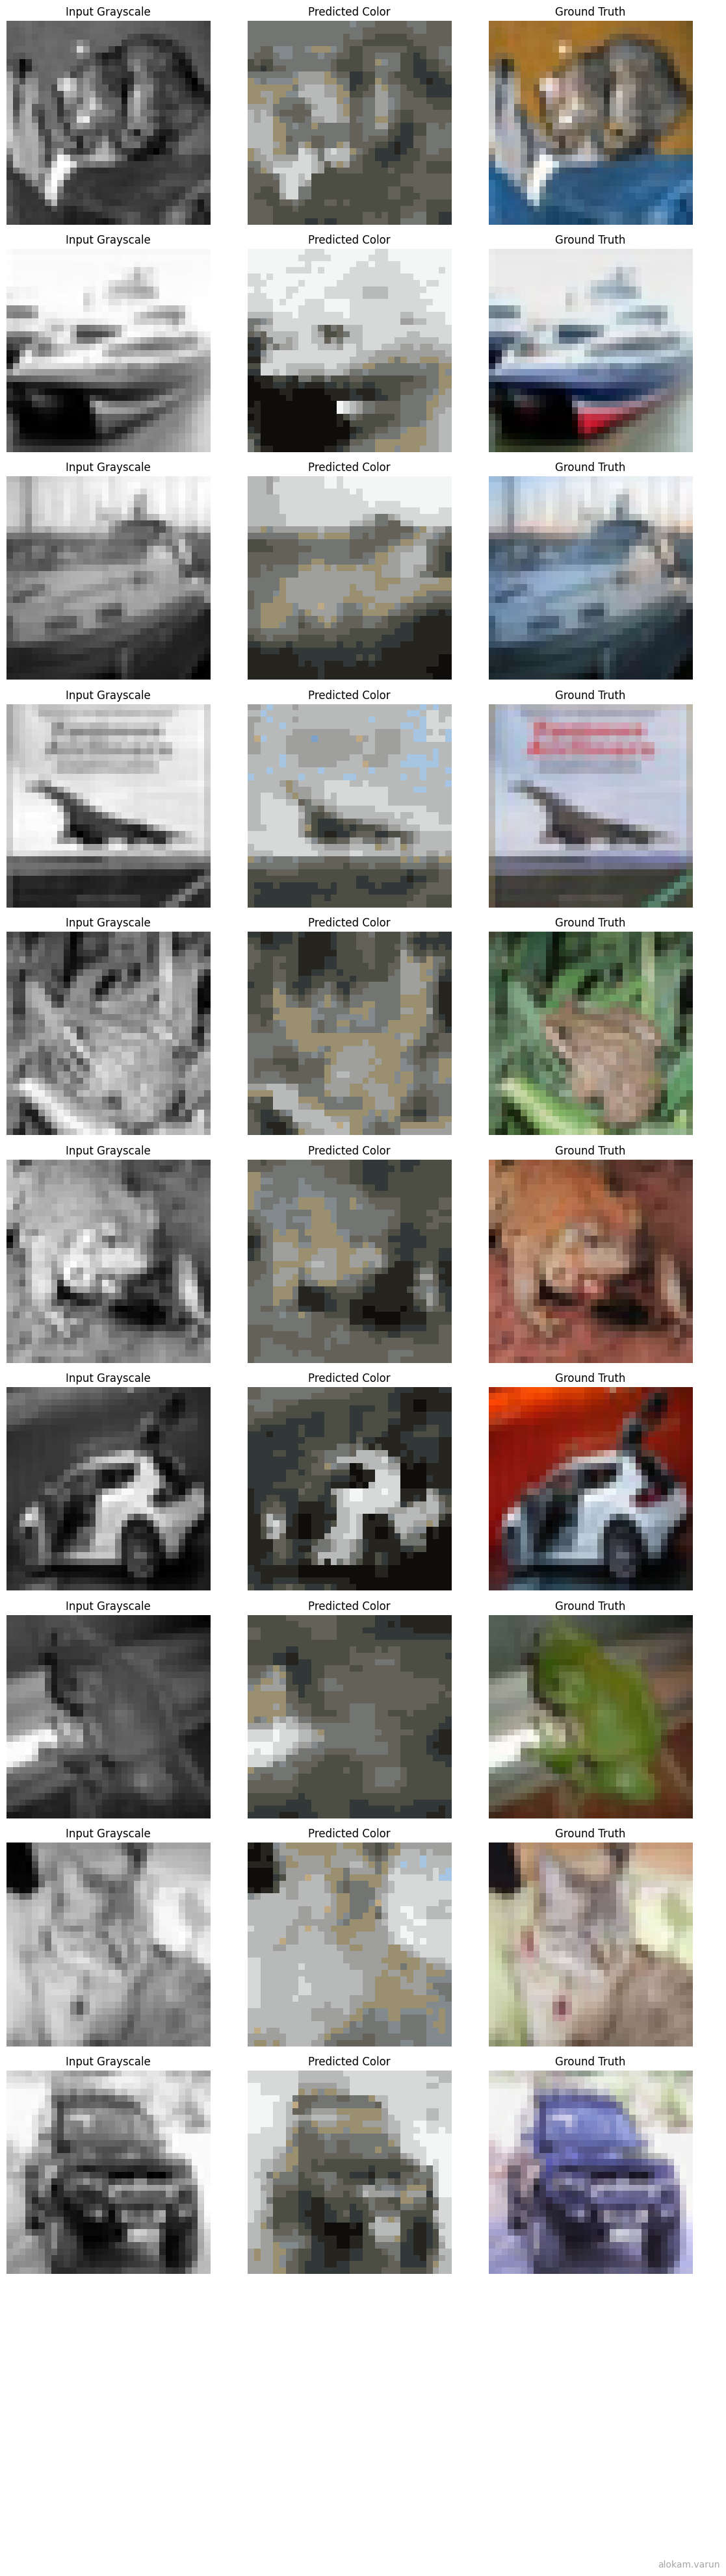

Test Loss: 1.8389

Run 18 completed!
Best Val Loss: 1.8397
Test Loss: 1.8389
Checkpoint: checkpoints_part2_sweep/run_18/best_model.pth



wandb: Agent Starting Run: pwnba36f with config:
wandb: 	NC: 24
wandb: 	NF: 16
wandb: 	NIC: 1
wandb: 	batch_size: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0003
wandb: 	num_epochs: 25
wandb: 	optimizer: SGD



SWEEP RUN 19/20
Config: {'learning_rate': 0.0003, 'batch_size': 32, 'num_epochs': 25, 'NF': 16, 'kernel_size': 3, 'optimizer': 'SGD', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 3.1554, Val Loss: 3.0841


Epoch 2/25 - Train Loss: 2.9946, Val Loss: 2.8962


Epoch 3/25 - Train Loss: 2.8114, Val Loss: 2.7254


Epoch 4/25 - Train Loss: 2.6581, Val Loss: 2.5838


Epoch 5/25 - Train Loss: 2.5395, Val Loss: 2.4802


Epoch 6/25 - Train Loss: 2.4491, Val Loss: 2.3954


Epoch 7/25 - Train Loss: 2.3783, Val Loss: 2.3290


Epoch 8/25 - Train Loss: 2.3247, Val Loss: 2.2808


Epoch 9/25 - Train Loss: 2.2843, Val Loss: 2.2442


Epoch 10/25 - Train Loss: 2.2534, Val Loss: 2.2130


Epoch 11/25 - Train Loss: 2.2287, Val Loss: 2.1932


Epoch 12/25 - Train Loss: 2.2063, Val Loss: 2.1652


Epoch 13/25 - Train Loss: 2.1897, Val Loss: 2.1487


Epoch 14/25 - Train Loss: 2.1718, Val Loss: 2.1288


Epoch 15/25 - Train Loss: 2.1591, Val Loss: 2.1140


Epoch 16/25 - Train Loss: 2.1448, Val Loss: 2.1028


Epoch 17/25 - Train Loss: 2.1335, Val Loss: 2.0874


Epoch 18/25 - Train Loss: 2.1205, Val Loss: 2.0849


Epoch 19/25 - Train Loss: 2.1124, Val Loss: 2.0693


Epoch 20/25 - Train Loss: 2.1038, Val Loss: 2.0551


Epoch 21/25 - Train Loss: 2.0948, Val Loss: 2.0594


Epoch 22/25 - Train Loss: 2.0847, Val Loss: 2.0372


Epoch 23/25 - Train Loss: 2.0781, Val Loss: 2.0406


Epoch 24/25 - Train Loss: 2.0725, Val Loss: 2.0259


Epoch 25/25 - Train Loss: 2.0659, Val Loss: 2.0145
Best val loss: 2.0145 at epoch 25


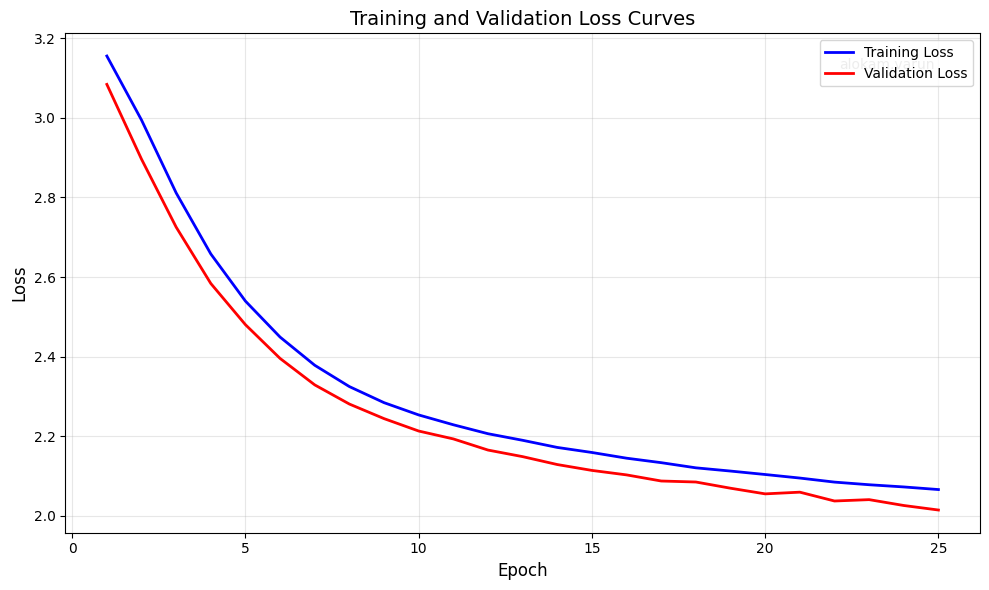

Generating colorization examples...


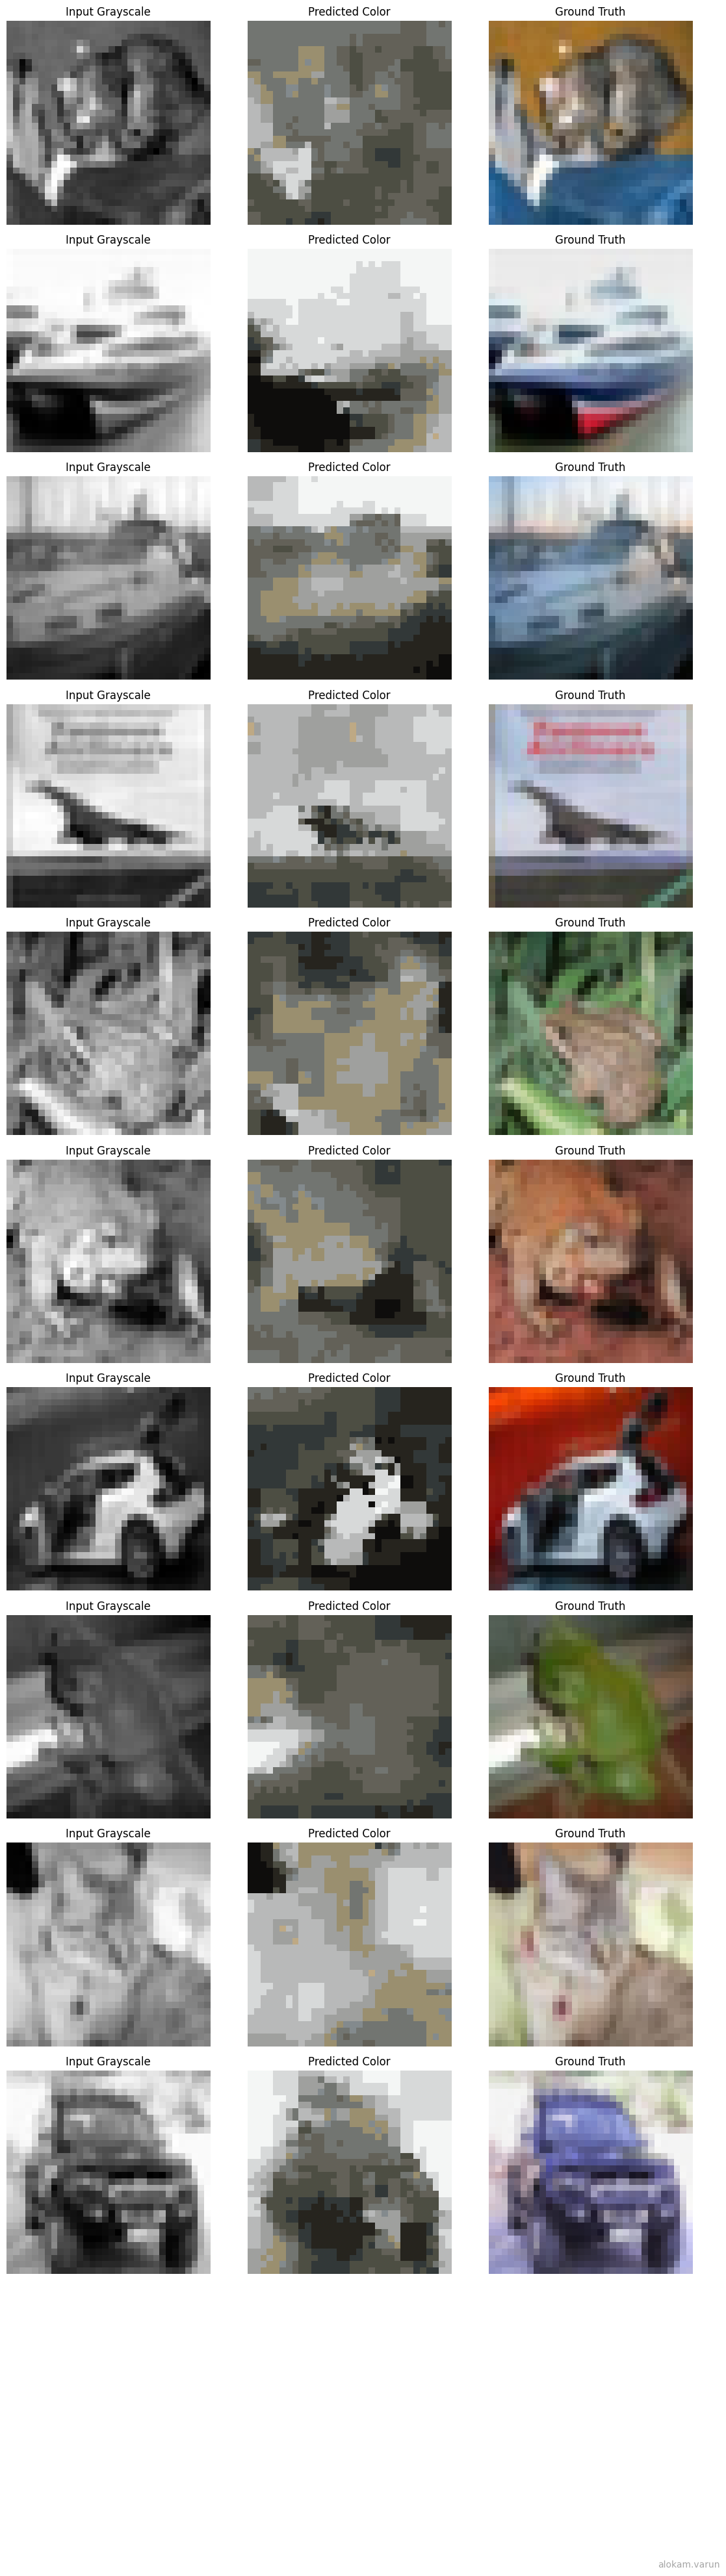

Test Loss: 2.0159

Run 19 completed!
Best Val Loss: 2.0145
Test Loss: 2.0159
Checkpoint: checkpoints_part2_sweep/run_19/best_model.pth



wandb: Agent Starting Run: 5mq0t1cr with config:
wandb: 	NC: 24
wandb: 	NF: 8
wandb: 	NIC: 1
wandb: 	batch_size: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	num_epochs: 25
wandb: 	optimizer: Adam



SWEEP RUN 20/20
Config: {'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 25, 'NF': 8, 'kernel_size': 3, 'optimizer': 'Adam', 'NIC': 1, 'NC': 24}


Epoch 1/25 - Train Loss: 2.4593, Val Loss: 2.1398


Epoch 2/25 - Train Loss: 2.0959, Val Loss: 2.0500


Epoch 3/25 - Train Loss: 2.0367, Val Loss: 2.0031


Epoch 4/25 - Train Loss: 2.0077, Val Loss: 1.9739


Epoch 5/25 - Train Loss: 1.9835, Val Loss: 1.9904


Epoch 6/25 - Train Loss: 1.9700, Val Loss: 1.9479


Epoch 7/25 - Train Loss: 1.9585, Val Loss: 1.9380


Epoch 8/25 - Train Loss: 1.9479, Val Loss: 1.9279


Epoch 9/25 - Train Loss: 1.9389, Val Loss: 1.9964


Epoch 10/25 - Train Loss: 1.9335, Val Loss: 1.9489


Epoch 11/25 - Train Loss: 1.9247, Val Loss: 1.9069


Epoch 12/25 - Train Loss: 1.9219, Val Loss: 1.9263


Epoch 13/25 - Train Loss: 1.9147, Val Loss: 1.8929


Epoch 14/25 - Train Loss: 1.9064, Val Loss: 1.9004


Epoch 15/25 - Train Loss: 1.9054, Val Loss: 1.8842


Epoch 16/25 - Train Loss: 1.9075, Val Loss: 1.8840


Epoch 17/25 - Train Loss: 1.8994, Val Loss: 1.8846


Epoch 18/25 - Train Loss: 1.8960, Val Loss: 1.8969


Epoch 19/25 - Train Loss: 1.8943, Val Loss: 1.8834


Epoch 20/25 - Train Loss: 1.8934, Val Loss: 1.8771


Epoch 21/25 - Train Loss: 1.8910, Val Loss: 1.8727


Epoch 22/25 - Train Loss: 1.8876, Val Loss: 1.8723


Epoch 23/25 - Train Loss: 1.8836, Val Loss: 1.8689


Epoch 24/25 - Train Loss: 1.8870, Val Loss: 1.8793


Epoch 25/25 - Train Loss: 1.8809, Val Loss: 1.8613
Best val loss: 1.8613 at epoch 25


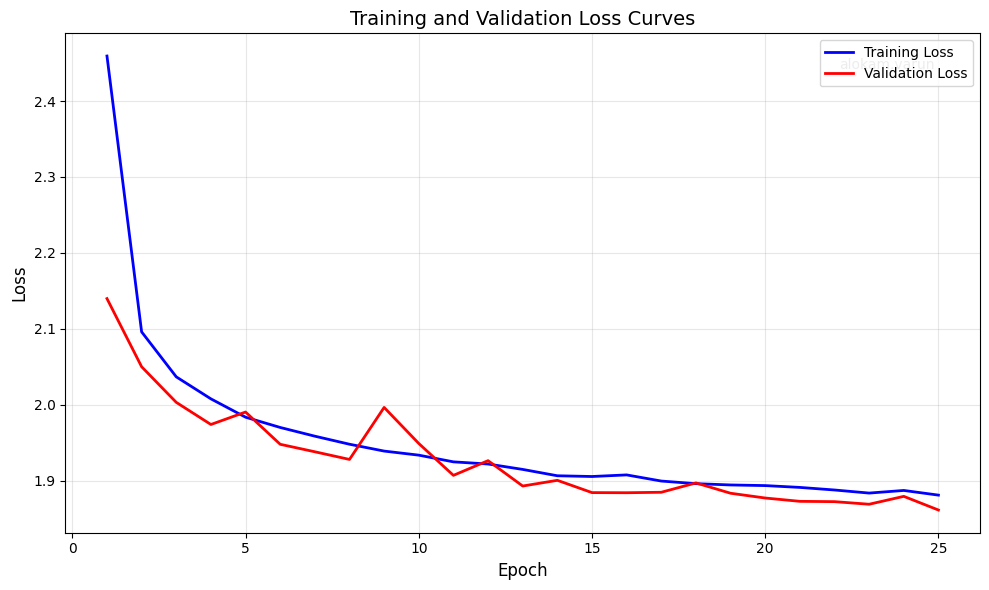

Generating colorization examples...


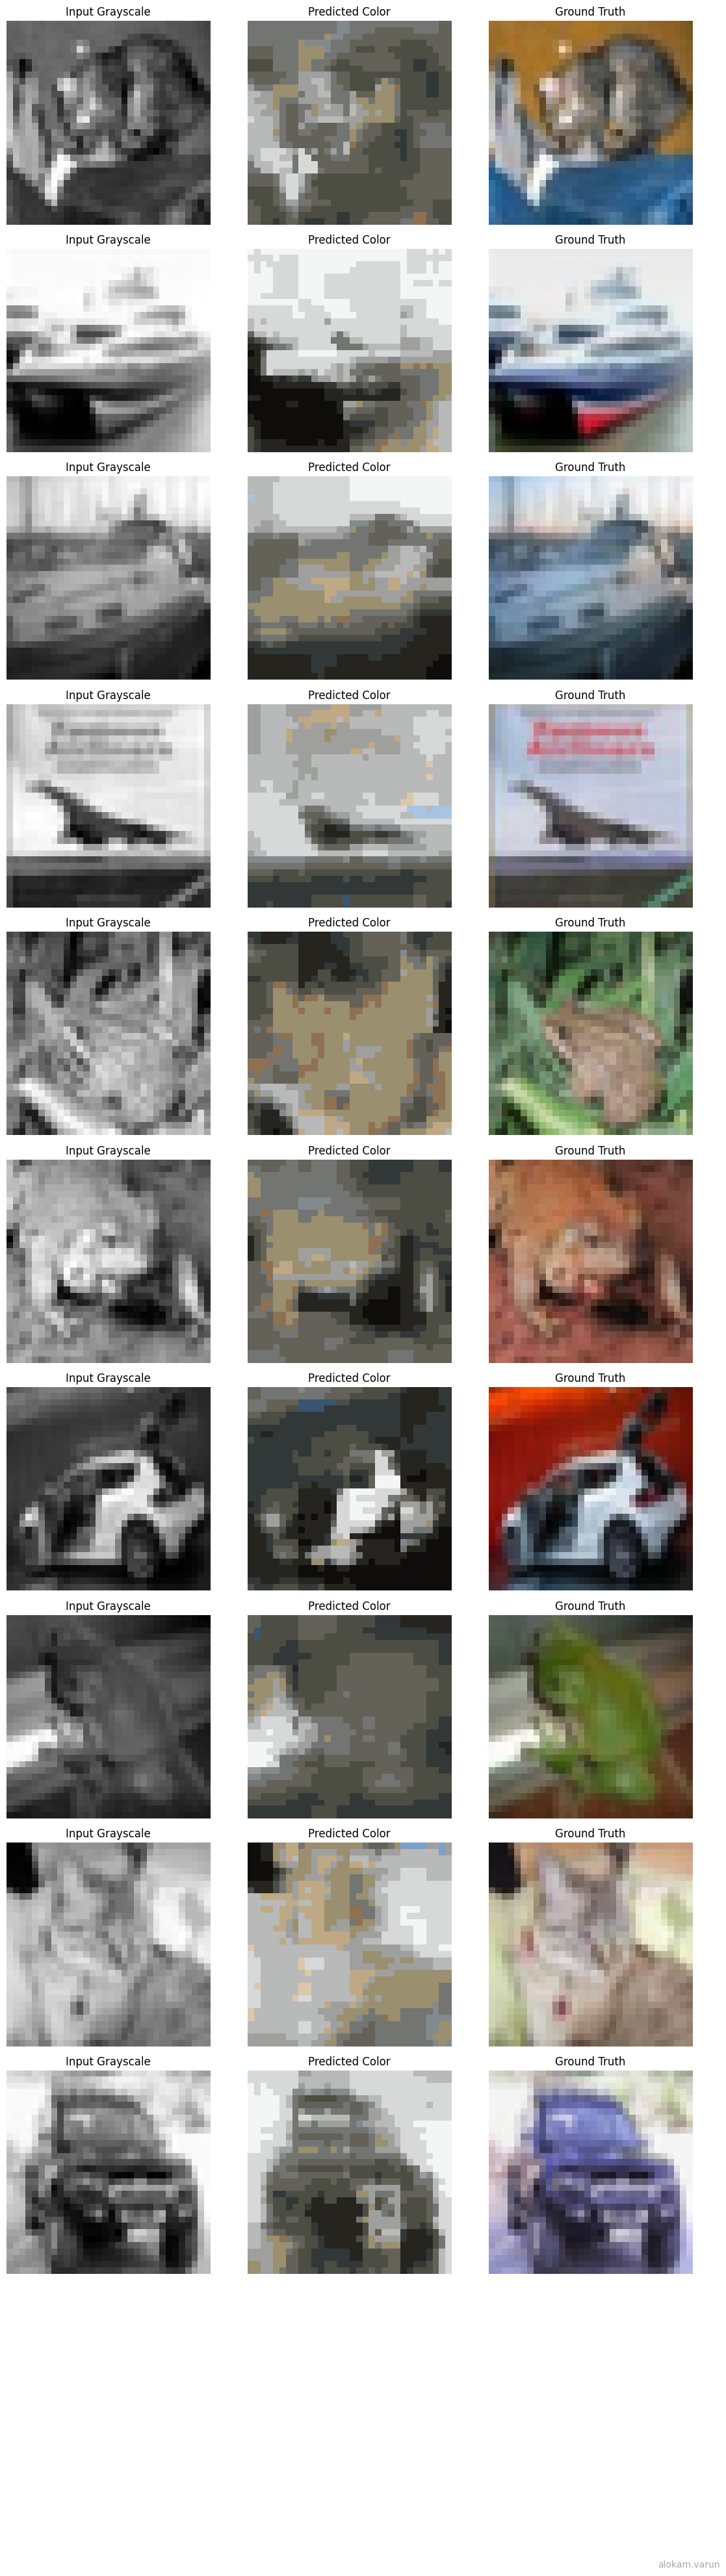

Test Loss: 1.8608

Run 20 completed!
Best Val Loss: 1.8613
Test Loss: 1.8608
Checkpoint: checkpoints_part2_sweep/run_20/best_model.pth




SWEEP COMPLETED!

BEST RUN SUMMARY:
Run Number: 5
Best Validation Loss: 1.4177
Test Loss: 1.4134
Best Epoch: 24

Best Hyperparameters:
  learning_rate: 0.0003
  batch_size: 64
  num_epochs: 25
  NF: 32
  kernel_size: 5
  optimizer: Adam
  NIC: 1
  NC: 24

WandB Run URL: https://wandb.ai/alokamvarun-international-institute-of-information-techn/CIFAR10-Colorization-Part2-Sweep/runs/2m6hchzb
Checkpoint Path: checkpoints_part2_sweep/run_5/best_model.pth

Sweep summary saved to: checkpoints_part2_sweep/sweep_summary.json
All checkpoints saved in: checkpoints_part2_sweep/


In [ ]:
def run_sweep():
    """
    Run hyperparameter sweep using wandb.
    Explores 20 random configurations.
    """
    print("="*70)
    print("PART 2: HYPERPARAMETER SWEEP")
    print("="*70)

    sweep_config = {
        'method': 'random', 
        'metric': {
            'name': 'best_val_loss',
            'goal': 'minimize'
        },
        'parameters': {
            'learning_rate': {
                'values': [1e-4, 3e-4, 1e-3, 3e-3]
            },
            'batch_size': {
                'values': [32, 64, 128]
            },
            'NF': {
                'values': [8, 16, 32]
            },
            'kernel_size': {
                'values': [3, 5]
            },
            'optimizer': {
                'values': ['SGD', 'Adam']
            },
            'num_epochs': {
                'value': 25
            },
            'NIC': {
                'value': 1
            },
            'NC': {
                'value': 24
            }
        }
    }

    print(f"\nTotal configurations to explore: 20 (random sampling)")

    sweep_id = wandb.sweep(sweep_config, project='CIFAR10-Colorization-Part2-Sweep')

    run_counter = {'count': 0}

    all_results = []

    def train_sweep():
        """
        Training function called by wandb agent.
        """
        run_counter['count'] += 1
        run_num = run_counter['count']

        run = wandb.init()
        config = wandb.config

        config_dict = {
            'learning_rate': config.learning_rate,
            'batch_size': config.batch_size,
            'num_epochs': config.num_epochs,
            'NF': config.NF,
            'kernel_size': config.kernel_size,
            'optimizer': config.optimizer,
            'NIC': config.NIC,
            'NC': config.NC
        }

        print(f"\n{'='*70}")
        print(f"SWEEP RUN {run_num}/20")
        print(f"{'='*70}")
        print(f"Config: {config_dict}")

        checkpoint_dir = f'checkpoints_part2_sweep/run_{run_num}'
        os.makedirs(checkpoint_dir, exist_ok=True)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        train_loader = DataLoader(TRAIN_DATASET, batch_size=config_dict['batch_size'],
                                 shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(VAL_DATASET, batch_size=config_dict['batch_size'],
                               shuffle=False, num_workers=2, pin_memory=True)
        test_loader = DataLoader(TEST_DATASET, batch_size=config_dict['batch_size'],
                                shuffle=False, num_workers=2, pin_memory=True)

        model = ColorNet(NIC=config_dict['NIC'], NF=config_dict['NF'],
                        NC=config_dict['NC'], kernel_size=config_dict['kernel_size'])
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()

        if config_dict['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=config_dict['learning_rate'])
        else:
            optimizer = optim.SGD(model.parameters(), lr=config_dict['learning_rate'], momentum=0.9)

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        best_epoch = 0

        for epoch in range(config_dict['num_epochs']):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            train_losses.append(train_loss)

            val_loss = validate(model, val_loader, criterion, device)
            val_losses.append(val_loss)

            if (epoch + 1) % 1 == 0:
                print(f"Epoch {epoch+1}/{config_dict['num_epochs']} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'val_loss': val_loss
            })

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch + 1

                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'config': config_dict
                }

                checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
                torch.save(checkpoint, checkpoint_path)

        print(f"Best val loss: {best_val_loss:.4f} at epoch {best_epoch}")

        checkpoint = torch.load(os.path.join(checkpoint_dir, 'best_model.pth'))
        model.load_state_dict(checkpoint['model_state_dict'])

        fig_loss, ax = plt.subplots(figsize=(10, 6))
        epochs = range(1, len(train_losses) + 1)
        ax.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
        ax.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.set_title(f'Loss Curves - Run {run_num}', fontsize=14)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        plt.text(0.95, 0.95, EMAIL_USERNAME, ha='right', va='top',
                 transform=ax.transAxes, fontsize=10, color='gray', alpha=0.7)
        wandb.log({"loss_curves": wandb.Image(fig_loss)})
        plt.close(fig_loss)

        plot_losses(train_losses, val_losses, EMAIL_USERNAME)

        print("Generating colorization examples...")
        fig_results = visualize_results(model, test_loader, torch.FloatTensor(CENTROIDS),
                                       device, num_samples=10, username=EMAIL_USERNAME)
        wandb.log({"colorization_examples": wandb.Image(fig_results)})
        plt.close(fig_results)

        test_loss = validate(model, test_loader, criterion, device)
        print(f"Test Loss: {test_loss:.4f}")

        wandb.log({
            'test_loss': test_loss,
            'best_val_loss': best_val_loss,
            'best_epoch': best_epoch
        })

        summary = {
            'run_number': run_num,
            'best_epoch': best_epoch,
            'best_val_loss': best_val_loss,
            'test_loss': test_loss,
            'config': config_dict,
            'run_url': run.url,
            'checkpoint_path': checkpoint_path
        }

        with open(os.path.join(checkpoint_dir, 'summary.json'), 'w') as f:
            json.dump(summary, f, indent=4)

        all_results.append(summary)

        print(f"\n{'='*70}")
        print(f"Run {run_num} completed!")
        print(f"Best Val Loss: {best_val_loss:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Checkpoint: {checkpoint_path}")
        print(f"{'='*70}\n")

    print("Running sweep with 20 random configurations...")
    wandb.agent(sweep_id, function=train_sweep, count=20)

    print("\n" + "="*70)
    print("SWEEP COMPLETED!")
    print("="*70)

    if all_results:
        best_run = min(all_results, key=lambda x: x['best_val_loss'])

        print("\nBEST RUN SUMMARY:")
        print("="*70)
        print(f"Run Number: {best_run['run_number']}")
        print(f"Best Validation Loss: {best_run['best_val_loss']:.4f}")
        print(f"Test Loss: {best_run['test_loss']:.4f}")
        print(f"Best Epoch: {best_run['best_epoch']}")
        print("\nBest Hyperparameters:")
        for key, value in best_run['config'].items():
            print(f"  {key}: {value}")
        print(f"\nWandB Run URL: {best_run['run_url']}")
        print(f"Checkpoint Path: {best_run['checkpoint_path']}")
        print("="*70)

        sweep_summary = {
            'total_runs': len(all_results),
            'best_run': best_run,
            'all_results': all_results
        }

        with open('checkpoints_part2_sweep/sweep_summary.json', 'w') as f:
            json.dump(sweep_summary, f, indent=4)

        print(f"\nSweep summary saved to: checkpoints_part2_sweep/sweep_summary.json")
        print(f"All checkpoints saved in: checkpoints_part2_sweep/")


if __name__ == "__main__":
    print("Preparing datasets...")
    TRAIN_DATASET, VAL_DATASET, TEST_DATASET, CENTROIDS = prepare_datasets()

    run_sweep()

In [11]:
!zip -r part1.zip checkpoints_part1

  adding: checkpoints_part1/ (stored 0%)
  adding: checkpoints_part1/summary.json (deflated 41%)
  adding: checkpoints_part1/best_model.pth (deflated 12%)


In [12]:
!zip -r part2.zip checkpoints_part2_sweep

  adding: checkpoints_part2_sweep/ (stored 0%)
  adding: checkpoints_part2_sweep/run_12/ (stored 0%)
  adding: checkpoints_part2_sweep/run_12/summary.json (deflated 43%)
  adding: checkpoints_part2_sweep/run_12/best_model.pth (deflated 21%)
  adding: checkpoints_part2_sweep/run_5/ (stored 0%)
  adding: checkpoints_part2_sweep/run_5/summary.json (deflated 44%)
  adding: checkpoints_part2_sweep/run_5/best_model.pth (deflated 9%)
  adding: checkpoints_part2_sweep/run_1/ (stored 0%)
  adding: checkpoints_part2_sweep/run_1/summary.json (deflated 43%)
  adding: checkpoints_part2_sweep/run_1/best_model.pth (deflated 21%)
  adding: checkpoints_part2_sweep/run_16/ (stored 0%)
  adding: checkpoints_part2_sweep/run_16/summary.json (deflated 44%)
  adding: checkpoints_part2_sweep/run_16/best_model.pth (deflated 15%)
  adding: checkpoints_part2_sweep/run_7/ (stored 0%)
  adding: checkpoints_part2_sweep/run_7/summary.json (deflated 43%)
  adding: checkpoints_part2_sweep/run_7/best_model.pth (deflate

In [13]:
!zip -r wandb.zip wandb

  adding: wandb/ (stored 0%)
  adding: wandb/run-20251030_131643-yupbwt44/ (stored 0%)
  adding: wandb/run-20251030_131643-yupbwt44/logs/ (stored 0%)
  adding: wandb/run-20251030_131643-yupbwt44/logs/debug-internal.log (deflated 72%)
  adding: wandb/run-20251030_131643-yupbwt44/logs/debug.log (deflated 72%)
  adding: wandb/run-20251030_131643-yupbwt44/logs/debug-core.log (deflated 71%)
  adding: wandb/run-20251030_131643-yupbwt44/files/ (stored 0%)
  adding: wandb/run-20251030_131643-yupbwt44/files/output.log (deflated 76%)
  adding: wandb/run-20251030_131643-yupbwt44/files/wandb-summary.json (deflated 48%)
  adding: wandb/run-20251030_131643-yupbwt44/files/checkpoints_part1/ (stored 0%)
  adding: wandb/run-20251030_131643-yupbwt44/files/checkpoints_part1/best_model.pth (deflated 12%)
  adding: wandb/run-20251030_131643-yupbwt44/files/requirements.txt (deflated 56%)
  adding: wandb/run-20251030_131643-yupbwt44/files/config.yaml (deflated 65%)
  adding: wandb/run-20251030_131643-yupbwt4

In [14]:
!zip -r data.zip data

  adding: data/ (stored 0%)
  adding: data/cifar-10-batches-py/ (stored 0%)
  adding: data/cifar-10-batches-py/test_batch (deflated 8%)
  adding: data/cifar-10-batches-py/batches.meta (deflated 12%)
  adding: data/cifar-10-batches-py/data_batch_2 (deflated 8%)
  adding: data/cifar-10-batches-py/readme.html (stored 0%)
  adding: data/cifar-10-batches-py/data_batch_1 (deflated 9%)
  adding: data/cifar-10-batches-py/data_batch_5 (deflated 8%)
  adding: data/cifar-10-batches-py/data_batch_3 (deflated 8%)
  adding: data/cifar-10-batches-py/data_batch_4 (deflated 8%)
  adding: data/cifar-10-python.tar.gz (deflated 0%)


In [16]:
wandb.finish()